# Main Workflow for Investigating UCRB Drought 1998-2022 

## Import packages and prep data

In [1]:
# Import libraries
from datetime import datetime
import numpy as np
import pandas as pd
import glob
import re
import os
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
import matplotlib as mpl
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt, ticker as mticker
from cartopy.io.shapereader import Reader as shpreader
from cartopy.feature import ShapelyFeature
import pymannkendall as mk

# Import custom module
import preprocessing
import calculations

# Import pyeto - Source: https://github.com/woodcrafty/PyETo/tree/master
import pyeto

# Suppress warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
var_names = ['RDC','WT','SC']
MET_vars = ['precip','temp']
start_year = 1998
end_year = 2022
huc = '14'
prefix = 'RDC-WT-SC'
start_date = '1950-01-01'
end_date = '2022-12-31'

# current working directory
base_dir = Path.cwd()

# Define the relative paths
inputs_dir = base_dir / "INPUTS"
outputs_dir = base_dir / "OUTPUTS"

# Define subdirectories within INPUTS
gagesii_dir = inputs_dir / "GAGESII"
met_raw_dir = inputs_dir / "MET_RAW"
nlcd_raw_dir = inputs_dir / "NLCD_RAW"
rdc_wt_sc_raw_dir = inputs_dir / "RDC_WT_SC_RAW"
upper_colorado_river_boundary_dir = inputs_dir / "Upper_Colorado_River_Basin_Boundary"
wt_lstm_data_dir = inputs_dir / "WT_LSTM_data"

# Define subdirectories within OUTPUTS
met_data_dir = outputs_dir / "MET_data"
nlcd_data_dir = outputs_dir / "NLCD_data"
rdc_wt_sc_data_dir = outputs_dir / "RDC_WT_SC_data"
spei_data_dir = outputs_dir / "SPEI_data"

# Ensure OUTPUTS directories exist
met_data_dir.mkdir(parents=True, exist_ok=True)
nlcd_data_dir.mkdir(parents=True, exist_ok=True)
rdc_wt_sc_data_dir.mkdir(parents=True, exist_ok=True)
spei_data_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Define file paths
# raw_met_data_path = met_raw_dir / "HUC14_OREGONSTATE-PRISM-AN81m_tmean_ppt_1980-01-01_2024-09-01.csv" ## Older data (shorter timeseries)
raw_met_data_path = met_raw_dir / "HUC14_OREGONSTATE-PRISM-AN81m_tmean_ppt_1971-01-01_2024-09-01.csv"

gagesii_path = gagesii_dir / "gagesII_metadata.csv"
gagesii_traits_path = gagesii_dir / "processed_dataset.csv"
augmentedWT_data_path = wt_lstm_data_dir / "full_274attr_lstm_outputs_all_huc_14_sites.csv"
RMSE_WT_data_path = wt_lstm_data_dir / "full_274attr_lstm_RMSEs_all_huc_14_sites.csv"

# Read raw meteorological data
# raw_met_data = pd.read_csv(raw_met_data_path)
raw_met_data = pd.read_csv(raw_met_data_path)

# Read GAGESii data
gagesii = pd.read_csv(gagesii_path).set_index('siteid')
gage_loc = gagesii[['LAT_GAGE']]
gagesii_traits = pd.read_csv(gagesii_traits_path).set_index('STAID')

# Read WT LSTM data
augmentedWT_data = pd.read_csv(augmentedWT_data_path, index_col=0)
RMSE_WT_data = pd.read_csv(RMSE_WT_data_path, index_col=0)

## Preprocess data or load already processed dataframes

-----------------------------------
(A) SECTION TO PREPROCESS DATA - after running the files will save, and you can skip this cell for future sessions

In [4]:
data, metadata = preprocessing.load_usgs_basin3d_data(huc, prefix, start_date, end_date, rdc_wt_sc_raw_dir, filename_suffix="_DAY.h5")
print('--------------------------')

Returning the data and metadata extracted by the BASIN3D data loader.
--------------------------


In [5]:
list_data_dfs, list_metadata_dfs = preprocessing.make_var_dfs(data, metadata,start_date,end_date,augmentedWT_data, RMSE_WT_data)
print('--------------------------')

Processing RDC data...
Processing WT data...
Finished combining augmented WT data with original.
Finished adding augmented WT data.
Processing SC data...
Finished processing all variables:
- Separated data and metadata by variable
- Extracted daily Mean and calculated Min/Max average
- Checked for ICE and -9999 values
- Regrouped to water years
--------------------------


In [6]:
list_avail_dfs,list_peravail_dfs = preprocessing.apply_criteria_get_avail(list_data_dfs)
print('--------------------------')

Processing availability for RDC...
Processing availability for WT...
Processing availability for SC...
Finished applying criteria: 10 days per month, 11 months per year
--------------------------


In [7]:
list_data_filtered_dfs,list_metadata_filtered_dfs,list_avail_filtered_dfs = preprocessing.delete_save_sites(rdc_wt_sc_data_dir,list_avail_dfs,list_data_dfs,list_metadata_dfs)
print('--------------------------')

Processing RDC data...
  Removing 181 sites with no availability
  Sites with any availability: 925
  Saved RDC data files
Processing WT data...
  Removing 97 sites with no availability
  Sites with any availability: 114
  Saved WT data files
Processing SC data...
  Removing 85 sites with no availability
  Sites with any availability: 102
  Saved SC data files
Finished processing all variables:
- Removed sites with no availability
- Cleared data from years that do not meet criteria
- All data saved to /Users/emilynagamoto/PycharmProjects/drought-impacts-updates/UCRB-drought/OUTPUTS/RDC_WT_SC_data/Water_year/
--------------------------


In [8]:
temp_df_index, precip_df_index = preprocessing.split_met_data(raw_met_data, met_data_dir)
print('--------------------------')

Finished splitting temp and precip.
- All data saved to /Users/emilynagamoto/PycharmProjects/drought-impacts-updates/UCRB-drought/OUTPUTS/MET_data/
--------------------------


In [9]:
overall_nlcd_change = preprocessing.nlcd_processing(nlcd_raw_dir, nlcd_data_dir, start_year, end_year) 
print('--------------------------')

Processing NLCD data for counties in AZ, CO, NM, UT, WY...
Found 3 counties for AZ
Found 32 counties for CO
Found 4 counties for NM
Found 16 counties for UT
Found 7 counties for WY
NLCD change calculated for period 1998 to 2022
NLCD data saved to /Users/emilynagamoto/PycharmProjects/drought-impacts-updates/UCRB-drought/OUTPUTS/NLCD_data
--------------------------


In [10]:
# formatting 
for num, var in enumerate(var_names):
    vars()[str(var)+'_data'] = list_data_filtered_dfs[num]
    vars()[str(var)+'_meta'] = list_metadata_filtered_dfs[num]
    vars()[str(var)+'_avail_df'] = list_avail_filtered_dfs[num]
    vars()[str(var)+'_data'].columns = vars()[str(var)+'_data'].columns.astype('int')
    vars()[str(var)+'_meta'].columns = vars()[str(var)+'_meta'].columns.astype('int')
    vars()[str(var)+'_avail_df'].columns = vars()[str(var)+'_avail_df'].columns.astype('int')

gagesii.index = gagesii.index.astype('int')
for MET in MET_vars:
    vars()[MET+'_df_index'].columns= vars()[MET+'_df_index'].columns.astype('int')

In [11]:
# Calculate PET  - to be used for SPEI calculation
pet_data_df = calculations.calculate_pet(temp_df_index, gage_loc, met_data_dir)
print('--------------------------')
pet_data_df.columns= pet_data_df.columns.astype('int')

PET calculation completed.
PET data saved to /Users/emilynagamoto/PycharmProjects/drought-impacts-updates/UCRB-drought/OUTPUTS/MET_data/pet_calc_thorn.csv
--------------------------


_____________________
(B) If skipping ^ SECTION TO PREPROCESS DATA - Start here to load the data

In [12]:
# if you have saved data from prior preprocessing - load
for var in var_names:
    vars()[str(var)+'_data'] = pd.read_csv(rdc_wt_sc_data_dir / 'Water_year' / (var+'_semicleaned_wy.csv'))
    vars()[str(var)+'_meta'] = pd.read_csv(rdc_wt_sc_data_dir / 'Water_year' / (var+'_metadata_wy.csv'))
    vars()[str(var)+'_avail_df'] = pd.read_csv(rdc_wt_sc_data_dir / 'Water_year' / (var+'_availability_wy.csv'))
    
    vars()[str(var)+'_data'].set_index(['wyear','month','day'],inplace=True)
    vars()[str(var)+'_meta'].rename({'Unnamed: 0':'siteid'},axis=1,inplace=True)
    vars()[str(var)+'_meta'].set_index('siteid',inplace=True)
    vars()[str(var)+'_avail_df'].rename({'Unnamed: 0':'wyear'},axis=1,inplace=True)
    vars()[str(var)+'_avail_df'].set_index('wyear',inplace=True)
    vars()[str(var)+'_data'].columns = vars()[str(var)+'_data'].columns.astype('int')
    vars()[str(var)+'_meta'].columns = vars()[str(var)+'_meta'].columns.astype('int')
    vars()[str(var)+'_avail_df'].columns = vars()[str(var)+'_avail_df'].columns.astype('int')
    

for MET in MET_vars:
    vars()[MET+'_df_index'] = pd.read_csv(met_data_dir / (MET+'_raw_2024_09_01.csv'))
    vars()[MET+'_df_index'].set_index(['year','month'],inplace=True)
    vars()[MET+'_df_index'].columns= vars()[MET+'_df_index'].columns.astype('int')

pet_data_df  = pd.read_csv(met_data_dir /'pet_calc_thorn.csv')
pet_data_df.set_index(['year','month'],inplace=True)
pet_data_df.columns= pet_data_df.columns.astype('int')
gagesii.index = gagesii.index.astype('int')

## Prepare Data
(A) and (B) from above need to run this

In [13]:
# normalize Q by basin size
RDC_ready = preprocessing.q_normalization(gagesii, RDC_data)
# name data the same and make list
list_all_data = [RDC_ready]
for var in var_names[1:]:
    vars()[str(var)+'_ready'] = vars()[str(var)+'_data'].copy()
    list_all_data.append(vars()[str(var)+'_ready'])

In [14]:
# prep to calculate SPEI
MET_sites_in_gages = list(set(gagesii.index.values).intersection(precip_df_index.columns.values))
precip = precip_df_index[MET_sites_in_gages]
pet = pet_data_df[MET_sites_in_gages]
gagesii_int = gagesii.transpose()[MET_sites_in_gages].transpose()

In [15]:
# make sure all sites also have MET data:
print('Sites with Q but not meteorologic data:',list(set(RDC_ready.columns) - set(gagesii_int.index)))

Sites with Q but not meteorologic data: []


In [16]:
#RDC_ready.drop(columns=(list(set(RDC_ready.columns) - set(gagesii_int.index))),inplace=True)

## Calculate SPEI

-----------------------------------
(A) SECTION TO CALCULATE SPEI - after running the files will save, and you can skip this cell for future sessions

In [17]:
# calculate SPEI
ann_spei_wyears, TRUN_ann_spei_wyears = calculations.calc_SPEI(gagesii_int,precip,pet,spei_data_dir,start_year,end_year)

Calculating SPEI (Standardized Precipitation Evapotranspiration Index)...
Calculated water deficit (P - PET) for 372 basins
Calculated 12-month rolling mean of water deficit
Calculated SPEI for 372 basins
Calculated annual SPEI values for water years 1971 to 2023
Truncated annual SPEI covers water years 1998 to 2022
SPEI data saved to /Users/emilynagamoto/PycharmProjects/drought-impacts-updates/UCRB-drought/OUTPUTS/SPEI_data


-----------------------------------
(B) If skipping ^ SECTION TO CALCULATE SPEI - start here to load the SPEI data

In [18]:
## LOAD DATASETS
TRUN_ann_spei_wyears = pd.read_csv(spei_data_dir / 'TRUN_ann_spei_wy.csv')
TRUN_ann_spei_wyears.set_index('wyear',inplace=True)

## Relative Change: Use SPEI to calulate difference in Drought VS Reference years

In [19]:
# identify dr and ref years
dr_years,dr_names, list_dr_years, list_ref_years, list_all_years = calculations.identify_years(TRUN_ann_spei_wyears, 
                                                                                               drought_threshold=-1, 
                                                                                               reference_threshold=1, window_size=3)

Identified 6 drought years: [2001, 2002, 2012, 2018, 2020, 2021]
Grouped into 4 drought events: ['2001_2002', '2012', '2018', '2020_2021']


In [20]:
## make datafames for reference, dr, all years for each episode
for number,drought in enumerate(dr_names):
    vars()['dr_all3_years_'+drought] = list_all_years[number]
    vars()['ref_all3_years_'+drought] = list_ref_years[number]
    vars()['dr_years_all3_'+drought] = list_dr_years[number]
        
#### Grab sites with data for drought episodes 
for num,var in enumerate(var_names):       
    for drought in dr_names:
        vars()[str(var)+'_all3_'+drought] = list_all_data[num].copy()
            
        for site in vars()[str(var)+'_avail_df'].columns: 
            for year in vars()['dr_all3_years_'+drought]: 
                if vars()[str(var)+'_avail_df'].at[year,site] == 0:
                    if site in vars()[str(var)+'_all3_'+drought].columns.values:
                        vars()[str(var)+'_all3_'+drought].drop(site, axis=1, inplace=True)

    ## make datafames for reference years for each episode
for dr in dr_names:
    for var in var_names:
        vars()[str(var)+'_refyrs_all3_'+str(dr)] = vars()[str(var)+'_all3_'+str(dr)].transpose()[vars()['ref_all3_years_'+dr]].transpose()
    
    ## grab only drought years
dr_names_1yr = ['2012', '2018']
for dr in dr_names_1yr:
    for var in var_names:
        vars()[str(var)+'_dryrs_all3_'+dr] = vars()[str(var)+'_all3_'+dr].transpose()[int(dr)].transpose()

for var in var_names:
    vars()[str(var)+'_dryrs_all3_2001_2002'] = vars()[str(var)+'_all3_2001_2002'].transpose()[[2001,2002]].transpose()
    vars()[str(var)+'_dryrs_all3_2020_2021'] = vars()[str(var)+'_all3_2020_2021'].transpose()[[2020,2021]].transpose()

In [21]:
## combine all of the drought episodes into a list of total sites
# these lists will be used later on - ex SPEI plot
for var in var_names:
    vars()[var+'_all3_allsites'] = []
    for dr in dr_names:
        vars()[var+'_all3_allsites'] = list(set(vars()[var+'_all3_allsites']) | set(vars()[var+'_all3_'+dr].columns.values))
    print(var+': '+str(len(vars()[var+'_all3_allsites'])))
    
all3_all_sites = list(set(vars()['RDC_all3_allsites']) | set(vars()['WT_all3_allsites']) | set(vars()['SC_all3_allsites']))
print(len(all3_all_sites))

RDC: 202
WT: 36
SC: 23
209


#### Comparing Median and Mean
We use the Median of annual site Medians, but we compared with with the Mean of annual site Medians. 

In [22]:
# calculate VAR relative change - ANNUAL and monthly - MEDIAN and MEAN
for var in var_names:
    for dr in dr_names:
        df_ref = vars()[str(var)+'_refyrs_all3_'+str(dr)]
        df_dr = vars()[str(var)+'_dryrs_all3_'+dr]
        #        annual_relative_change,   drought_annual_median, reference_annual_median,annual_difference
        vars()[var+'_ann_MEDrelchange_'+dr], vars()[var+'_ann_MEDdrought_'+dr], vars()[var+'_ann_MEDref_'+dr], vars()[str(var)+'_ann_MEDdiff_'+dr]  = calculations.rel_change_median_annual(df_ref,df_dr,dr)
        vars()[var+'_ann_MEANrelchange_'+dr], vars()[var+'_ann_MEANdrought_'+dr], vars()[var+'_ann_MEANref_'+dr], vars()[str(var)+'_ann_MEANdiff_'+dr]  = calculations.rel_change_mean_annual(df_ref,df_dr,dr)
        
        vars()[var+'_mon_MEDrelchange_'+dr], vars()[var+'_mon_MEDdrought_'+dr], vars()[var+'_mon_MEDref_'+dr], vars()[str(var)+'_mon_MEDdiff_'+dr]  = calculations.rel_change_median_monthly(df_ref,df_dr,dr)
        vars()[var+'_mon_MEANrelchange_'+dr], vars()[var+'_mon_MEANdrought_'+dr], vars()[var+'_mon_MEANref_'+dr], vars()[str(var)+'_mon_MEANdiff_'+dr]  = calculations.rel_change_mean_monthly(df_ref,df_dr,dr)
        

In [23]:
print('basin avg relchange')
var = var_names[0]
months = vars()[var+'_mon_MEDref_'+dr].index
for i in range(12):
    month = months[i]
    var_var =(vars()[var+'_mon_MEDrelchange_'+dr_names[0]].loc[month] + vars()[var+'_mon_MEDrelchange_'+dr_names[1]].loc[month] + vars()[var+'_mon_MEDrelchange_'+dr_names[2]].loc[month] + vars()[var+'_mon_MEDrelchange_'+dr_names[3]].loc[month] )/4
    var_MET = (vars()[var+'_mon_MEANrelchange_'+dr_names[0]].loc[month] + vars()[var+'_mon_MEANrelchange_'+dr_names[1]].loc[month] + vars()[var+'_mon_MEANrelchange_'+dr_names[2]].loc[month] + vars()[var+'_mon_MEANrelchange_'+dr_names[3]].loc[month] )/4
    print(month,'median:',str(var_var.mean()),'mean:',str(var_MET.mean()),'diff:',str(var_var.mean() - var_MET.mean()))

basin avg relchange
10 median: 17.020751294255348 mean: 2.9858734013685573 diff: 14.03487789288679
11 median: 9.445832990906897 mean: 4.829866496939509 diff: 4.615966493967388
12 median: 6.36419978376508 mean: 2.9009320345185916 diff: 3.463267749246488
1 median: 0.5100817165035022 mean: -2.693189565769675 diff: 3.2032712822731773
2 median: -3.4694570497531267 mean: -8.632549078315071 diff: 5.163092028561945
3 median: -4.533094774546762 mean: -13.858942001963817 diff: 9.325847227417054
4 median: -9.070439846260285 mean: -17.20525938607704 diff: 8.134819539816753
5 median: -11.431652653624852 mean: -21.778353884708487 diff: 10.346701231083635
6 median: -61.730525941518835 mean: -65.85479005630519 diff: 4.124264114786357
7 median: -47.05011403828192 mean: -56.84883542221482 diff: 9.7987213839329
8 median: -35.19654569640745 mean: -41.536509340089154 diff: 6.339963643681706
9 median: -33.30911563741695 mean: -39.03194890212048 diff: 5.722833264703532


In [24]:
### create dataset of all sites for all drought episodes (one dataset for all rel change values)
### average together episodes for sites that occur in more than one drought episodes, but still include sites that only occur in one episode

#(1) concat the rel changes for each episode, creating 1 table per var
for var in var_names:
    vars()[var+'_listdr_epis_relchange_all3'] = []
    vars()[var+'_listdr_epis_dr_all3'] = []
    vars()[var+'_listdr_epis_ref_all3'] = []
    
    for dr in dr_names:
        # rename relative change column from '0'
        vars()[var+'_ann_MEDrelchange_'+dr].to_frame().rename(columns={0:'Rel.Change'},inplace=True)
        vars()[var+'_listdr_epis_relchange_all3'].append(vars()[var+'_ann_MEDrelchange_'+dr])

        vars()[var+'_ann_MEDdrought_'+dr].to_frame().rename(columns={0:'DR'},inplace=True)
        vars()[var+'_listdr_epis_dr_all3'].append(vars()[var+'_ann_MEDdrought_'+dr])
        vars()[var+'_ann_MEDref_'+dr].to_frame().rename(columns={0:'REF'},inplace=True)
        vars()[var+'_listdr_epis_ref_all3'].append(vars()[var+'_ann_MEDref_'+dr])
    
    
    # mean of all the dr eps
    vars()[var+'_MEDrelchange_allsites_all3'] = pd.concat(vars()[var+'_listdr_epis_relchange_all3'])
    vars()[var+'_MEDrelchange_all3'] = vars()[var+'_MEDrelchange_allsites_all3'].groupby(level=0).mean()

    vars()[var+'_MEDdr_allsites_all3'] = pd.concat(vars()[var+'_listdr_epis_dr_all3'])
    vars()[var+'_MEDdr_all3'] = vars()[var+'_MEDdr_allsites_all3'].groupby(level=0).mean()
    vars()[var+'_MEDref_allsites_all3'] = pd.concat(vars()[var+'_listdr_epis_ref_all3'])
    vars()[var+'_MEDref_all3'] = vars()[var+'_MEDref_allsites_all3'].groupby(level=0).mean()
    
    # print median site
    print('Median Annual Relative Change: ',var,vars()[var+'_MEDrelchange_all3'].median()) # Median relative change across the basin USED IN THE ABSTRACT!!
    print('Median Annual DR: ',var,vars()[var+'_MEDdr_all3'].median())
    print('Median Annual Ref: ',var,vars()[var+'_MEDref_all3'].median())

Median Annual Relative Change:  RDC -14.553440176798679
Median Annual DR:  RDC 0.0021390414452475276
Median Annual Ref:  RDC 0.0025927632438992
Median Annual Relative Change:  WT 8.541186190317294
Median Annual DR:  WT 9.759375
Median Annual Ref:  WT 9.1375
Median Annual Relative Change:  SC 5.38492901525414
Median Annual DR:  SC 961.4166666666666
Median Annual Ref:  SC 852.75


In [25]:
##### want to check what would it would be if we took the MEAN of the annual medians? 
#####  UNCOMMENT this cell to run it and see the difference

### create dataset of all sites for all drought episodes (one dataset for all rel change values)
### average together episodes for sites that occur in more than one drought episodes, but still include sites that only occur in one episode

# #(1) concat the rel changes for each episode, creating 1 table per var
# for var in var_names:
#     vars()[var+'_listdr_epis_relchange_all3_MEAN'] = []
#     for dr in dr_names:
#         # rename relative change column from '0'
#         vars()[var+'_ann_MEANrelchange_'+dr].to_frame().rename(columns={0:'Rel.Change'},inplace=True)
#         vars()[var+'_listdr_epis_relchange_all3_MEAN'].append(vars()[var+'_ann_MEANrelchange_'+dr])
#     vars()[var+'_MEANrelchange_allsites_all3'] = pd.concat(vars()[var+'_listdr_epis_relchange_all3_MEAN'])
#     vars()[var+'_MEANrelchange_all3'] = vars()[var+'_MEANrelchange_allsites_all3'].groupby(level=0).mean()

#     print('Median (MEAN) Annual Relative Change: ',var,vars()[var+'_MEANrelchange_all3'].median()) # Median relative change across the basin USED IN THE ABSTRACT!!

In [26]:
median_dr = []
mean_dr = []
median_ref = []
mean_ref = []

for dr in dr_names:
    # mean_ref.append(vars()['RDC_ann_MEANref_'+dr])
    # mean_dr.append(vars()['RDC_ann_MEANdrought_'+dr])

    median_ref.append(vars()['RDC_ann_MEDref_'+dr])
    median_dr.append(vars()['RDC_ann_MEDdrought_'+dr])

### Saving relative change data

In [27]:
# Create output directory if it doesn't exist
output_dir = os.path.join(rdc_wt_sc_data_dir, 'Median_Relchange')
os.makedirs(output_dir, exist_ok=True)

In [28]:
for var in var_names:
    for dr in dr_names:
        # drop median column
        #vars()[var+'_MedianMonthly_relchange_'+dr] = vars()[var+'_mon_MEDrelchange_'+dr].drop(columns={"Median"})
        vars()[var+'_mon_MEDrelchange_'+dr].to_csv(rdc_wt_sc_data_dir /'Median_Relchange'/ (var+'_MedianMonthly_relchange_'+dr+'.csv'))

### Analyze meteorological data

In [29]:
# long term climatology
longterm_avg_start=1998
list_met_wyears = []
for MET in MET_vars:
    vars()[MET+'_wyear'] = preprocessing.convert_to_water_years(vars()[MET+'_df_index'])
    vars()[MET+'_wyear'] = vars()[MET+'_wyear'][MET_sites_in_gages]
    list_met_wyears.append(vars()[MET+'_wyear'])
basin_avg_precip_allyrs, basin_avg_temp_allyrs,congruentsitelist_all3_precip, congruentsitelist_all3_temp,precip_avg_list,temp_avg_list = calculations.calculate_meteorological_climatology(list_met_wyears,all3_all_sites,dr_years,longterm_avg_start)

for MET in MET_vars:
    for num,dr in enumerate(dr_names):
        vars()[MET+'_avg_'+str(dr)] = vars()[MET+'_avg_list'][num]


In [30]:
# calculate relative change each meteorological variable
for var_idx, var in enumerate(MET_vars):
    for dr in dr_names:
        # Filter data for reference and drought periods
        df_ref = vars()['congruentsitelist_all3_'+var][vars()['congruentsitelist_all3_'+var].index.get_level_values('wyear').isin(vars()['ref_all3_years_'+dr])]
        df_dr = vars()['congruentsitelist_all3_'+var][vars()['congruentsitelist_all3_'+var].index.get_level_values('wyear').isin(vars()['dr_years_all3_'+dr])]
        
        #        annual_relative_change,   drought_annual_median, reference_annual_median,annual_difference
        vars()[var+'_ann_MEDrelchange_'+dr], vars()[var+'_ann_MEDdrought_'+dr], vars()[var+'_ann_MEDref_'+dr], vars()[str(var)+'_ann_MEDdiff_'+dr]  = calculations.rel_change_median_annual(df_ref,df_dr,dr)
        vars()[var+'_ann_MEANrelchange_'+dr], vars()[var+'_ann_MEANdrought_'+dr], vars()[var+'_ann_MEANref_'+dr], vars()[str(var)+'_ann_MEANdiff_'+dr]  = calculations.rel_change_mean_annual(df_ref,df_dr,dr)
        
        vars()[var+'_mon_MEDrelchange_'+dr], vars()[var+'_mon_MEDdrought_'+dr], vars()[var+'_mon_MEDref_'+dr], vars()[str(var)+'_mon_MEDdiff_'+dr]  = calculations.rel_change_median_monthly(df_ref,df_dr,dr)
        vars()[var+'_mon_MEANrelchange_'+dr], vars()[var+'_mon_MEANdrought_'+dr], vars()[var+'_mon_MEANref_'+dr], vars()[str(var)+'_mon_MEANdiff_'+dr]  = calculations.rel_change_mean_monthly(df_ref,df_dr,dr)
             

In [31]:
### create dataset of all sites for all drought episodes (one dataset for all rel change values)
### average together episodes for sites that occur in more than one drought episodes, but still include sites that only occur in one episode

#(1) concat the rel changes for each episode, creating 1 table per var
for MET in MET_vars:
    vars()[MET+'_listdr_epis_relchange_all3'] = []
    for dr in dr_names:
        # rename relative change column from '0'
        #vars()[var+'_ANN_MEDrelchange_'+dr].rename(columns={0:'Rel.Change'},inplace=True)
        vars()[MET+'_listdr_epis_relchange_all3'].append(vars()[MET+'_ann_MEDrelchange_'+dr])
    vars()[MET+'_MEDrelchange_allsites_all3'] = pd.concat(vars()[MET+'_listdr_epis_relchange_all3'])
    vars()[MET+'_MEDrelchange_all3'] = vars()[MET+'_MEDrelchange_allsites_all3'].groupby(level=0).mean()

    print('Median Annual Relative Change: ',MET,vars()[MET+'_MEDrelchange_all3'].median()) # Median relative change across the basin USED IN THE ABSTRACT!!

Median Annual Relative Change:  precip -23.091449970292423
Median Annual Relative Change:  temp 24.843321769357967


In [32]:
##### want to check what would it would be if we took the MEAN of the annual medians? 
#####  UNCOMMENT this cell to run it and see the difference

### create dataset of all sites for all drought episodes (one dataset for all rel change values)
### average together episodes for sites that occur in more than one drought episodes, but still include sites that only occur in one episode

# #(1) concat the rel changes for each episode, creating 1 table per var
# for MET in MET_vars:
#     vars()[MET+'_listdr_epis_relchange_all3'] = []
#     for dr in dr_names:
#         # rename relative change column from '0'
#         #vars()[var+'_ANN_MEDrelchange_'+dr].rename(columns={0:'Rel.Change'},inplace=True)
#         vars()[MET+'_listdr_epis_relchange_all3'].append(vars()[MET+'_ann_MEANrelchange_'+dr])
#     vars()[MET+'_MEANrelchange_allsites_all3'] = pd.concat(vars()[MET+'_listdr_epis_relchange_all3'])
#     vars()[MET+'_MEANrelchange_all3'] = vars()[MET+'_MEANrelchange_allsites_all3'].groupby(level=0).mean()

#     print('Median (MEAN) Annual Relative Change: ',MET,vars()[MET+'_MEANrelchange_all3'].median()) # Median relative change across the basin USED IN THE ABSTRACT!!

## Preparing Spatial Information

In [33]:
list_mapping = []
for var in var_names:
    vars()[var+'_MEDrelchange_map_all3'] = vars()[var+'_MEDrelchange_all3'].to_frame()
    vars()[var+'_MEDrelchange_map_all3'].rename(columns={0:'Relative Change (%)'},inplace=True)
    list_mapping.append(vars()[var+'_MEDrelchange_map_all3']) 

try:
    list_metadata_filtered_dfs
except NameError:
    list_metadata_filtered_dfs = []   
    for var in var_names:
        list_metadata_filtered_dfs.append(vars()[str(var)+'_meta'])
        
list_mapping_return = calculations.prep_mapping(list_mapping,list_metadata_filtered_dfs, gagesii)

#### sites with RMSE under 2
PUBS_sites_all3 = RMSE_WT_data[RMSE_WT_data['rmse']<2]['huc_id'].values

In [34]:
for num,var in enumerate(var_names):
    vars()[var+'_MEDrelchange_map_all3'] = list_mapping_return[num]
    print(var)
    print('Sites with Rel.change >0: ',len(vars()[var+'_MEDrelchange_map_all3'][vars()[var+'_MEDrelchange_map_all3']['Relative Change (%)']>0]))
    print('Sites with Rel.change <0: ',len(vars()[var+'_MEDrelchange_map_all3'][vars()[var+'_MEDrelchange_map_all3']['Relative Change (%)']<0]))
    print('Total Sites: ',len(vars()[var+'_MEDrelchange_map_all3']))
    print('Max: ',vars()[var+'_MEDrelchange_map_all3']['Relative Change (%)'].max(),'Min: ',vars()[var+'_MEDrelchange_map_all3']['Relative Change (%)'].min())

RDC
Sites with Rel.change >0:  32
Sites with Rel.change <0:  170
Total Sites:  202
Max:  324.96539144313647 Min:  -96.91833590138675
WT
Sites with Rel.change >0:  29
Sites with Rel.change <0:  7
Total Sites:  36
Max:  28.426428628354802 Min:  -22.97665583696232
SC
Sites with Rel.change >0:  16
Sites with Rel.change <0:  7
Total Sites:  23
Max:  45.22431567721295 Min:  -10.80660392718747


In [35]:
# print the min, median, max for the rel changes
print('Q min:',RDC_MEDrelchange_map_all3['Relative Change (%)'].min(), 'max:',RDC_MEDrelchange_map_all3['Relative Change (%)'].max())
print('Q mean:',RDC_MEDrelchange_map_all3['Relative Change (%)'].mean())
print('Including outlier, Q median:',RDC_MEDrelchange_map_all3['Relative Change (%)'].median(),)
#print ('Not including outlier, Q median:',RDC_MEDrelchange_map_noOutlier_all3['Rel.Change'].median())

for var in var_names[1:]:
    print(var,'min:',vars()[var+'_MEDrelchange_map_all3']['Relative Change (%)'].min(),'max:',vars()[var+'_MEDrelchange_map_all3']['Relative Change (%)'].max())
    print(var,'mean:',vars()[var+'_MEDrelchange_map_all3']['Relative Change (%)'].mean(), 'median:',vars()[var+'_MEDrelchange_map_all3']['Relative Change (%)'].median())
    

Q min: -96.91833590138675 max: 324.96539144313647
Q mean: -12.125002739344552
Including outlier, Q median: -14.553440176798679
WT min: -22.97665583696232 max: 28.426428628354802
WT mean: 7.747995225767588 median: 8.541186190317294
SC min: -10.80660392718747 max: 45.22431567721295
SC mean: 5.961012302365607 median: 5.38492901525414


In [36]:
var = var_names[2]
vars()[var+'_MEDrelchange_map_all3'][vars()[var+'_MEDrelchange_map_all3']['Relative Change (%)'] <= 0].sort_values('Relative Change (%)')

Relative Change (%)        LAT         LON    CLASS
9171100           -10.806604  38.356934 -108.833435  Non-Ref
9302000            -7.767156  40.210278 -109.781389  Non-Ref
9380000            -7.502011  36.864333 -111.587872  Non-Ref
9234500            -7.464783  40.908293 -109.422914  Non-Ref
9041400            -3.912539  40.108596 -106.413921  Non-Ref
9105000            -2.854845  39.183611 -108.268333  Non-Ref
9371520            -1.449275  37.326660 -108.700653  Non-Ref

## Gages Attributes for All Map sites, and differences

In [37]:
# separate sites by positive or negative relative Q change
for var in var_names:
    vars()['sites_pos'+var] = vars()[var+'_MEDrelchange_map_all3'][vars()[var+'_MEDrelchange_map_all3']['Relative Change (%)'] >=0 ].index
    vars()['sites_neg'+var] = vars()[var+'_MEDrelchange_map_all3'][vars()[var+'_MEDrelchange_map_all3']['Relative Change (%)'] <0 ].index
    vars()['sites_all'+var]= vars()[var+'_MEDrelchange_map_all3'].index


In [38]:
# list of attributes found to be important by Feature Importance
gages_name_dict = {
    "DRAIN_SQKM" : "Drainage Area (sqkm)",
    "ELEV_MEAN_M_BASIN" : "Mean Elevation (m)",
    "BFI_AVE": "Average Baseflow Index",
    "CONTACT": "Bedrock Contact Index",
    "PERMAVE": "Average Soil Permeability",
    "FRESHW_WITHDRAWAL": "Freshwater Withdrawal Rate",
    "RIP100_41": "Deciduous Forest within 100m Riparian (%)",
    "AUG_PPT7100_CM": "August Precipitation (cm)",
    "RIP100_22": "Developed Low Intensity within 100m Riparian (%)",
    "T_MIN_SITE": "Mean Annual Min Temperature (Site)",
    "ASPECT_NORTHNESS": "Mean Aspect Northness",
    "SILTAVE": "Average Silt Content (%)",
    "IMPNLCD06": "Impervious Surface Area (%) NLCD06",
    "MAINS800_11": "Open Water within 800m Mainstem (%)"
}

In [39]:
for var in var_names:
    vars()['gages_atts_all'+var] = gagesii_traits[gagesii_traits.index.isin(vars()['sites_all'+var].values)]
    vars()['gages_atts_all'+var] = vars()['gages_atts_all'+var][gages_name_dict.keys()]
    vars()['gages_atts_all'+var].rename(columns=gages_name_dict,inplace=True)
gages_atts_allRDC.describe()

Drainage Area (sqkm)  Mean Elevation (m)  Average Baseflow Index  \
count            202.000000          202.000000              202.000000   
mean            3124.610891         2852.634653               64.116337   
std             6793.297405          437.109969                5.095855   
min                5.900000         1874.600000               51.000000   
25%              173.650000         2523.775000               61.000000   
50%              609.950000         2876.750000               64.100000   
75%             2616.050000         3237.800000               66.750000   
max            46273.900000         3666.700000               75.000000   

       Bedrock Contact Index  Average Soil Permeability  \
count             202.000000                 202.000000   
mean               99.356931                   3.957822   
std               174.444826                   2.139125   
min                 2.000000                   0.610000   
25%                 8.325000                   2.212500   
50%                36.300000                   3.295000   
75%               109.975000                   6.052500   
max              1571.500000                   8.980000   

       Freshwater Withdrawal Rate  Deciduous Forest within 100m Riparian (%)  \
count                  202.000000                                 202.000000   
mean                    41.020297                                  13.107129   
std                     31.904212                                  12.173150   
min                      0.300000                                   0.000000   
25%                     25.800000                                   2.907500   
50%                     36.000000                                  10.715000   
75%                     47.325000                                  20.777500   
max                    312.900000                                  58.600000   

       August Precipitation (cm)  \
count                 202.000000   
mean                    5.136287   
std                     1.429582   
min                     2.120000   
25%                     4.332500   
50%                     5.020000   
75%                     5.742500   
max                    10.510000   

       Developed Low Intensity within 100m Riparian (%)  \
count                                        202.000000   
mean                                           0.539851   
std                                            0.840746   
min                                            0.000000   
25%                                            0.022500   
50%                                            0.270000   
75%                                            0.650000   
max                                            4.920000   

       Mean Annual Min Temperature (Site)  Mean Aspect Northness  \
count                           202.00000             202.000000   
mean                             -3.00000               0.034822   
std                               3.46255               0.753787   
min                              -8.50000              -1.000000   
25%                              -6.00000              -0.747750   
50%                              -3.30000               0.118500   
75%                              -0.60000               0.826000   
max                               7.50000               1.000000   

       Average Silt Content (%)  Impervious Surface Area (%) NLCD06  \
count                202.000000                          202.000000   
mean                  37.415891                            0.247030   
std                    4.648030                            0.241323   
min                   29.760000                            0.000000   
25%                   32.560000                            0.090000   
50%                   37.510000                            0.185000   
75%                   40.620000                            0.337500   
max                   52.960000         

In [40]:
for var in var_names:
    vars()['gages_atts_pos'+var] = gagesii_traits[gagesii_traits.index.isin(vars()['sites_pos'+var].values)]
    vars()['gages_atts_pos'+var] = vars()['gages_atts_pos'+var][gages_name_dict.keys()]
    vars()['gages_atts_pos'+var].rename(columns=gages_name_dict,inplace=True)
gages_atts_posRDC.describe()

Drainage Area (sqkm)  Mean Elevation (m)  Average Baseflow Index  \
count             32.000000           32.000000               32.000000   
mean            2572.212500         2605.546875               65.128125   
std             3138.885298          410.754196                5.972368   
min               15.600000         2078.900000               54.200000   
25%              271.575000         2385.225000               60.950000   
50%              943.950000         2517.150000               65.300000   
75%             3851.275000         2690.375000               70.125000   
max            10466.300000         3666.700000               75.000000   

       Bedrock Contact Index  Average Soil Permeability  \
count              32.000000                  32.000000   
mean              158.215625                   3.207187   
std               212.752549                   2.017156   
min                 2.000000                   0.610000   
25%                36.650000                   2.107500   
50%                79.850000                   2.705000   
75%               188.175000                   3.610000   
max              1077.200000                   8.980000   

       Freshwater Withdrawal Rate  Deciduous Forest within 100m Riparian (%)  \
count                   32.000000                                  32.000000   
mean                    31.515625                                  12.495938   
std                     12.520850                                  13.136139   
min                      7.300000                                   0.000000   
25%                     24.300000                                   3.007500   
50%                     29.950000                                   7.210000   
75%                     36.150000                                  22.127500   
max                     64.900000                                  48.670000   

       August Precipitation (cm)  \
count                  32.000000   
mean                    4.547500   
std                     1.346117   
min                     2.300000   
25%                     3.522500   
50%                     4.610000   
75%                     5.475000   
max                     7.380000   

       Developed Low Intensity within 100m Riparian (%)  \
count                                         32.000000   
mean                                           0.370625   
std                                            0.437890   
min                                            0.000000   
25%                                            0.070000   
50%                                            0.245000   
75%                                            0.517500   
max                                            2.100000   

       Mean Annual Min Temperature (Site)  Mean Aspect Northness  \
count                           32.000000              32.000000   
mean                            -2.403125              -0.147250   
std                              2.729585               0.733256   
min                             -8.500000              -0.987000   
25%                             -3.850000              -0.830500   
50%                             -2.600000              -0.420500   
75%                             -0.675000               0.543750   
max                              2.300000               1.000000   

       Average Silt Content (%)  Impervious Surface Area (%) NLCD06  \
count                 32.000000                           32.000000   
mean                  39.554688                            0.186562   
std                    4.043043                            0.159932   
min                   31.940000                            0.010000   
25%                   37.075000                            0.095000   
50%                   39.615000                            0.145000   
75%                   42.542500                            0.232500   
max                   50.210000         

In [41]:
for var in var_names:
    vars()['gages_atts_neg'+var] = gagesii_traits[gagesii_traits.index.isin(vars()['sites_neg'+var].values)]
    vars()['gages_atts_neg'+var] = vars()['gages_atts_neg'+var][gages_name_dict.keys()]
    vars()['gages_atts_neg'+var].rename(columns=gages_name_dict,inplace=True)
gages_atts_negRDC.describe()

Drainage Area (sqkm)  Mean Elevation (m)  Average Baseflow Index  \
count            170.000000          170.000000              170.000000   
mean            3228.591765         2899.145294               63.925882   
std             7280.879367          427.268565                4.910348   
min                5.900000         1874.600000               51.000000   
25%              150.475000         2567.525000               61.000000   
50%              556.100000         2973.200000               64.050000   
75%             2178.775000         3260.100000               66.375000   
max            46273.900000         3600.200000               74.600000   

       Bedrock Contact Index  Average Soil Permeability  \
count             170.000000                 170.000000   
mean               88.277647                   4.099118   
std               164.653676                   2.137556   
min                 2.000000                   0.670000   
25%                 7.350000                   2.245000   
50%                27.450000                   3.435000   
75%                90.250000                   6.217500   
max              1571.500000                   8.980000   

       Freshwater Withdrawal Rate  Deciduous Forest within 100m Riparian (%)  \
count                  170.000000                                 170.000000   
mean                    42.809412                                  13.222176   
std                     34.081238                                  12.021134   
min                      0.300000                                   0.000000   
25%                     26.000000                                   2.907500   
50%                     39.500000                                  11.285000   
75%                     49.175000                                  20.090000   
max                    312.900000                                  58.600000   

       August Precipitation (cm)  \
count                 170.000000   
mean                    5.247118   
std                     1.421371   
min                     2.120000   
25%                     4.395000   
50%                     5.075000   
75%                     5.795000   
max                    10.510000   

       Developed Low Intensity within 100m Riparian (%)  \
count                                        170.000000   
mean                                           0.571706   
std                                            0.893913   
min                                            0.000000   
25%                                            0.012500   
50%                                            0.270000   
75%                                            0.667500   
max                                            4.920000   

       Mean Annual Min Temperature (Site)  Mean Aspect Northness  \
count                          170.000000             170.000000   
mean                            -3.112353               0.069094   
std                              3.579465               0.754784   
min                             -8.400000              -1.000000   
25%                             -6.200000              -0.736750   
50%                             -4.000000               0.177500   
75%                             -0.600000               0.846750   
max                              7.500000               1.000000   

       Average Silt Content (%)  Impervious Surface Area (%) NLCD06  \
count                170.000000                          170.000000   
mean                  37.013294                            0.258412   
std                    4.654813                            0.252487   
min                   29.760000                            0.000000   
25%                   32.387500                            0.090000   
50%                   37.130000                            0.190000   
75%                   40.370000                            0.357500   
max                   52.960000         

## 95th and 5th Percentile Vars

In [42]:
# calculate 95th and 5th percentile and relative changes
for var in var_names:
    for dr in [dr_names[0],dr_names[3]]:
        vars()[var+'_ref_95_'+dr] = vars()[var+'_refyrs_all3_'+dr].groupby(level='wyear').quantile(0.95).median()
        vars()[var+'_dr_95_'+dr] = vars()[var+'_dryrs_all3_'+dr].groupby(level='wyear').quantile(0.95).median()

        vars()[var+'_ref_5_'+dr] = vars()[var+'_refyrs_all3_'+dr].groupby(level='wyear').quantile(0.05).median()
        vars()[var+'_dr_5_'+dr] = vars()[var+'_dryrs_all3_'+dr].groupby(level='wyear').quantile(0.05).median()

    for dr in [dr_names[1],dr_names[2]]:
        vars()[var+'_ref_95_'+dr] = vars()[var+'_refyrs_all3_'+dr].groupby(level='wyear').quantile(0.95).median()
        vars()[var+'_dr_95_'+dr] = vars()[var+'_dryrs_all3_'+dr].quantile(0.95)
    
        vars()[var+'_ref_5_'+dr] = vars()[var+'_refyrs_all3_'+dr].groupby(level='wyear').quantile(0.05).median()
        vars()[var+'_dr_5_'+dr] = vars()[var+'_dryrs_all3_'+dr].quantile(0.05)

    for dr in dr_names:
        vars()[var+'_relchange_95_'+dr] = ((vars()[var+'_dr_95_'+dr] - vars()[var+'_ref_95_'+dr])/vars()[var+'_ref_95_'+dr])*100
        vars()[var+'_relchange_95_'+dr] = vars()[var+'_relchange_95_'+dr].to_frame().reset_index()
        vars()[var+'_relchange_95_'+dr].rename(columns = {0:'Rel.change','index':'SiteId'}, inplace=True)

        vars()[var+'_relchange_5_'+dr] = ((vars()[var+'_dr_5_'+dr] - vars()[var+'_ref_5_'+dr])/vars()[var+'_ref_5_'+dr])*100
        vars()[var+'_relchange_5_'+dr] = vars()[var+'_relchange_5_'+dr].to_frame().reset_index()
        vars()[var+'_relchange_5_'+dr].rename(columns = {0:'Rel.change','index':'SiteId'}, inplace=True)
    

#### Saving output

In [43]:
output_dir = os.path.join(rdc_wt_sc_data_dir, 'Peak95_Min5_Relchange')
os.makedirs(output_dir, exist_ok=True)

# Save the relative changes
for var in var_names:
    for dr in dr_names:
        vars()[var+'_relchange_95_'+dr].to_csv(rdc_wt_sc_data_dir /'Peak95_Min5_Relchange'/(var+'_95_relchange_'+dr+'.csv'))
        vars()[var+'_relchange_5_'+dr].to_csv(rdc_wt_sc_data_dir /'Peak95_Min5_Relchange'/(var+'_5_relchange_'+dr+'.csv'))
    

#### Prepare mapping data for Q percentiles

In [44]:
#(1) concat the rel changes for each episode, creating 1 table per var
min_max = ['95','5']
for var in var_names:
    for val in min_max:
        vars()[var+'_listall_epis_'+val+'_relchange'] = []
        vars()[var+'_listall_epis_'+val+'_dr'] = []
        vars()[var+'_listall_epis_'+val+'_ref'] = []
        for dr in dr_names:
            vars()[var+'_relchange_'+val+'_ready_'+dr] = vars()[var+'_relchange_'+val+'_'+dr].set_index('SiteId').rename_axis(None, axis=0)
            vars()[var+'_relchange_'+val+'_ready_'+dr].rename(columns={'Rel.change':'Relative Change (%)'},inplace=True)
            vars()[var+'_listall_epis_'+val+'_relchange'].append(vars()[var+'_relchange_'+val+'_ready_'+dr])

            vars()[var+'_dr_'+val+'_ready_'+dr] = vars()[var+'_dr_'+val+'_'+dr].to_frame().rename(columns={0:val,0.05:val,0.95:val})
            vars()[var+'_listall_epis_'+val+'_dr'].append(vars()[var+'_dr_'+val+'_ready_'+dr])
            
            vars()[var+'_ref_'+val+'_ready_'+dr] = vars()[var+'_ref_'+val+'_'+dr].to_frame().rename(columns={0:val,0.05:val,0.95:val})
            vars()[var+'_listall_epis_'+val+'_ref'].append(vars()[var+'_ref_'+val+'_ready_'+dr])
            

        vars()[var+'_MEDrelchange_all3_'+val] = pd.concat(vars()[var+'_listall_epis_'+val+'_relchange'])
        ## Take mean of all drought episodes!!
        vars()[var+'_meanMEDrelchange_all3_'+val] = vars()[var+'_MEDrelchange_all3_'+val].groupby(level=0).mean()

        vars()[var+'_MEDdr_all3_'+val] = pd.concat(vars()[var+'_listall_epis_'+val+'_dr'])
        vars()[var+'_meanMEDdr_all3_'+val] = vars()[var+'_MEDdr_all3_'+val].groupby(level=0).mean()
        
        vars()[var+'_MEDref_all3_'+val] = pd.concat(vars()[var+'_listall_epis_'+val+'_ref'])
        vars()[var+'_meanMEDref_all3_'+val] = vars()[var+'_MEDref_all3_'+val].groupby(level=0).mean()

        # print median of sites!!
        print(var, val,'Median Annual Relative Change:',var_names[0],vars()[var+'_meanMEDrelchange_all3_'+val].median().values)
        print(var, val,'Annual Drought:',var_names[0],vars()[var+'_meanMEDdr_all3_'+val].median().values)
        print(var, val,'Annual Ref:',var_names[0],vars()[var+'_meanMEDref_all3_'+val].median().values)
        

RDC 95 Median Annual Relative Change: RDC [-47.25702055]
RDC 95 Annual Drought: RDC [0.01236715]
RDC 95 Annual Ref: RDC [0.02519369]
RDC 5 Median Annual Relative Change: RDC [-14.74469268]
RDC 5 Annual Drought: RDC [0.00112547]
RDC 5 Annual Ref: RDC [0.00131155]
WT 95 Median Annual Relative Change: RDC [4.72120903]
WT 95 Annual Drought: RDC [19.74801982]
WT 95 Annual Ref: RDC [18.67390519]
WT 5 Median Annual Relative Change: RDC [2.00576362]
WT 5 Annual Drought: RDC [0.77]
WT 5 Annual Ref: RDC [0.5442672]
SC 95 Median Annual Relative Change: RDC [-1.72893773]
SC 95 Annual Drought: RDC [1304.16666667]
SC 95 Annual Ref: RDC [1259.]
SC 5 Median Annual Relative Change: RDC [43.97318638]
SC 5 Annual Drought: RDC [540.6875]
SC 5 Annual Ref: RDC [385.375]


In [45]:
for var in var_names:
    vars()[var+'list_mapping_95'] = []
    vars()[var+'list_mapping_5'] = []
    for val in min_max:
        vars()[var+'_meanMEDrelchange_all3_map_'+val] = vars()[var+'_meanMEDrelchange_all3_'+val].copy()
        vars()[var+'list_mapping_'+val].append(vars()[var +'_meanMEDrelchange_all3_map_'+val]) 

    vars()[var+'list_metadata_filtered_dfs'] = []
    vars()[var+'list_metadata_filtered_dfs'].append(vars()[var+'_meta'])
        
    vars()[var+'list_mapping_return_95'] = calculations.prep_mapping(vars()[var+'list_mapping_95'],vars()[var+'list_metadata_filtered_dfs'], gagesii, all_var=False)
    vars()[var+'list_mapping_return_5'] = calculations.prep_mapping(vars()[var+'list_mapping_5'],vars()[var+'list_metadata_filtered_dfs'], gagesii, all_var=False)


In [46]:
for var in var_names:
    print(var)
    for num,val in enumerate(min_max):
        print(val)
        print('Sites with Rel.change >0: ',len(vars()[var+'list_mapping_return_'+val][0][vars()[var+'list_mapping_return_'+val][0]['Relative Change (%)']>0]))
        print('Sites with Rel.change <0: ',len(vars()[var+'list_mapping_return_'+val][0][vars()[var+'list_mapping_return_'+val][0]['Relative Change (%)']<0]))
        print('Total Sites: ',len(vars()[var+'list_mapping_return_'+val][0]))
        print('Max: ',vars()[var+'list_mapping_return_'+val][0]['Relative Change (%)'].max(),'Min: ',vars()[var+'list_mapping_return_'+val][0]['Relative Change (%)'].min())

RDC
95
Sites with Rel.change >0:  7
Sites with Rel.change <0:  195
Total Sites:  202
Max:  111.35757350832675 Min:  -99.14323962516734
5
Sites with Rel.change >0:  41
Sites with Rel.change <0:  161
Total Sites:  202
Max:  89.12907122475839 Min:  -96.85007625154061
WT
95
Sites with Rel.change >0:  31
Sites with Rel.change <0:  5
Total Sites:  36
Max:  19.589593228005576 Min:  -7.310276679841911
5
Sites with Rel.change >0:  20
Sites with Rel.change <0:  16
Total Sites:  36
Max:  128.84615384615384 Min:  -156.36904761904765
SC
95
Sites with Rel.change >0:  10
Sites with Rel.change <0:  13
Total Sites:  23
Max:  54.124365054656856 Min:  -14.834357178041362
5
Sites with Rel.change >0:  20
Sites with Rel.change <0:  3
Total Sites:  23
Max:  137.61803842964278 Min:  -7.484275009084748


In [47]:
var = var_names[0]
val = '5'
vars()[var+'list_mapping_return_'+val][0][vars()[var+'list_mapping_return_'+val][0]['Relative Change (%)']<=0].sort_values('Relative Change (%)')

Relative Change (%)        LAT         LON    CLASS
9260000           -96.850076  40.549017 -108.424322  Non-Ref
9328500           -84.960583  38.858308 -110.370147  Non-Ref
9147000           -80.830954  38.177768 -107.758393  Non-Ref
9364010           -76.011650  36.818367 -108.022994  Non-Ref
9224700           -75.752369  41.546072 -109.693475  Non-Ref
...                      ...        ...         ...      ...
9034900            -0.994125  39.760264 -105.906401      Ref
9358550            -0.922544  37.819719 -107.663672  Non-Ref
9067000            -0.910806  39.629708 -106.522810  Non-Ref
9010500            -0.694533  40.325818 -105.856679  Non-Ref
9330000            -0.621724  38.306925 -111.518792  Non-Ref

[161 rows x 4 columns]

## Mann-Kendall Long Term Trend

#### NEW 
- step 1: trend test for each site (follow RR protocol)
- step 2: avg the sen slopes (and pvalues??)

In [48]:
## STEP 1: filter for correct site lists
# use RDC_ready - then subsect the sites of interest, put in calendar year
for var in var_names:
    vars()[var+'_withsites'] = vars()[var+'_ready'][vars()[var+'_all3_allsites']]

for MET in MET_vars:
    # note: use Q sites
    vars()[MET+'_withsites'] = vars()[MET+'_wyear'][vars()['RDC_all3_allsites']]

## STEP 2: sum daily/monthly data to water years 
## STEP 3: isolate to 1998-2022
all_variables = ['RDC', 'WT', 'SC','precip', 'temp']
for var in all_variables:
    # #cumulative
    # vars()[var+'_ann'] =  vars()[var+'_withsites'].groupby(level=[0]).sum(min_count=1)
    vars()[var+'_ann'] =  vars()[var+'_withsites'].groupby(level=[0]).mean()
    
for var in var_names:    
    vars()[var+'_years'] = vars()[var+'_ann'].loc[1998:2022]
    vars()[var+'_years'] = vars()[var+'_years'].dropna(how='all', axis=1)

##### CAN do precip and temp from 1972, but we will match study years
for var in MET_vars:    
    vars()[var+'_years'] = vars()[var+'_ann'].loc[1998:2022]

##### Add Q/P
sites_to_Q_P =  set(RDC_years.columns).intersection(set(precip_years.columns))
Q_P_years = RDC_years[sites_to_Q_P] / precip_years[sites_to_Q_P]

In [49]:
## STEP 4: for each site, do MK test
all_vars_qp = ['RDC', 'WT', 'SC', 'precip', 'temp','Q_P']

columnvals = ['startyr','endyr','totalyrs','trend','h','p','z','tau','s','var_s','slope','intercept']
for var in all_vars_qp:
    vars()[var+'_sites_mk'] = pd.DataFrame(index=vars()[var+'_years'].columns, columns=columnvals)
    vars()[var+'_sites_mk_results'] = calculations.mann_kendall_table(vars()[var+'_years'],vars()[var+'_sites_mk'])

In [50]:
### print report out to understand results
for var in all_vars_qp:
    print (var,', Sites per each type of trend result:')
    print(vars()[var+'_sites_mk_results']['trend'].value_counts())
    vars()[var+'_notrend'] = vars()[var+'_sites_mk_results'][vars()[var+'_sites_mk_results']['trend']=='no trend']
    vars()[var+'_increasing'] = vars()[var+'_sites_mk_results'][vars()[var+'_sites_mk_results']['trend']=='increasing']
    vars()[var+'_decreasing'] = vars()[var+'_sites_mk_results'][vars()[var+'_sites_mk_results']['trend']=='decreasing']

RDC , Sites per each type of trend result:
no trend      184
decreasing     15
increasing      3
Name: trend, dtype: int64
WT , Sites per each type of trend result:
no trend      32
increasing     4
Name: trend, dtype: int64
SC , Sites per each type of trend result:
no trend      19
decreasing     2
increasing     2
Name: trend, dtype: int64
precip , Sites per each type of trend result:
no trend    202
Name: trend, dtype: int64
temp , Sites per each type of trend result:
no trend      141
increasing     61
Name: trend, dtype: int64
Q_P , Sites per each type of trend result:
no trend      184
decreasing     15
increasing      3
Name: trend, dtype: int64


#### Calculate the monthly median and avg for all sites, across all drought and all ref years

In [51]:
##### get monthly median and mean for plotting
all_dr_years = sorted({y for sublist in list_dr_years for y in sublist})
all_ref_years = sorted({y for sublist in list_ref_years for y in sublist})

for var in MET_vars:
    # prune for the long term avg - 1972-2022
    vars()[str(var)+'_site_date_filtered_all3'] =vars()[var+'_withsites'][(vars()[var+'_withsites'].index.get_level_values('wyear') >= 1972)]
    vars()[str(var)+'_site_date_filtered_all3'] = vars()[str(var)+'_site_date_filtered_all3'][(vars()[str(var)+'_site_date_filtered_all3'].index.get_level_values('wyear') <= 2022)]
    
for var in var_names:
    # prune for the long term avg - 1998-2022
    vars()[str(var)+'_site_date_filtered_all3'] =vars()[var+'_withsites'][(vars()[var+'_withsites'].index.get_level_values('wyear') >= longterm_avg_start)]
    vars()[str(var)+'_site_date_filtered_all3'] = vars()[str(var)+'_site_date_filtered_all3'][(vars()[str(var)+'_site_date_filtered_all3'].index.get_level_values('wyear') <= 2022)]
    
for var in all_variables:
    df = vars()[str(var)+'_site_date_filtered_all3']
    # get basin wide mean (long term mean)??
    vars()[str(var)+'_basin_avg_'+str(longterm_avg_start)+'_2022_all3'] = df.groupby(level=(1),sort=False).mean().mean(axis=1)

    vars()[var+'_monthly_mean'] = df.groupby(level=[0,1],sort=False).mean().mean(axis=1)
    vars()[var+'_annual_mean']= df.groupby(level=[0],sort=False).mean().mean(axis=1)
    vars()[var+'_monthly_median'] = df.groupby(level=[0,1],sort=False).median().mean(axis=1)
    vars()[var+'_annual_median']= df.groupby(level=[0],sort=False).median().mean(axis=1)
    
    vars()[str(var)+'_avg_vals'] = df.mean(axis=0)
    
    wy  = df.index.get_level_values('wyear')
    ref_mask = wy.isin(all_ref_years)
    df_ref_filt = df[ref_mask]
    vars()[str(var)+'_ref_monthlymed'] = df_ref_filt.groupby(level=[1],sort=False).median()
    dr_mask = wy.isin(all_dr_years)
    df_dr_filt = df[dr_mask]
    vars()[str(var)+'_dr_monthlymed'] = df_dr_filt.groupby(level=[1],sort=False).median()

#### Get list of number of sites per year:

In [52]:
# vars()[str(var)+'_site_date_filtered_all3'] from 3.3) 1998-2022 daily data for each var, site filtered
for var in MET_vars:
    vars()[var+'_numsites_year'] = pd.DataFrame(index=np.arange(1972,2023,1), columns=['Sites'])
    for year in np.arange(1972,2023,1):
        #print(year,len((vars()[var_testing+'_all3_allsites'].loc[year].dropna(axis=1,how='all')).columns))
        vars()[var+'_numsites_year'].at[year,'Sites'] = int(len((vars()[str(var)+'_site_date_filtered_all3'].loc[year].dropna(axis=1,how='all')).columns)) 
for var in var_names:
    vars()[var+'_numsites_year'] = pd.DataFrame(index=np.arange(longterm_avg_start,2023,1), columns=['Sites'])
    for year in np.arange(longterm_avg_start,2023,1):
        #print(year,len((vars()[var_testing+'_all3_allsites'].loc[year].dropna(axis=1,how='all')).columns))
        vars()[var+'_numsites_year'].at[year,'Sites'] = int(len((vars()[str(var)+'_site_date_filtered_all3'].loc[year].dropna(axis=1,how='all')).columns)) 

## P vs Q (Rainfall Runoff Analysis)

From Saft et al (2015): <br>
- daily data were summed to months, seasons, and calendar years **[CHANGED to water years]**
- Months with >3 days missing Q data + years with >15 days (4.1%) missing Q were excluded, Smaller gaps = infilled based on daily avg of current month **[CHANGED to what OUR data criteria is]**
- annual rainfall data assumed to follow an approx. normal distribution
- annual runoff data transformed with a Box-Cox transformation
- Q=annual runoff, P=annual rainfall, I=drought indicator (set to 1 for years of a single dry period of interest and 0 for all other years including other dry periods), a0=intercept of the general regression line, a1 and a2 = regression coefficients, and ε = residual from the regression.
- t-test on a1 (the coefficient for the drought indicator) is applied to test the null hypothesis that a1=0 against the alternative that a1≠0.
- Q = a0 + a1xl + a2xP + ε
- tests were only run for cases with at least five runoff data points. Where multiple dry periods existed for a single catchment, they were examined separately. **[CHANGED OUR drought years as one analysis]**
- Calculate lag-1 autocorrelation $\rho$ of the residuals following Wallis and O'Connell [1972, equation (3)]
- all variables transformed following Haan [2002, p. 258]: variable at each time step is reduced by the value of autocorrelation multiplied by the variable at the previous time step
- Re-fit the regression on transformed variables.

In [53]:
## STEP 1: filter for correct site list
## STEP 2: sum daily/monthly data to water years
## STEP 3: isolate to 1998-2022

# # STEP 1: filter for correct site list
# # use RDC_ready - then subsect the sites of interest, put in calendar year
# precip_withQsites = vars()[MET_vars[0]+'_wyear'][vars()['RDC_all3_allsites']]
# Q_withQsites = vars()[var_names[0]+'_ready'][vars()['RDC_all3_allsites']]

# STEP 2: sum daily/monthly data to water years
Q_ann =  RDC_withsites.groupby(level=[0]).sum(min_count=1)
P_ann = precip_withsites.groupby(level=[0]).sum(min_count=1)

# STEP 3: isolate to 1998-2022
Q_years = Q_ann.loc[1998:2022]
P_years = P_ann.loc[1998:2022]

## STEP 4: Box-Cox for Q
transformed_df, lambdas = calculations.boxcox_transform_dataframe(Q_years)

## STEP 5: Isolate dr vs ref
#refyears = [item for sublist in list_ref_years for item in sublist]
dryears = [item for sublist in list_dr_years for item in sublist]

Q_all = transformed_df
P_all = P_years
    

In [54]:
## STEP 6: calculate the t-test to determine significant change
results, I_all = calculations.run_drought_regressions(Q_all, P_all, dryears)
print(results.head())

# a0: intercept
# a1: drought indicator coefficient
# a2: precipitation coefficient
# pval_a1: p-value for testing a1=0
# rho: Lag-1 autocorrelation of residuals before correction


                       a0        a1        a2   pval_a1       rho
site                                                             
394220106431500 -1.665763  0.056444  0.005222  0.828842  0.224178
9066510         -0.882715 -0.121891  0.005161  0.630165  0.366144
9260050         -2.785415  0.192362  0.005188  0.218117 -0.040267
9364500         -2.255289 -0.026676  0.004759  0.907197  0.001949
9035800         -5.127757  0.316084  0.010583  0.747645 -0.237052


In [55]:
sig_pos = results[(results['pval_a1'] < 0.05)&(results['a1'] >= 0)].index.values
sig_neg = results[(results['pval_a1'] < 0.05)&(results['a1'] < 0)].index.values
notsig = results[results['pval_a1'] >= 0.05].index.values
sites_plot = [notsig[0],sig_pos[0],sig_neg[0]]
print('significant a_1:',len(results[results['pval_a1'] < 0.05]))
print('positive significant a_1:',len(sig_pos))
print('negative significant a_1:',len(sig_neg))
print('not significant a_1:',len(notsig))

significant a_1: 4
positive significant a_1: 3
negative significant a_1: 1
not significant a_1: 198


In [56]:
results[(results['pval_a1'] < 0.05)&(results['a1'] >= 0)].mean()

a0        -1.750070
a1         0.660753
a2         0.003026
pval_a1    0.023775
rho        0.350397
dtype: float64

In [57]:
results[(results['pval_a1'] < 0.05)&(results['a1'] < 0)]

a0        a1        a2   pval_a1       rho
site                                                     
9126000  1.245985 -1.504032  0.004162  0.020954  0.021751

## PLOTTING

In [58]:
# load color schemes
spei_cmap = sns.diverging_palette(20, 250, n=6, center="light", as_cmap=False)
fsize=12
episode_cmap = sns.color_palette("colorblind",n_colors=4)
met_cmap = sns.color_palette("colorblind",n_colors=5)
episode_markers = ['o','*','s','P']
episode_linestyles = ['solid','dashed','dashdot','dotted']
dr_markerstyles = {'2001_2002':'o','2012':'*','2018':'s', '2020_2021':'P'}
dr_linestyles = {'2001_2002':'solid','2012':'dashed','2018':'dashdot', '2020_2021':'dotted'}
dr_colors = {'2001_2002':episode_cmap[0],'2012':episode_cmap[1],'2018':episode_cmap[2], '2020_2021':episode_cmap[3]}
wmon_names =  ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']

fig_dir = os.path.join(outputs_dir, 'Figures/')
os.makedirs(fig_dir, exist_ok=True)

#### Data Availability
Here we plot data availability of the raw data and after we apply data criteria
- daily availability of raw data
- daily availability after appling cleaning
- annual availability after the data criteria

<AxesSubplot:ylabel='wyear-month-day'>

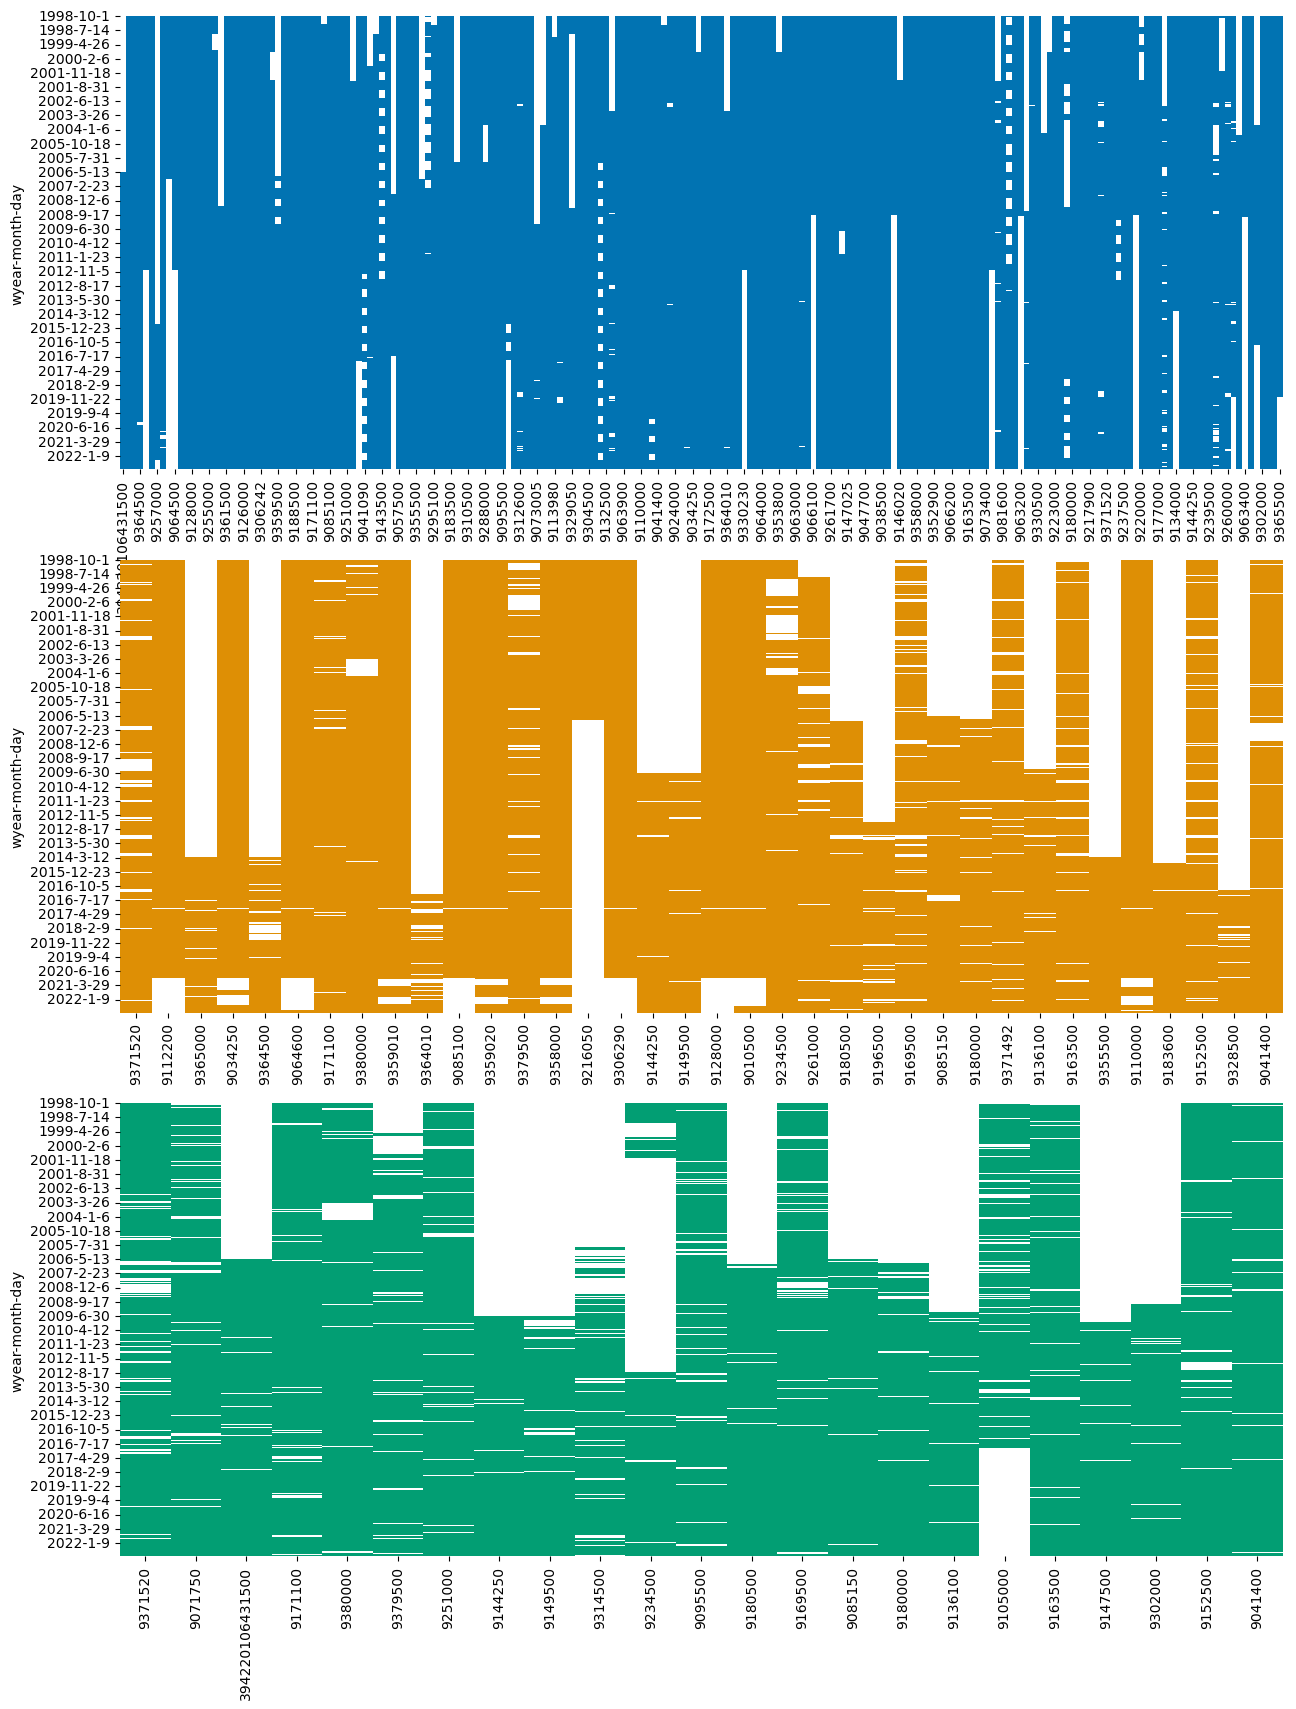

In [59]:
## DAILY data availability of the raw data for Q, WT, SC for 1998-2022
fig, ax = plt.subplots(3, 1, figsize=(15,20))#, sharey='all',sharex='all')
sns.heatmap(list_data_dfs[0][RDC_all3_allsites].loc[1998:2022].isnull(), cmap= mpl.colors.ListedColormap([episode_cmap[0],'white']),ax=ax[0],cbar=False)
sns.heatmap(list_data_dfs[1][WT_all3_allsites].loc[1998:2022].isnull(), cmap= mpl.colors.ListedColormap([episode_cmap[1],'white']),ax=ax[1],cbar=False)
sns.heatmap(list_data_dfs[2][SC_all3_allsites].loc[1998:2022].isnull(), cmap= mpl.colors.ListedColormap([episode_cmap[2],'white']),ax=ax[2],cbar=False)


<AxesSubplot:ylabel='wyear-month-day'>

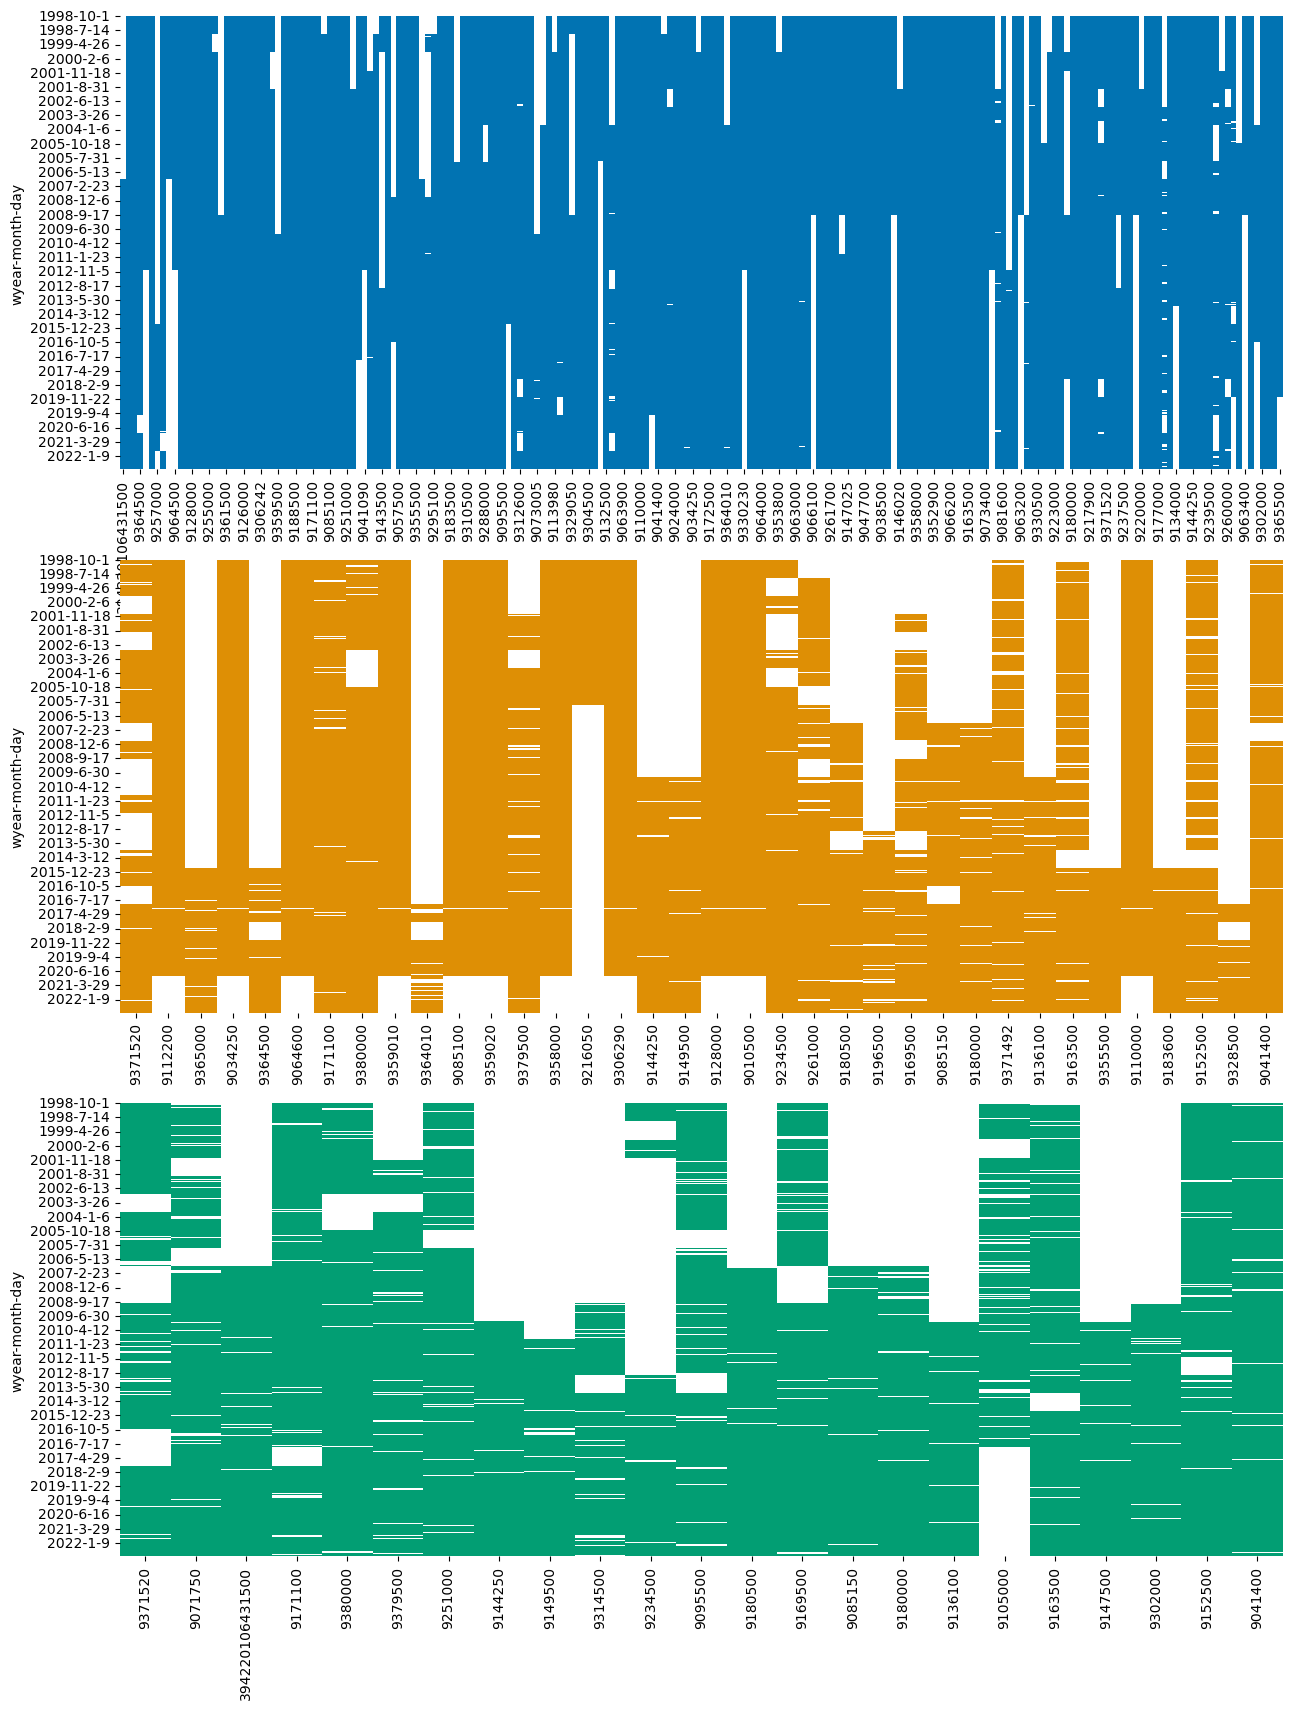

In [60]:
#### DAILY data availability after cleaning
fig, ax = plt.subplots(3, 1, figsize=(15,20))#, sharey='all',sharex='all')
sns.heatmap(RDC_ready[RDC_all3_allsites].loc[1998:2022].isnull(), cmap= mpl.colors.ListedColormap([episode_cmap[0],'white']),ax=ax[0],cbar=False)
sns.heatmap(WT_ready[WT_all3_allsites].loc[1998:2022].isnull(), cmap= mpl.colors.ListedColormap([episode_cmap[1],'white']),ax=ax[1],cbar=False)
sns.heatmap(SC_ready[SC_all3_allsites].loc[1998:2022].isnull(), cmap= mpl.colors.ListedColormap([episode_cmap[2],'white']),ax=ax[2],cbar=False)


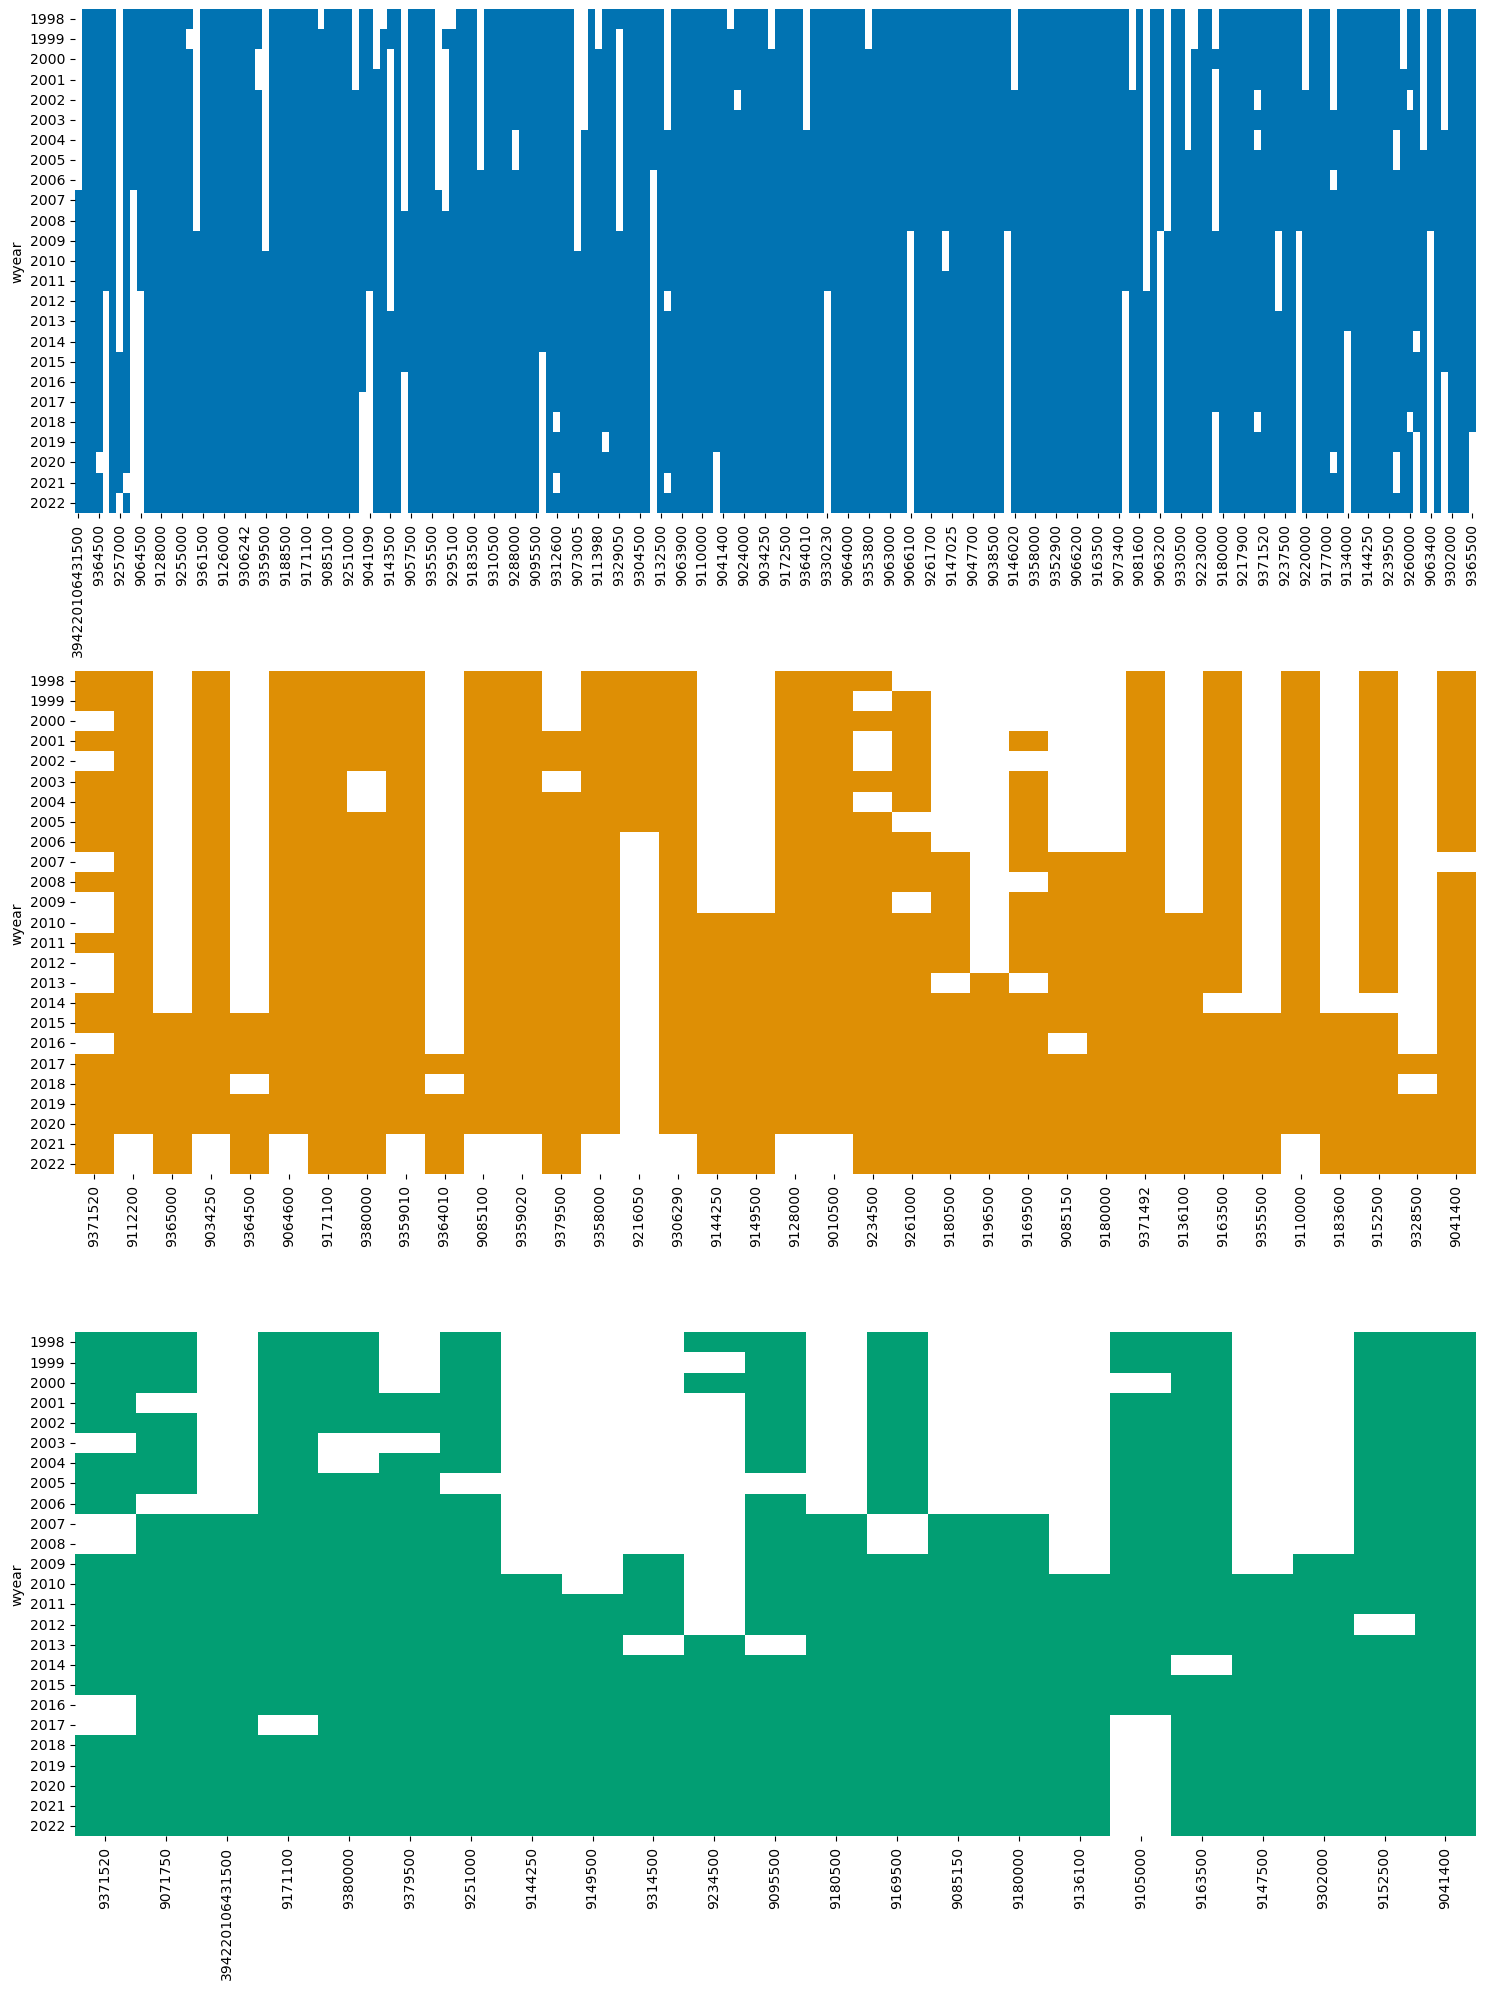

In [61]:
## ANNUAL data availability after all data criteria /cleaning

fig, ax = plt.subplots(3, 1, figsize=(15,20))#, sharey='all',sharex='all')
sns.heatmap(RDC_avail_df[RDC_all3_allsites].loc[1998:2022], cmap= mpl.colors.ListedColormap(['white',episode_cmap[0]]),ax=ax[0],cbar=False)
sns.heatmap(WT_avail_df[WT_all3_allsites].loc[1998:2022], cmap= mpl.colors.ListedColormap(['white',episode_cmap[1]]),ax=ax[1],cbar=False)
sns.heatmap(SC_avail_df[SC_all3_allsites].loc[1998:2022], cmap= mpl.colors.ListedColormap(['white',episode_cmap[2]]),ax=ax[2],cbar=False)

fig.tight_layout()
plt.savefig(fig_dir +'dataavailability.jpeg',dpi=300)

plt.show()

#### Distribution of Monthly Values and Relative Change

In [62]:
print('SC neg rel change, ann median 1998-2022: ', SC_years[sites_negSC].median().median())
print('SC pos rel change, ann median 1998-2022: ',SC_years[sites_posSC].median().median())

SC neg rel change, ann median 1998-2022:  729.6356164383561
SC pos rel change, ann median 1998-2022:  862.3954178537512


In [63]:
print('SC neg rel change, ann median 1998-2022: ', SC_years[sites_negSC].median().mean())
print('SC pos rel change, ann median 1998-2022: ',SC_years[sites_posSC].median().mean())

SC neg rel change, ann median 1998-2022:  1171.0366192847398
SC pos rel change, ann median 1998-2022:  919.44623597441


In [64]:
print('WT neg rel change, ann median 1998-2022: ', WT_years[sites_negWT].median().median())
print('WT pos rel change, ann median 1998-2022: ',WT_years[sites_posWT].median().median())

WT neg rel change, ann median 1998-2022:  10.146857142857144
WT pos rel change, ann median 1998-2022:  9.237535816618912


In [65]:
print('RDC neg rel change, ann median 1998-2022: ',RDC_years[sites_negRDC].median().median())
print('RDC pos rel change, ann median 1998-2022: ',RDC_years[sites_posRDC].median().median())

RDC neg rel change, ann median 1998-2022:  0.006590424318688339
RDC pos rel change, ann median 1998-2022:  0.0018986636644286524


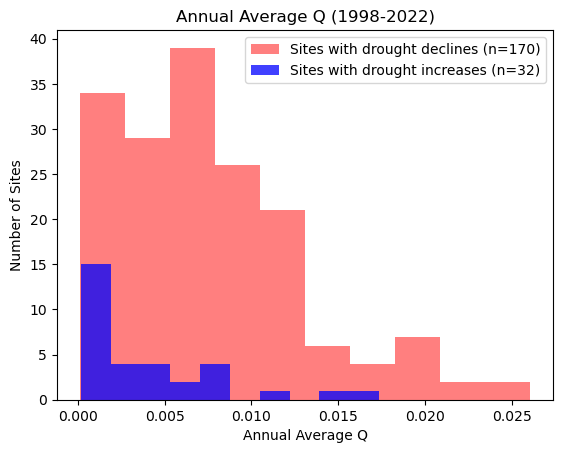

In [66]:
#RDC_years[sites_posQ].mean().hist()
plt.hist(RDC_years[sites_negRDC].mean(), bins=10, alpha=0.5, label='Sites with drought declines (n=170)', color='red')
plt.hist(RDC_years[sites_posRDC].mean(), bins=10, alpha=0.75, label='Sites with drought increases (n=32)', color='blue')

plt.xlabel('Annual Average Q')
plt.ylabel('Number of Sites')
plt.title('Annual Average Q (1998-2022)')
plt.legend()
plt.savefig(fig_dir +'Q_pos_neg_flowdifferences_dist.jpeg',dpi=300)
plt.show()

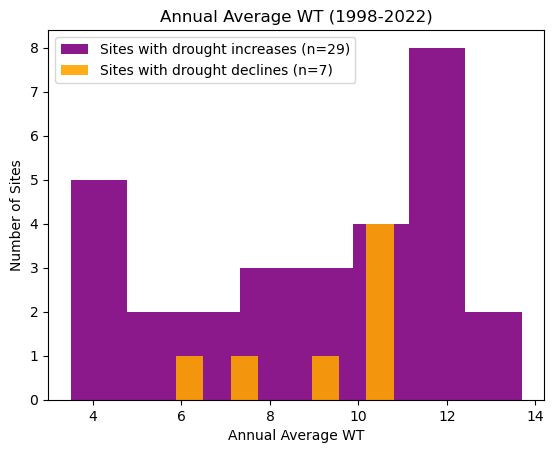

In [67]:
#RDC_years[sites_posQ].mean().hist()
plt.hist(WT_years[sites_posWT].mean(), bins=8, alpha=0.9, label='Sites with drought increases (n=29)', color='purple')
plt.hist(WT_years[sites_negWT].mean(), bins=8, alpha=0.9, label='Sites with drought declines (n=7)', color='orange')

plt.xlabel('Annual Average WT')
plt.ylabel('Number of Sites')
plt.title('Annual Average WT (1998-2022)')
plt.legend()
plt.savefig(fig_dir +'WT_pos_neg_flowdifferences_dist.jpeg',dpi=300)
plt.show()

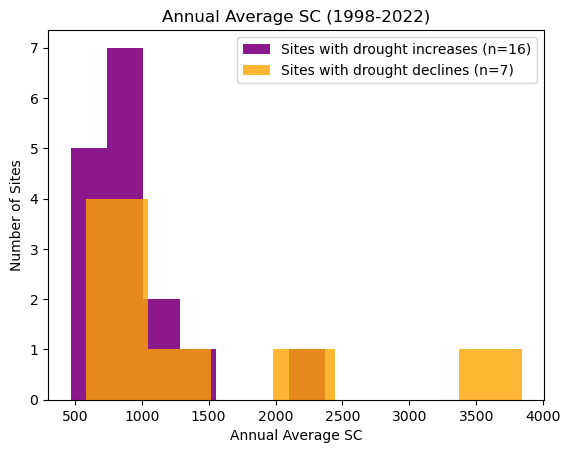

In [68]:
#RDC_years[sites_posQ].mean().hist()
plt.hist(SC_years[sites_posSC].mean(), bins=7, alpha=0.9, label='Sites with drought increases (n=16)', color='purple')
plt.hist(SC_years[sites_negSC].mean(), bins=7, alpha=0.8, label='Sites with drought declines (n=7)', color='orange')

plt.xlabel('Annual Average SC')
plt.ylabel('Number of Sites')
plt.title('Annual Average SC (1998-2022)')
plt.legend()
plt.savefig(fig_dir +'SC_pos_neg_flowdifferences_dist.jpeg',dpi=300)
plt.show()

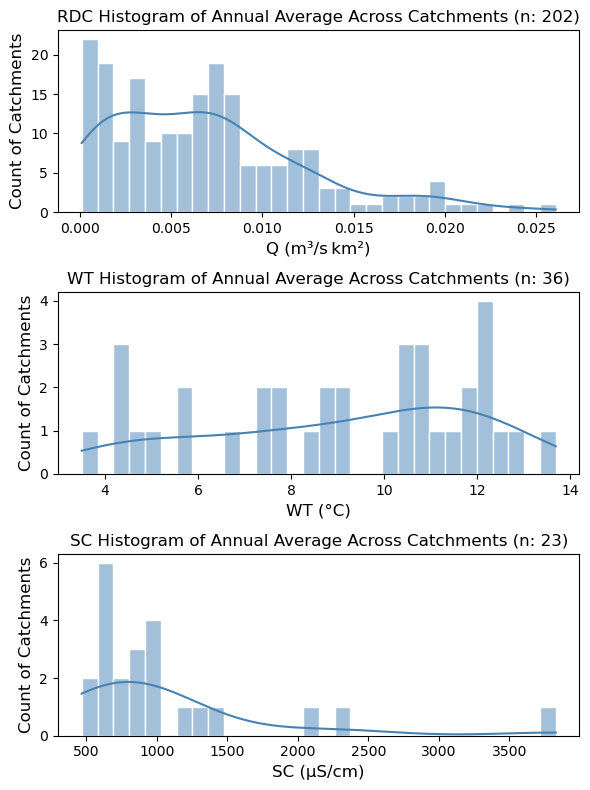

In [69]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,8))
for i, ax in enumerate(axs):
    var2_plot = var_names[i]
    
    if var2_plot == var_names[0]:
        var_plot_name = 'Q (m³/s km²)'
    elif var2_plot == var_names[1]:
        var_plot_name = 'WT (°C)'
    else:
        var_plot_name = 'SC (μS/cm)'

    data = vars()[f"{var2_plot}_avg_vals"]

    # seaborn will do histogram + KDE on one call
    sns.histplot(
        data,
        bins=30,
        color="steelblue",
        edgecolor="w",
        kde=True,
        stat="count",    # keep the y‐axis in “counts”
        ax=ax
    )
    
    ax.set_xlabel(var_plot_name, fontsize=12)
    ax.set_ylabel("Count of Catchments", fontsize=12)
    ax.set_title(
        f"{var2_plot} Histogram of Annual Average Across Catchments (n: {len(data)})",
        fontsize=12
    )

fig.tight_layout()
plt.savefig(fig_dir +var+'_ALL_dr_ep_avgvalue_dist.jpeg',dpi=300)
plt.show()

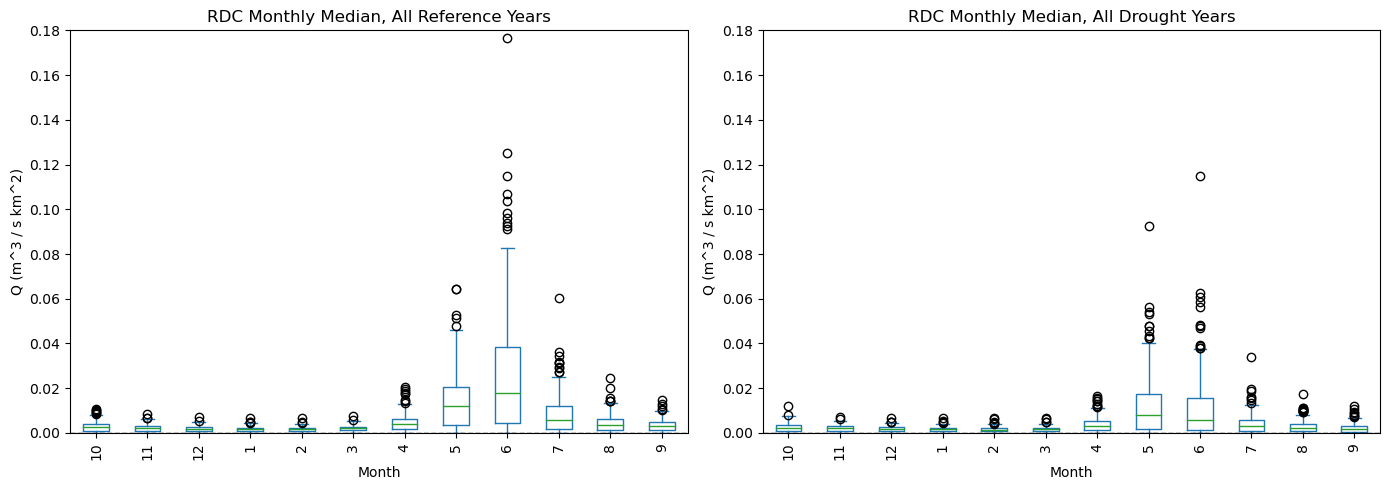

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes = axes.flatten()
var = 'RDC' # <- change and run again to save plots for the other variables
#years = ['2001_2002', '2012','2018', '2020_2021']
drtype = ['ref','dr']
bottom = 0
top = 0.18
for ax, ty in zip(axes, drtype ):
    # pandas boxplot: boxes = per‐column (i.e. per‐site) distribution over the 12 months
    vars()[str(var)+'_'+ty+'_monthlymed'].transpose().plot(kind='box', ax=ax)

    if ty == 'ref':
        title = 'All Reference Years'
    if ty == 'dr':
        title = 'All Drought Years'
    if var == var_names[0]:
        var_plot_name = 'Q (m^3 / s km^2)'
    if var == var_names[1]:
        var_plot_name = 'WT (°C)'
    if var == var_names[2]:
        var_plot_name = 'SC (uS/cm)'
    ax.set_title(f'{var} Monthly Median, {title}')
    ax.set_xlabel('Month')
    ax.set_ylabel(f'{var_plot_name}')
    ax.tick_params(axis='x', rotation=90)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_ylim(bottom, top)

fig.tight_layout()
#plt.savefig(fig_dir +var+'_ALL_dr_ep_value_dist.jpeg',dpi=300)
plt.show()

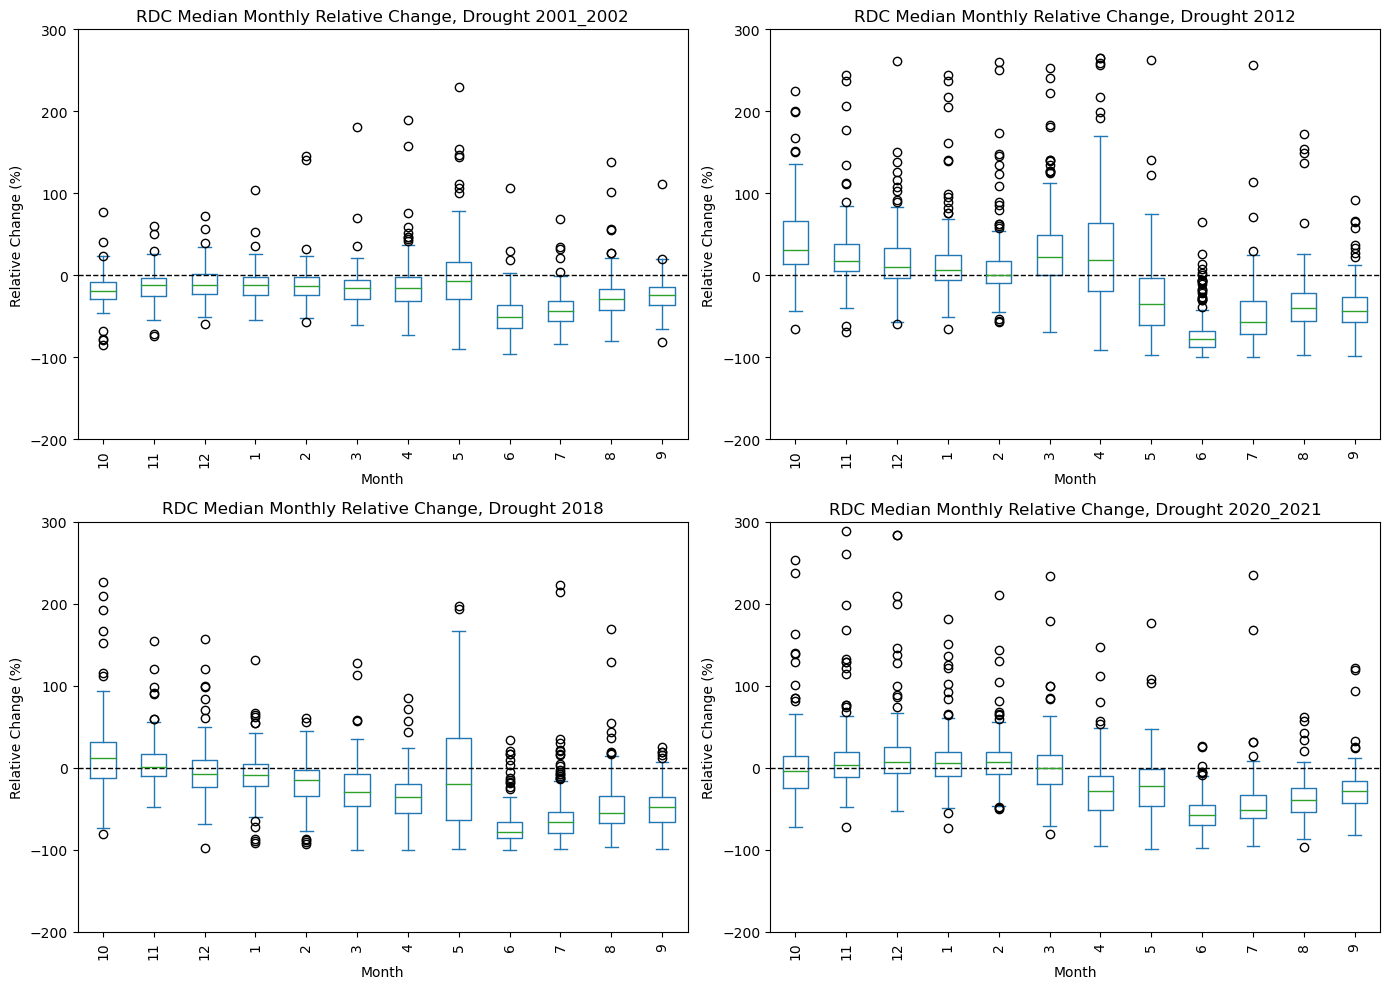

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
var = 'RDC' # <- change and run again to save plots for the other variables
years = ['2001_2002', '2012','2018', '2020_2021']
bottom=-200
top=300

for ax, yr in zip(axes, years):
    # pandas boxplot: boxes = per‐column (i.e. per‐site) distribution over the 12 months
    vars()[var+'_mon_MEDrelchange_'+yr].transpose().plot(kind='box', ax=ax)
    
    ax.set_title(f'{var} Median Monthly Relative Change, Drought {yr}')
    #ax.set_title(f'Q Median Monthly Relative Change, Drought {yr}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Relative Change (%)')
    ax.tick_params(axis='x', rotation=90)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_ylim(bottom, top)

fig.tight_layout()
plt.savefig(fig_dir +var+'_ALL_dr_ep_relchange_dist.jpeg',dpi=300)
plt.show()

In [72]:
## How many sites are cut off by setting y-axis viewing limits:
for var in var_names:
    for yr in years:
        mask = vars()[var+'_mon_MEDrelchange_'+yr] > 300
        sites_over = mask.apply(lambda row: row.index[row].tolist(), axis=1)
        for mon in vars()[var+'_mon_MEDrelchange_2012'].index:
            if len(sites_over[mon]) !=0:
                print(var, 'Month '+str(mon), yr, 'Sites over 300%:', len(sites_over[mon]))

        mask = vars()[var+'_mon_MEDrelchange_'+yr] < -200
        sites_under = mask.apply(lambda row: row.index[row].tolist(), axis=1)
        for mon in vars()[var+'_mon_MEDrelchange_2012'].index:
            if len(sites_under[mon]) !=0:
                print(var, 'Month '+str(mon), yr, 'Sites under -200%:', len(sites_under[mon]))


RDC Month 10 2012 Sites over 300%: 8
RDC Month 11 2012 Sites over 300%: 8
RDC Month 12 2012 Sites over 300%: 8
RDC Month 1 2012 Sites over 300%: 5
RDC Month 2 2012 Sites over 300%: 2
RDC Month 3 2012 Sites over 300%: 2
RDC Month 4 2012 Sites over 300%: 2
RDC Month 5 2012 Sites over 300%: 1
RDC Month 7 2012 Sites over 300%: 2
RDC Month 8 2012 Sites over 300%: 1
RDC Month 9 2012 Sites over 300%: 1
RDC Month 4 2018 Sites over 300%: 1
RDC Month 5 2018 Sites over 300%: 1
RDC Month 10 2020_2021 Sites over 300%: 1
RDC Month 11 2020_2021 Sites over 300%: 1
RDC Month 12 2020_2021 Sites over 300%: 1
RDC Month 1 2020_2021 Sites over 300%: 1
RDC Month 2 2020_2021 Sites over 300%: 1
RDC Month 3 2020_2021 Sites over 300%: 2
RDC Month 4 2020_2021 Sites over 300%: 1
RDC Month 8 2020_2021 Sites over 300%: 1
RDC Month 9 2020_2021 Sites over 300%: 1
WT Month 1 2012 Sites over 300%: 1
WT Month 12 2018 Sites over 300%: 1
WT Month 12 2020_2021 Sites over 300%: 2
WT Month 1 2020_2021 Sites under -200%: 1
SC 

#### SPEI

In [73]:
# we are using the list of Q sites so that it is relevant to our later work
# have to pair the list of Q sites with the list of sites in gages
print('Number of Q sites that have gages information: ',len(list(set(RDC_all3_allsites) & set(gagesii_int.index))))

Number of Q sites that have gages information:  202


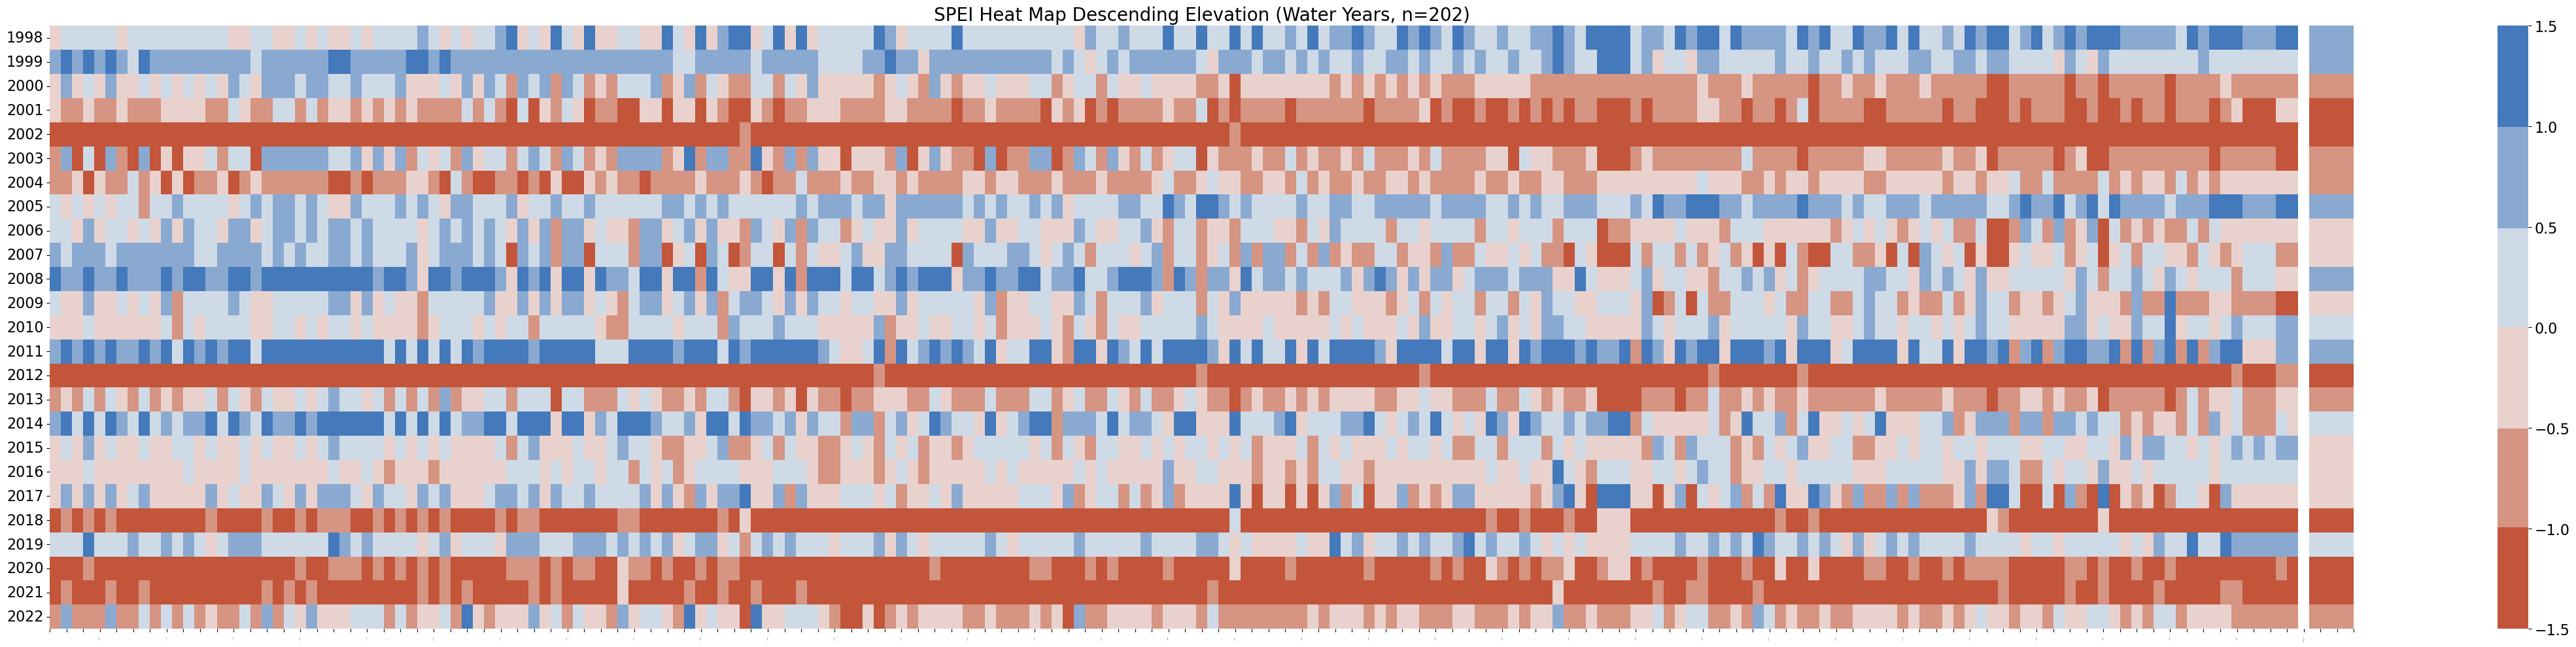

SPEI and elevation dataframe saved: /Users/emilynagamoto/PycharmProjects/drought-impacts-updates/UCRB-drought/OUTPUTS/Figures/spei_ann_wyElevation.csv


In [74]:
#preprocessing.plotting_spei(ann_spei, gagesii_int, RDC_all3_allsites, figure_dir=None,OPTION=False)
TRUN_ann_spei_wyears.columns = TRUN_ann_spei_wyears.columns.map(str)
calculations.plotting_spei(TRUN_ann_spei_wyears, gagesii_int, list(set(RDC_all3_allsites) & set(gagesii_int.index)),spei_cmap,fig_dir,True)

#### Compare Drought and Reference Values by Site

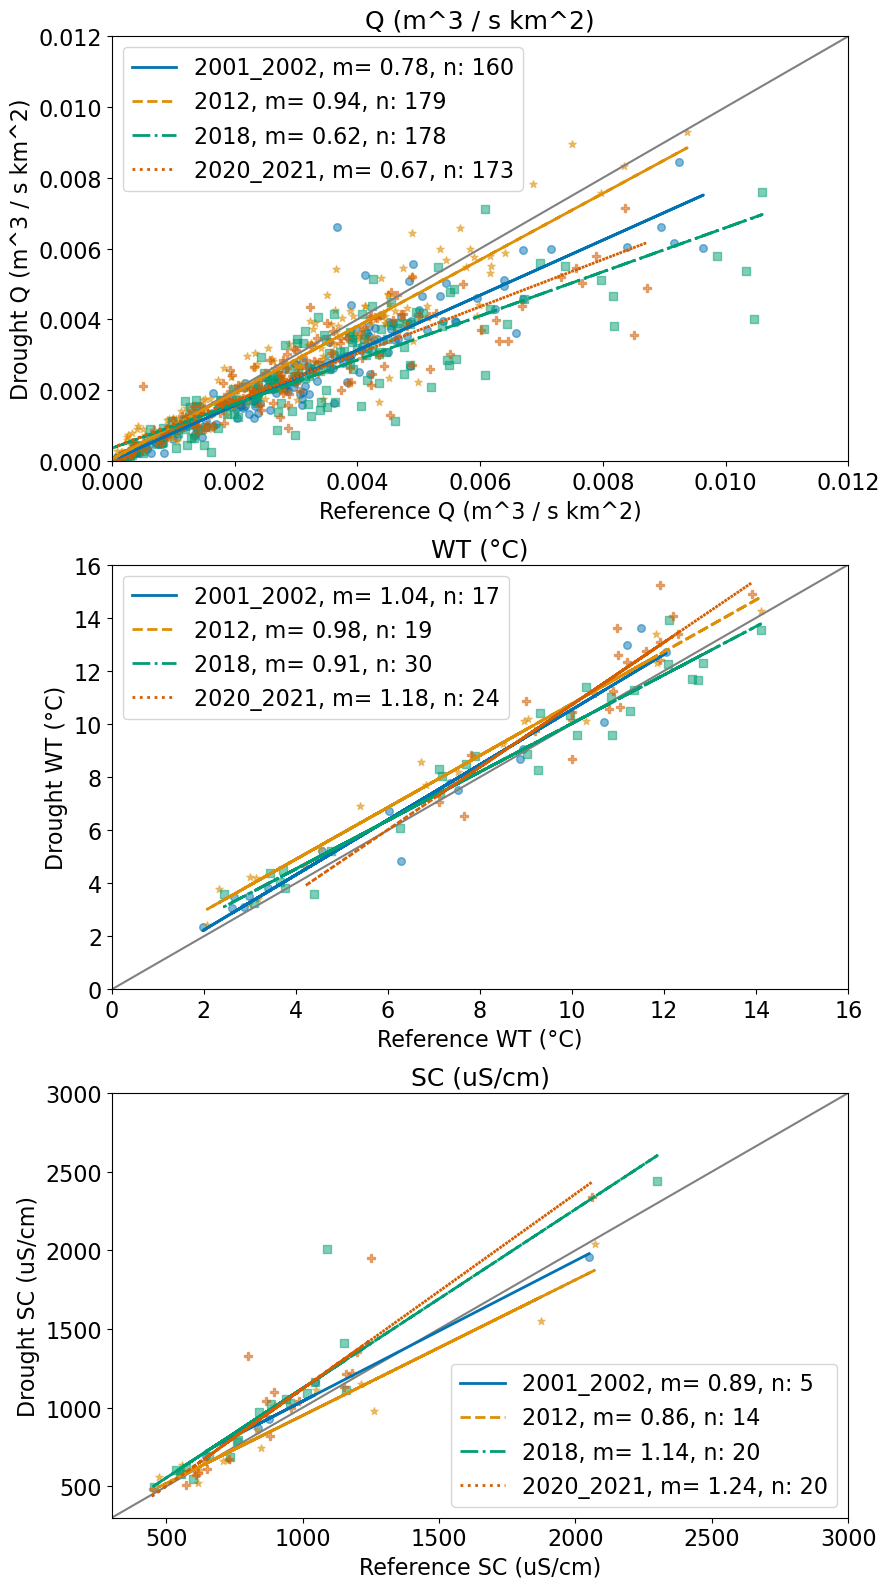

In [75]:
## SCATTERPLOT: ANN, Episode 
fig,axs = plt.subplots(nrows=3, ncols=1,figsize=(9,16))
for i,ax in enumerate(axs):
    var2_plot = var_names[i]
    ind_names = dr_names
    fsize=18
    fontsize2=fsize-2

    if var2_plot == var_names[0]:
        var_plot_name = 'Q (m^3 / s km^2)'
        ax.axline(xy1=(0,0), xy2=None, slope=1,color='gray', linestyle='-')
        ax.set_ylim(bottom=0,top=0.012)
        ax.set_xlim(left=0,right=0.012)
    if var2_plot == var_names[1]:
        var_plot_name = 'WT (°C)'
        ax.axline(xy1=(4,4), xy2=None, slope=1,color='gray', linestyle='-')
        ax.set_ylim(bottom=0,top=16)
        ax.set_xlim(left=0,right=16)
    if var2_plot == var_names[2]:
        var_plot_name = 'SC (uS/cm)'
        ax.axline(xy1=(400,400), xy2=None, slope=1,color='gray', linestyle='-')
        ax.set_ylim(bottom=300,top=3000)
        ax.set_xlim(left=300,right=3000)

    ax.set_ylabel('Drought '+var_plot_name,fontsize=fontsize2)
    ax.set_xlabel('Reference '+var_plot_name,fontsize=fontsize2)
    ax.tick_params(axis='y')
    
    num=0
    for dr in ind_names:
        var_drought = vars()[str(var2_plot)+'_ann_MEDdrought_'+dr]
        var_reference = vars()[str(var2_plot)+'_ann_MEDref_'+dr]
        #vars()[var+'_ann_MEDdrought_'+dr], vars()[var+'_ann_MEDref_'+dr]
        #res =  [abs(ele) for ele in y]                                 # THE REL CHANGE IS ABSOLUTE VALUE
        ax.scatter(x=var_reference, y=var_drought,color=episode_cmap[num],s=30,alpha=0.5, marker=episode_markers[num],)
    
        #calculate equation for trendline
        a,b = np.polyfit(x=var_reference, y=var_drought,deg=1)
        z = np.polyfit(x=var_reference, y=var_drought,deg=1)
        p = np.poly1d(z)
        #add trendline to plot
        ax.plot(var_reference, p(var_reference),color=episode_cmap[num],linestyle=episode_linestyles[num],
                linewidth=2,label=dr+', m= {:.2f}'.format(a)+', n: '+str(len(var_drought)))

        num+=1

    for label in (ax.get_yticklabels()):
        label.set_fontsize(fontsize2)
    
    for label in (ax.get_xticklabels()):
        label.set_fontsize(fontsize2)


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(var_plot_name, fontsize=fsize)
    #ax.legend(handles=[rects3, rects4,plot],prop={"size":16})
    ax.legend(loc='best',prop={"size":fontsize2})

fig.tight_layout()
plt.savefig(fig_dir +'ALL3_dr_ep_scatter_GAP.jpeg',dpi=300)

plt.show()

#### Monthly Relative Change, avg of all sites

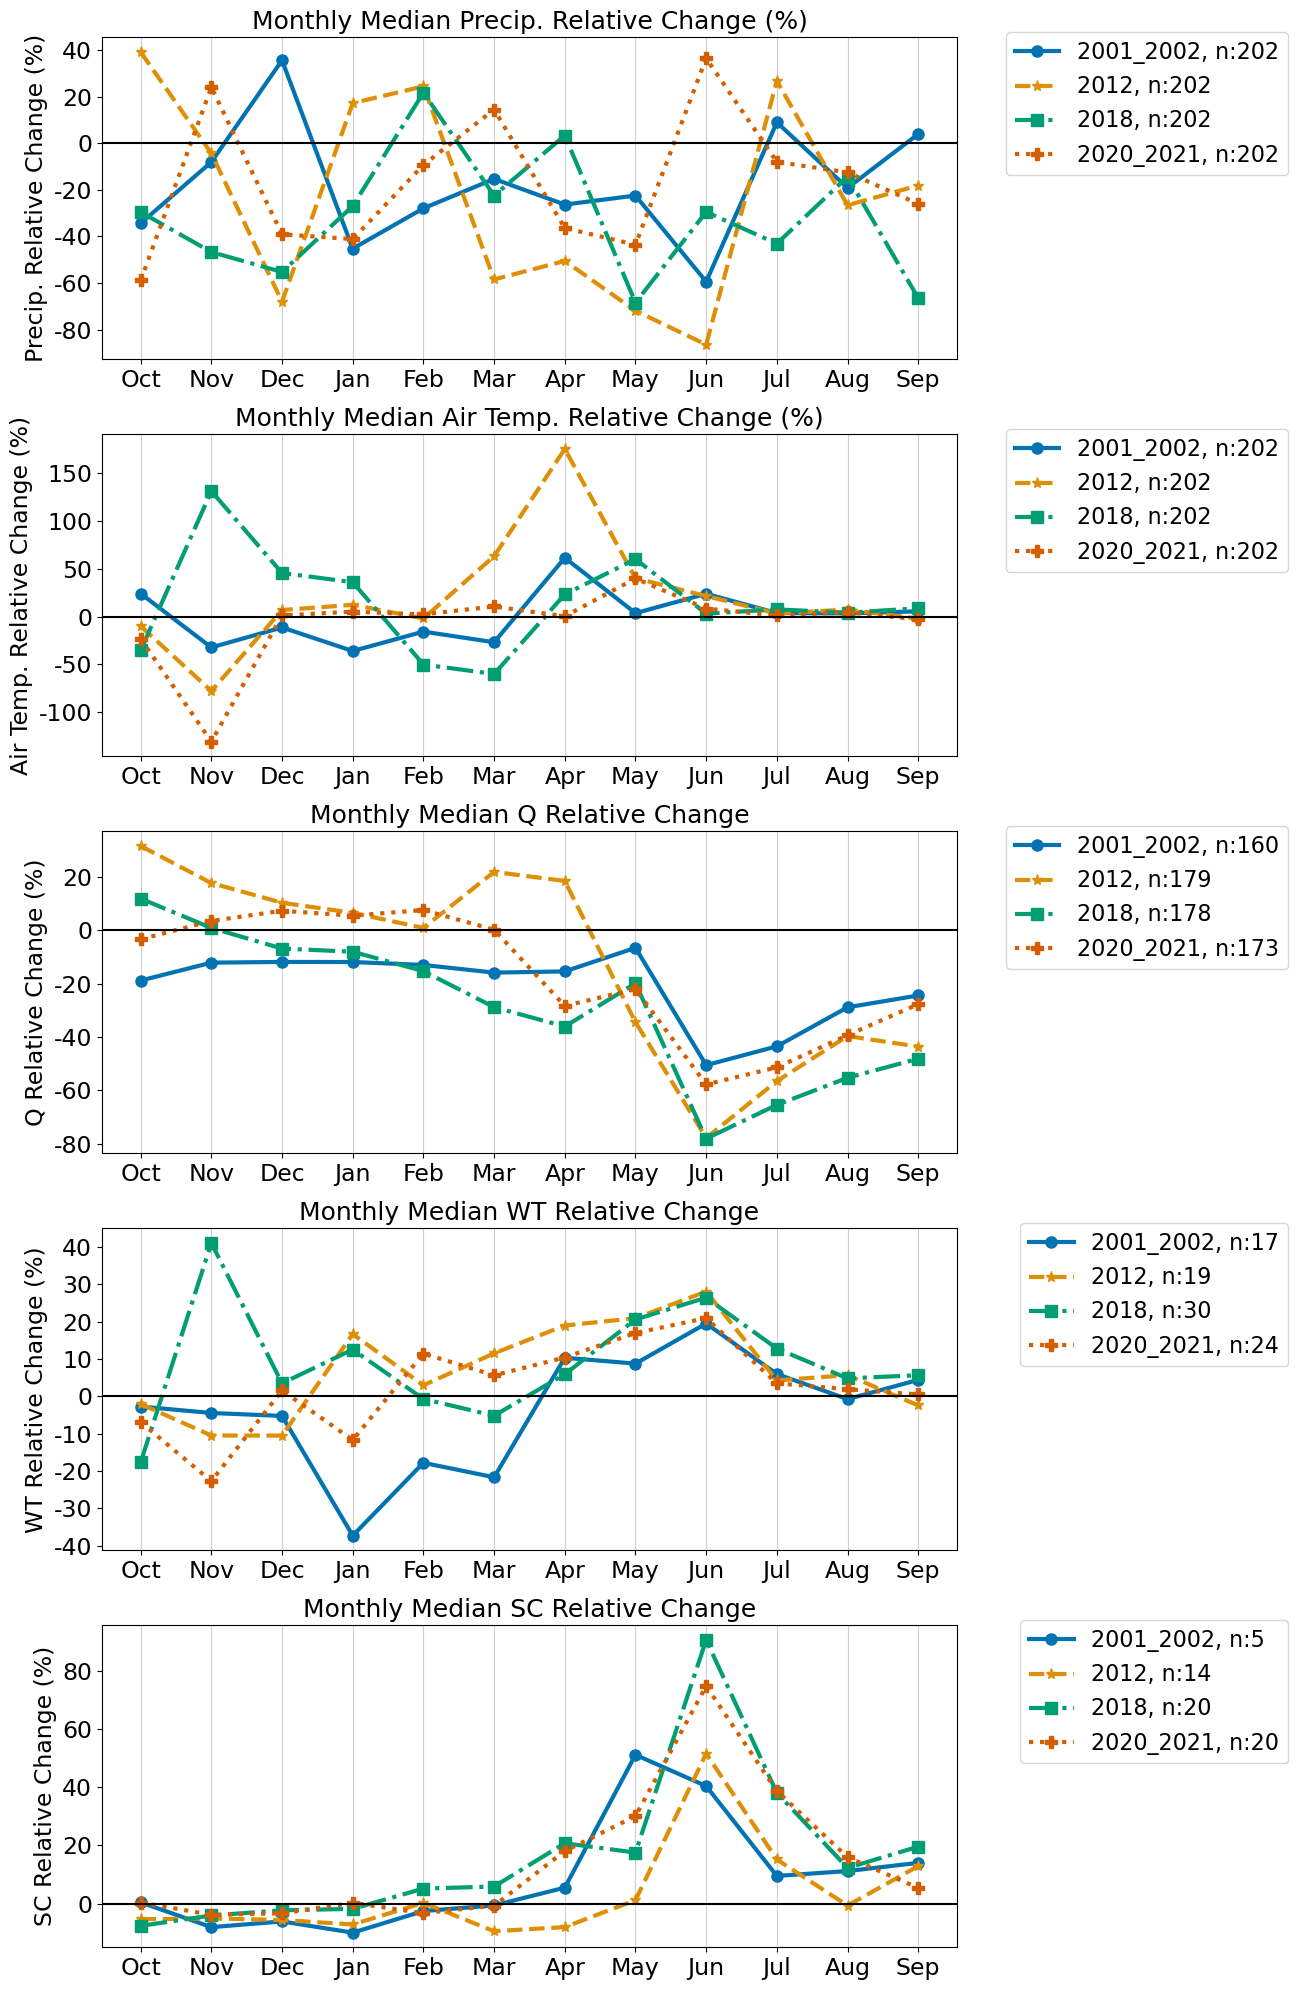

In [76]:
## PLOT: Monthly Rel.Change, VARS+MET, Episodes
with_precip_temp = True
if with_precip_temp:
    figsize=(14,20)
    fig,axs = plt.subplots(nrows=5, ncols=1,figsize=figsize)#,sharex=True)
else:
    figsize=(14,10)
    fig,axs = plt.subplots(nrows=5, ncols=1,figsize=figsize)#,sharex=True)
    
fontsize=16
for i,ax in enumerate(axs):
    if i == 2 or i == 3 or i == 4:    
        var2_plot = var_names[i-2]
        if var2_plot == var_names[0]:
            var_plot_name = 'Q'
        if var2_plot == var_names[1]:
            var_plot_name = 'WT'
        if var2_plot == var_names[2]:
            var_plot_name = 'SC'

        ax.set_ylabel(var_plot_name+' Relative Change (%)', fontsize=fontsize+1)
        ax.set_title('Monthly Median '+var_plot_name+' Relative Change', fontsize=fontsize+2)

        handles = []
        for dr in ['2001_2002', '2012','2018', '2020_2021']:

            vars()['line1_'+dr], = ax.plot(wmon_names,vars()[var2_plot+'_mon_MEDrelchange_'+dr].median(axis=1),color=dr_colors[dr],
                                           label=dr+', n:'+str(len(vars()[var2_plot+'_mon_MEDrelchange_'+dr].columns)), 
                                           markersize=8, marker=dr_markerstyles[dr], linestyle=dr_linestyles[dr], linewidth=3)
            handles.append(vars()['line1_'+dr])
    
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize+1)

        ax.axhline(y=0.0, color='black', linestyle='-')
        ax.grid(axis='x',alpha=0.6)
        #ax.legend(handles=handles,loc='best', prop={"size":fontsize})
        ax.legend(bbox_to_anchor=(1.4, 1.05),handles=handles,loc='upper right', prop={"size":fontsize})
       
    if i == 0 or i ==1:
        met2plot = MET_vars[i]
        if met2plot == MET_vars[0]:
            met_plot_name = 'Precip.'
        if met2plot == MET_vars[1]:
            met_plot_name = 'Air Temp.'
        ax.set_ylabel(f'{met_plot_name} Relative Change (%)', fontsize=fontsize+1)
        ax.set_title(f'Monthly Median {met_plot_name} Relative Change (%)', fontsize=fontsize+2)

        handles = []
        for dr in dr_names: 
            vars()['line1_'+dr], = ax.plot(wmon_names,vars()[met2plot+'_mon_MEDrelchange_'+dr].median(axis=1),color=dr_colors[dr],
                                           label=dr+', n:'+str(len(vars()[met2plot+'_mon_MEDrelchange_'+dr].columns)), 
                                           markersize=8, marker=dr_markerstyles[dr], linestyle=dr_linestyles[dr], linewidth=3)
            handles.append(vars()['line1_'+str(dr)])

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize+1)

        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
        ax.axhline(y=0.0, color='black', linestyle='-')
        #ax.legend(handles=handles,loc='best', prop={"size":fontsize})
        ax.legend(bbox_to_anchor=(1.4, 1.05),handles=handles,loc='upper right', prop={"size":fontsize})
        ax.grid(axis='x',alpha=0.6)

fig.tight_layout()

if with_precip_temp:
    plt.savefig(fig_dir+'ALL3seasonal_relchangeWY_PT.jpeg',dpi=300)
else:
    plt.savefig(fig_dir+'seasonal_relchangeWY_noPT.jpeg',dpi=300)

plt.show()

#### Monthly values, avg all sites

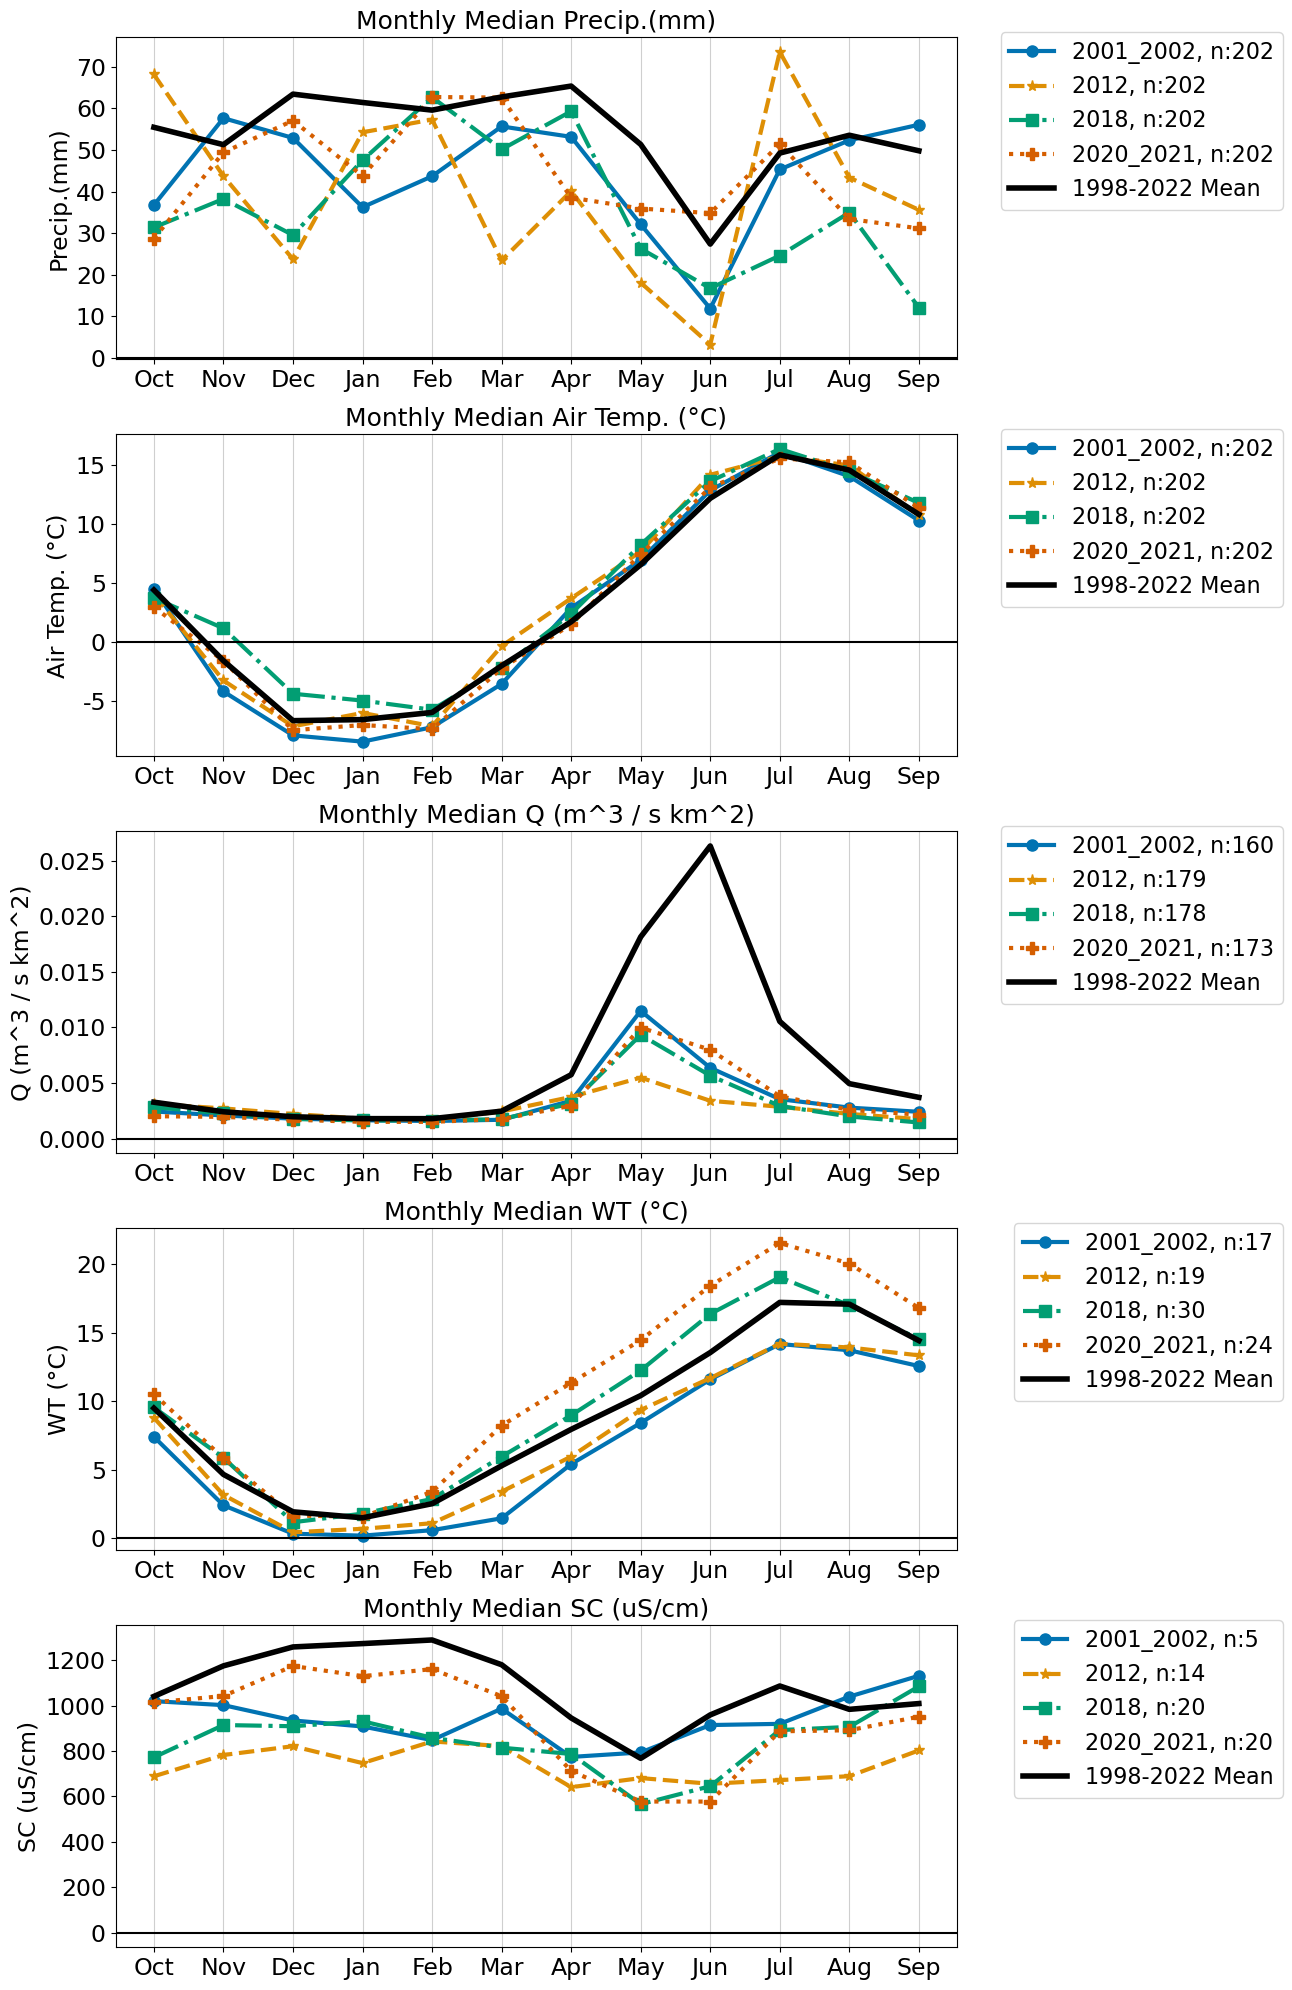

In [77]:
## PLOT: Monthly Actual values, VARS+MET, Episodes
with_precip_temp = True
if with_precip_temp:
    figsize=(14,20)
    fig,axs = plt.subplots(nrows=5, ncols=1,figsize=figsize)#,sharex=True)
else:
    figsize=(14,10)
    fig,axs = plt.subplots(nrows=5, ncols=1,figsize=figsize)#,sharex=True)
    
fontsize=16
for i,ax in enumerate(axs):
    if i == 2 or i == 3 or i == 4:    
        var2_plot = var_names[i-2]
        if var2_plot == var_names[0]:
            var_plot_name = 'Q (m^3 / s km^2)'
        if var2_plot == var_names[1]:
            var_plot_name = 'WT (°C)'
        if var2_plot == var_names[2]:
            var_plot_name = 'SC (uS/cm)'

        ax.set_ylabel(var_plot_name, fontsize=fontsize+1)
        ax.set_title('Monthly Median '+var_plot_name, fontsize=fontsize+2)

        handles = []
        for dr in ['2001_2002', '2012','2018', '2020_2021']: 
            # vars()[var+'_mon_MEDdrought_'+dr]    
            vars()['line1_'+dr], = ax.plot(wmon_names,vars()[var2_plot+'_mon_MEDdrought_'+dr].median(axis=1),color=dr_colors[dr],
                                           label=dr+', n:'+str(len(vars()[var2_plot+'_mon_MEDdrought_'+dr].columns)), 
                                           markersize=8, marker=dr_markerstyles[dr], linestyle=dr_linestyles[dr], linewidth=3)
            handles.append(vars()['line1_'+dr])

        mean_handle, = ax.plot(wmon_names,vars()[var2_plot+'_basin_avg_'+str(longterm_avg_start)+'_2022_all3'],label=str(longterm_avg_start)+'-2022 Mean',color='black',linewidth=4)
        handles.append(mean_handle)
        # ref_handle, = ax.plot(wmon_names,vars()[var2_plot+ '_all_ref_MEAN'],label='Reference year Mean',color='red',linewidth=4)
        # handles.append(ref_handle)
    
        #ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize+1)

        ax.axhline(y=0.0, color='black', linestyle='-')
        ax.grid(axis='x',alpha=0.6)
        #ax.legend(handles=handles,loc='best', prop={"size":fontsize})
        ax.legend(bbox_to_anchor=(1.4, 1.05),handles=handles,loc='upper right', prop={"size":fontsize})
        
    if i == 0 or i ==1:
        met2plot = MET_vars[i]
        if met2plot == MET_vars[0]:
            met_plot_name = 'Precip.(mm)'
        if met2plot == MET_vars[1]:
            met_plot_name = 'Air Temp. (°C)'
        ax.set_ylabel(met_plot_name, fontsize=fontsize+1)
        ax.set_title('Monthly Median '+met_plot_name, fontsize=fontsize+2)

        handles = []
        for dr in dr_names:
            vars()['line1_'+dr], = ax.plot(wmon_names,vars()[met2plot+'_mon_MEDdrought_'+str(dr)].median(axis=1),color=dr_colors[dr],
                                           label=dr+', n:'+str(len(vars()[met2plot+'_mon_MEDrelchange_'+dr].columns)), 
                                           markersize = 8, marker=dr_markerstyles[dr], linestyle=dr_linestyles[dr], linewidth=3)
            handles.append(vars()['line1_'+str(dr)])

        mean_handle, = ax.plot(wmon_names,vars()['basin_avg_'+met2plot+'_allyrs'],label=str(longterm_avg_start)+'-2022 Mean',color='black',linewidth=4)
        handles.append(mean_handle)
        # mean_handle2, = ax.plot(wmon_names,vars()[met2plot+'_basin_avg_'+str(longterm_avg_start)+'_2022_all3'],label='1972-2022 Mean',color='firebrick',linewidth=4)
        # handles.append(mean_handle2)

        # ref_handle, = ax.plot(wmon_names,precip_all_ref_MEAN,label='Reference year Mean',color='red',linewidth=4)
        # handles.append(ref_handle)

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize+1)

        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
        ax.axhline(y=0.0, color='black', linestyle='-')
        #ax.legend(handles=handles,loc='best', prop={"size":fontsize})
        ax.legend(bbox_to_anchor=(1.4, 1.05),handles=handles,loc='upper right', prop={"size":fontsize})
        ax.grid(axis='x',alpha=0.6)        

fig.tight_layout()

# if with_precip_temp:
#     plt.savefig(fig_dir+'ALL3seasonal_ABSOLUTEWY_PT.jpeg',dpi=300)
# else:
#     plt.savefig(fig_dir+'seasonal_ABSOLUTEWY_noPT.jpeg',dpi=300)

plt.show()

#### Map of Annual Avg Relative Change

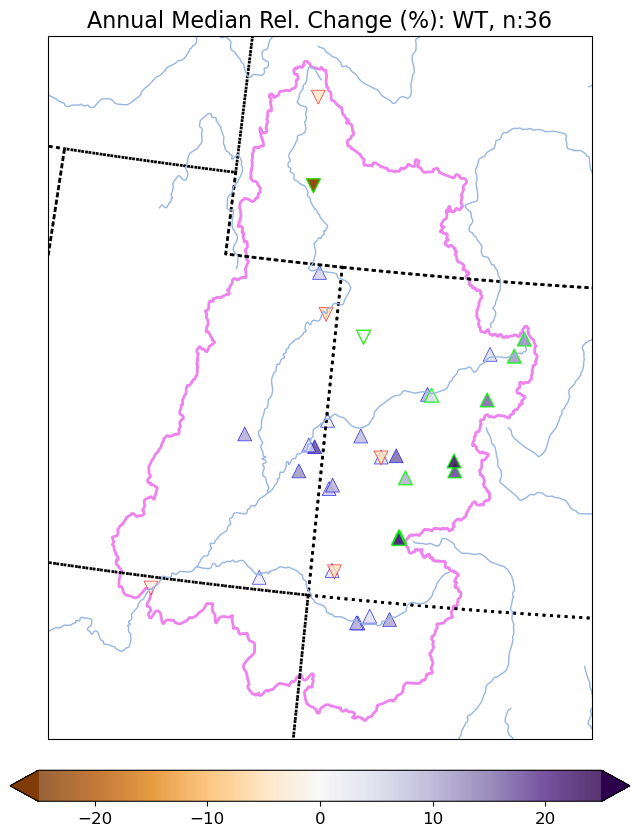

In [78]:
## MAP: Annual Rel.change, separated by VAR
# CHOOSE VARIABLE TO MAP
var = var_names[1]
figure = plt.figure(figsize=(8,10))
colorscheme ='PuOr' #'PuOr'for WT and SC # 'bwr_r' for Q

ax = figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5,central_longitude=-98.35))
ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'black', linewidth= 2)
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'black', linewidth= 2)

# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-113, -105, 35.5, 43.5],crs=crs.PlateCarree())
ax.add_feature(cfeature.RIVERS)

fname = upper_colorado_river_boundary_dir / 'Upper_Colorado_River_Basin_Boundary.shp'
shape_feature = ShapelyFeature(shpreader(fname).geometries(),crs.PlateCarree(), edgecolor='violet', facecolor='white',lw=2)
ax.add_feature(shape_feature,zorder=-1)        

data = vars()[var+'_MEDrelchange_map_all3']
#if var == var_names[0]:
#    data = RDC_MEDrelchange_map_noOutlier
if var == var_names[0]:
    vmax = 100
    vmin = -100
else:
    vmax = 25
    vmin = -25
d = data[(data['Relative Change (%)'] >= 0) & (data['CLASS']=='Non-Ref')]
if var == var_names[1]:
    data_NOpubs = vars()[var_names[1]+'_MEDrelchange_map_all3'].drop(PUBS_sites_all3,errors='ignore')
    d = data_NOpubs[(data_NOpubs['Relative Change (%)'] >= 0)] #& (data_NOpubs['CLASS']=='Non-Ref')
plot = plt.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                   marker= '^', edgecolors= (0, 0, 1, 0.1), #(0.5, 0, 0.5, 0.1), # edgecolors=(0.5, 0.5, 0.5, 1) edgecolors=(0, 0, 1, 0.1),
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

d = data[(data['Relative Change (%)'] < 0) ] # & (data['CLASS']=='Non-Ref')
plot = plt.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                   marker= 'v',edgecolors=(1, 0, 0, 0.1), #(1, 0.5, 0, 0.1), #edgecolors=(1, 0, 0, 0.1), 
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

if var == var_names[1]:
    valid_columns = vars()[var_names[1]+'_MEDrelchange_map_all3'].index.intersection(PUBS_sites_all3)
    data_pubs = vars()[var_names[1]+'_MEDrelchange_map_all3'].loc[valid_columns]
    d = data_pubs[(data_pubs['Relative Change (%)'] >= 0) ] # & (data_pubs['CLASS']=='Non-Ref')
    plot = plt.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                       marker= '^',edgecolors='lime',linewidth=1,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

    d = data_pubs[(data_pubs['Relative Change (%)'] < 0) ] # & (data_pubs['CLASS']=='Non-Ref')
    plot = plt.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                       marker= 'v',edgecolors='lime', linewidth=1,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

cbarplot = plt.scatter(x=data.LON, y=data.LAT, c=data['Relative Change (%)'],cmap = colorscheme,s= 0,alpha=0.8,
                       marker= '^',transform=crs.PlateCarree(),vmin = vmin, vmax = vmax)


cbar= plt.colorbar(cbarplot,fraction=0.046,pad=0.04, extend= 'both', orientation= 'horizontal')
cbar.ax.tick_params(labelsize=12)

if var == var_names[0]:
    var = 'Q'
ax.set_title('Annual Median Rel. Change (%): '+var+', n:'+str(len(data.index)),fontsize=16)   

plt.savefig(fig_dir+'/'+var+'_locations_purple_ALL3.jpeg',format='jpeg',dpi=300)
plt.show()

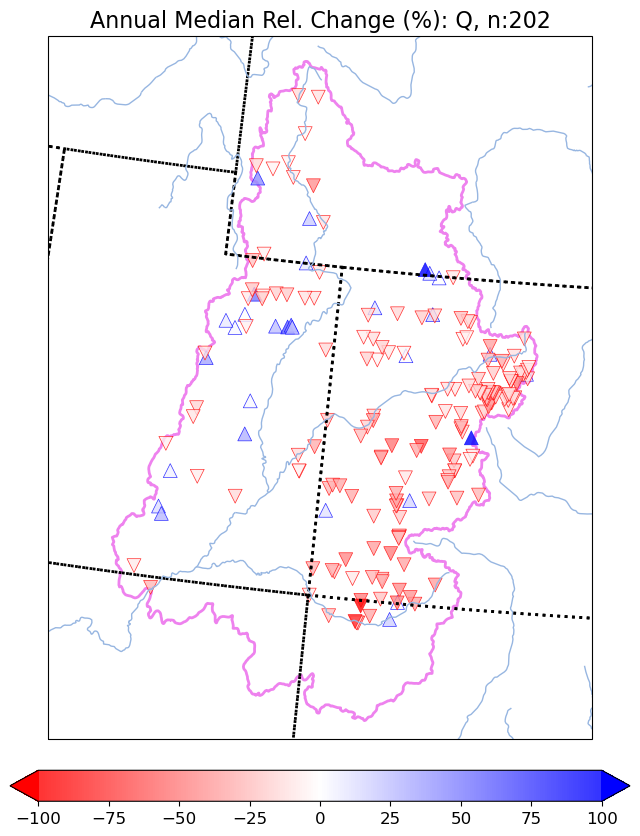

In [79]:
## MAP: Annual Rel.change, separated by VAR
# CHOOSE VARIABLE TO MAP
var = var_names[0]
figure = plt.figure(figsize=(8,10))
colorscheme ='bwr_r' #'PuOr'for WT and SC # 'bwr_r' for Q

ax = figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5,central_longitude=-98.35))
ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'black', linewidth= 2)
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'black', linewidth= 2)

# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-113, -105, 35.5, 43.5],crs=crs.PlateCarree())
ax.add_feature(cfeature.RIVERS)

fname = upper_colorado_river_boundary_dir / 'Upper_Colorado_River_Basin_Boundary.shp'
shape_feature = ShapelyFeature(shpreader(fname).geometries(),crs.PlateCarree(), edgecolor='violet', facecolor='white',lw=2)
ax.add_feature(shape_feature,zorder=-1)        

data = vars()[var+'_MEDrelchange_map_all3']
#if var == var_names[0]:
#    data = RDC_MEDrelchange_map_noOutlier
if var == var_names[0]:
    vmax = 100
    vmin = -100
else:
    vmax = 25
    vmin = -25
d = data[(data['Relative Change (%)'] >= 0) & (data['CLASS']=='Non-Ref')]
if var == var_names[1]:
    data_NOpubs = vars()[var_names[1]+'_MEDrelchange_map_all3'].drop(PUBS_sites_all3,errors='ignore')
    d = data_NOpubs[(data_NOpubs['Relative Change (%)'] >= 0)] #& (data_NOpubs['CLASS']=='Non-Ref')
plot = plt.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                   marker= '^', edgecolors= (0, 0, 1, 0.1), #(0.5, 0, 0.5, 0.1), # edgecolors=(0.5, 0.5, 0.5, 1) edgecolors=(0, 0, 1, 0.1),
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

d = data[(data['Relative Change (%)'] < 0) ] # & (data['CLASS']=='Non-Ref')
plot = plt.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                   marker= 'v',edgecolors=(1, 0, 0, 0.1), #(1, 0.5, 0, 0.1), #edgecolors=(1, 0, 0, 0.1), 
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

if var == var_names[1]:
    valid_columns = vars()[var_names[1]+'_MEDrelchange_map_all3'].index.intersection(PUBS_sites_all3)
    data_pubs = vars()[var_names[1]+'_MEDrelchange_map_all3'].loc[valid_columns]
    d = data_pubs[(data_pubs['Relative Change (%)'] >= 0) ] # & (data_pubs['CLASS']=='Non-Ref')
    plot = plt.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                       marker= '^',edgecolors='lime',linewidth=1,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

    d = data_pubs[(data_pubs['Relative Change (%)'] < 0) ] # & (data_pubs['CLASS']=='Non-Ref')
    plot = plt.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                       marker= 'v',edgecolors='lime', linewidth=1,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

cbarplot = plt.scatter(x=data.LON, y=data.LAT, c=data['Relative Change (%)'],cmap = colorscheme,s= 0,alpha=0.8,
                       marker= '^',transform=crs.PlateCarree(),vmin = vmin, vmax = vmax)


cbar= plt.colorbar(cbarplot,fraction=0.046,pad=0.04, extend= 'both', orientation= 'horizontal')
cbar.ax.tick_params(labelsize=12)

if var == var_names[0]:
    var = 'Q'
ax.set_title('Annual Median Rel. Change (%): '+var+', n:'+str(len(data.index)),fontsize=16)   

plt.savefig(fig_dir+var+'_locations_purple_ALL3.jpeg',format='jpeg',dpi=300)
plt.show()

#### Mapping 95th and 5th

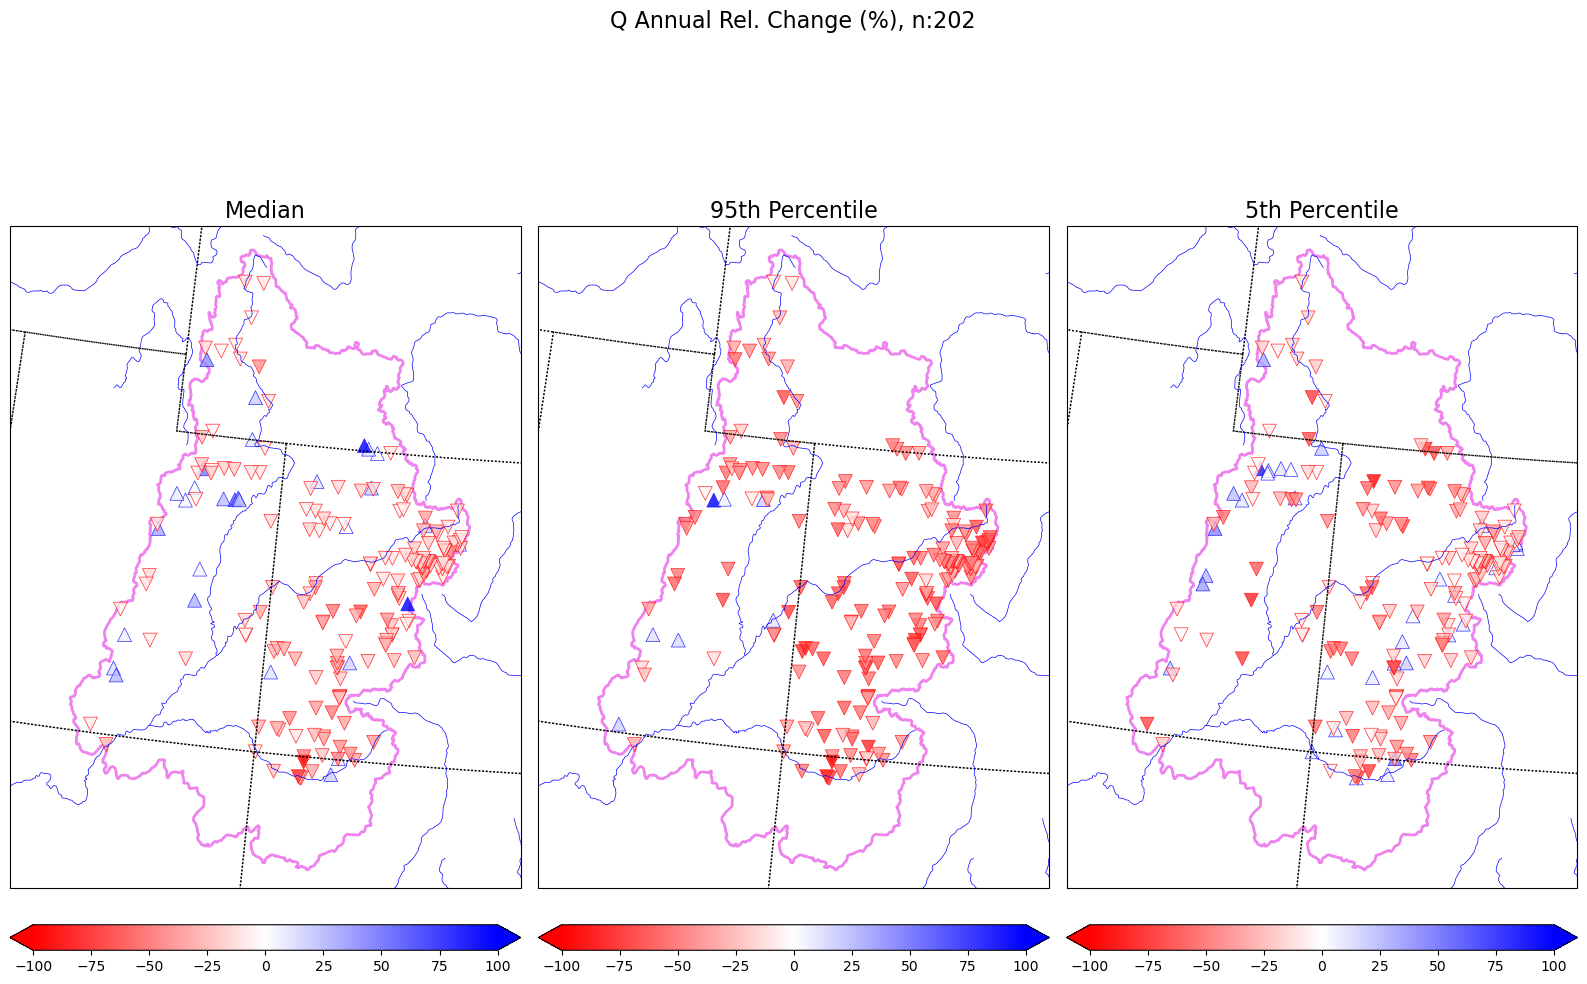

In [84]:
plot_vars = min_max
colorscheme ='bwr_r' #'PuOr'for WT and SC # 'bwr_r' for Q
var_2plot = var_names[0]
fig, axes = plt.subplots(
    nrows=1, ncols=3,figsize=(16, 10),
    subplot_kw={
        'projection': crs.AlbersEqualArea(
            central_latitude=39.5,
            central_longitude=-98.35)})

fig.suptitle("Q Annual Rel. Change (%), n:"+str(len(vars()[var_2plot+'list_mapping_return_5'][0].index)),fontsize=16)
# common shapefile for the basin boundary
fname = upper_colorado_river_boundary_dir / 'Upper_Colorado_River_Basin_Boundary.shp'
shape_feature = ShapelyFeature(
    shpreader(str(fname)).geometries(),
    crs.PlateCarree(),edgecolor='violet',facecolor='white',lw=2)

for ax, var in zip(axes[1:], plot_vars):
    # add coastlines, states, rivers
    ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.STATES,    linestyle=':', edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.RIVERS,    edgecolor='blue', linewidth=0.5)
    ax.add_feature(shape_feature, zorder=-1)

    # zoom into the basin
    ax.set_extent([-113, -105, 35.5, 43.5], crs=crs.PlateCarree())

    # get the data
    data = vars()[var_2plot+'list_mapping_return_'+var][0]

    # choose vmin/vmax by variable
    vmin, vmax = -100, 100

    d = data[(data['Relative Change (%)'] >= 0) & (data['CLASS']=='Non-Ref')]
    ax.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                   marker= '^', edgecolors= (0, 0, 1, 0.1), #(0.5, 0, 0.5, 0.1), # edgecolors=(0.5, 0.5, 0.5, 1) edgecolors=(0, 0, 1, 0.1),
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

    d = data[(data['Relative Change (%)'] < 0) ] # & (data['CLASS']=='Non-Ref')
    ax.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                   marker= 'v',edgecolors=(1, 0, 0, 0.1), #(1, 0.5, 0, 0.1), #edgecolors=(1, 0, 0, 0.1), 
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

    # add a small invisible scatter just for the colorbar
    cb = ax.scatter(
        [], [],c=[],cmap='bwr_r',vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(
        cb, ax=ax,
        orientation='horizontal',
        fraction=0.05, pad=0.04,
        extend='both')
    cbar.ax.tick_params(labelsize=10)

    # title
    ax.set_title(var+'th Percentile',fontsize=16)   

# add coastlines, states, rivers
axes[0].add_feature(cfeature.COASTLINE, linestyle=':', edgecolor='black', linewidth=1)
axes[0].add_feature(cfeature.STATES,    linestyle=':', edgecolor='black', linewidth=1)
axes[0].add_feature(cfeature.RIVERS,    edgecolor='blue', linewidth=0.5)
axes[0].add_feature(shape_feature, zorder=-1)

# zoom into the basin
axes[0].set_extent([-113, -105, 35.5, 43.5], crs=crs.PlateCarree())

    # get the data
data = RDC_MEDrelchange_map_all3

# choose vmin/vmax by variable
vmin, vmax = -100, 100

d = data[(data['Relative Change (%)'] >= 0) & (data['CLASS']=='Non-Ref')]
axes[0].scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                   marker= '^', edgecolors= (0, 0, 1, 0.1), #(0.5, 0, 0.5, 0.1), # edgecolors=(0.5, 0.5, 0.5, 1) edgecolors=(0, 0, 1, 0.1),
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

d = data[(data['Relative Change (%)'] < 0) ] # & (data['CLASS']=='Non-Ref')
axes[0].scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                   marker= 'v',edgecolors=(1, 0, 0, 0.1), #(1, 0.5, 0, 0.1), #edgecolors=(1, 0, 0, 0.1), 
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

# add a small invisible scatter just for the colorbar
cb = axes[0].scatter(
        [], [],c=[],cmap='bwr_r',vmin=vmin, vmax=vmax)
cbar = fig.colorbar(
        cb, ax=axes[0],
        orientation='horizontal',
        fraction=0.05, pad=0.04,
        extend='both')
cbar.ax.tick_params(labelsize=10)

# title
axes[0].set_title('Median',fontsize=16)   

plt.tight_layout()
plt.savefig(fig_dir+'RDC_locations_percentiles.jpeg',format='jpeg',dpi=300)
plt.show()

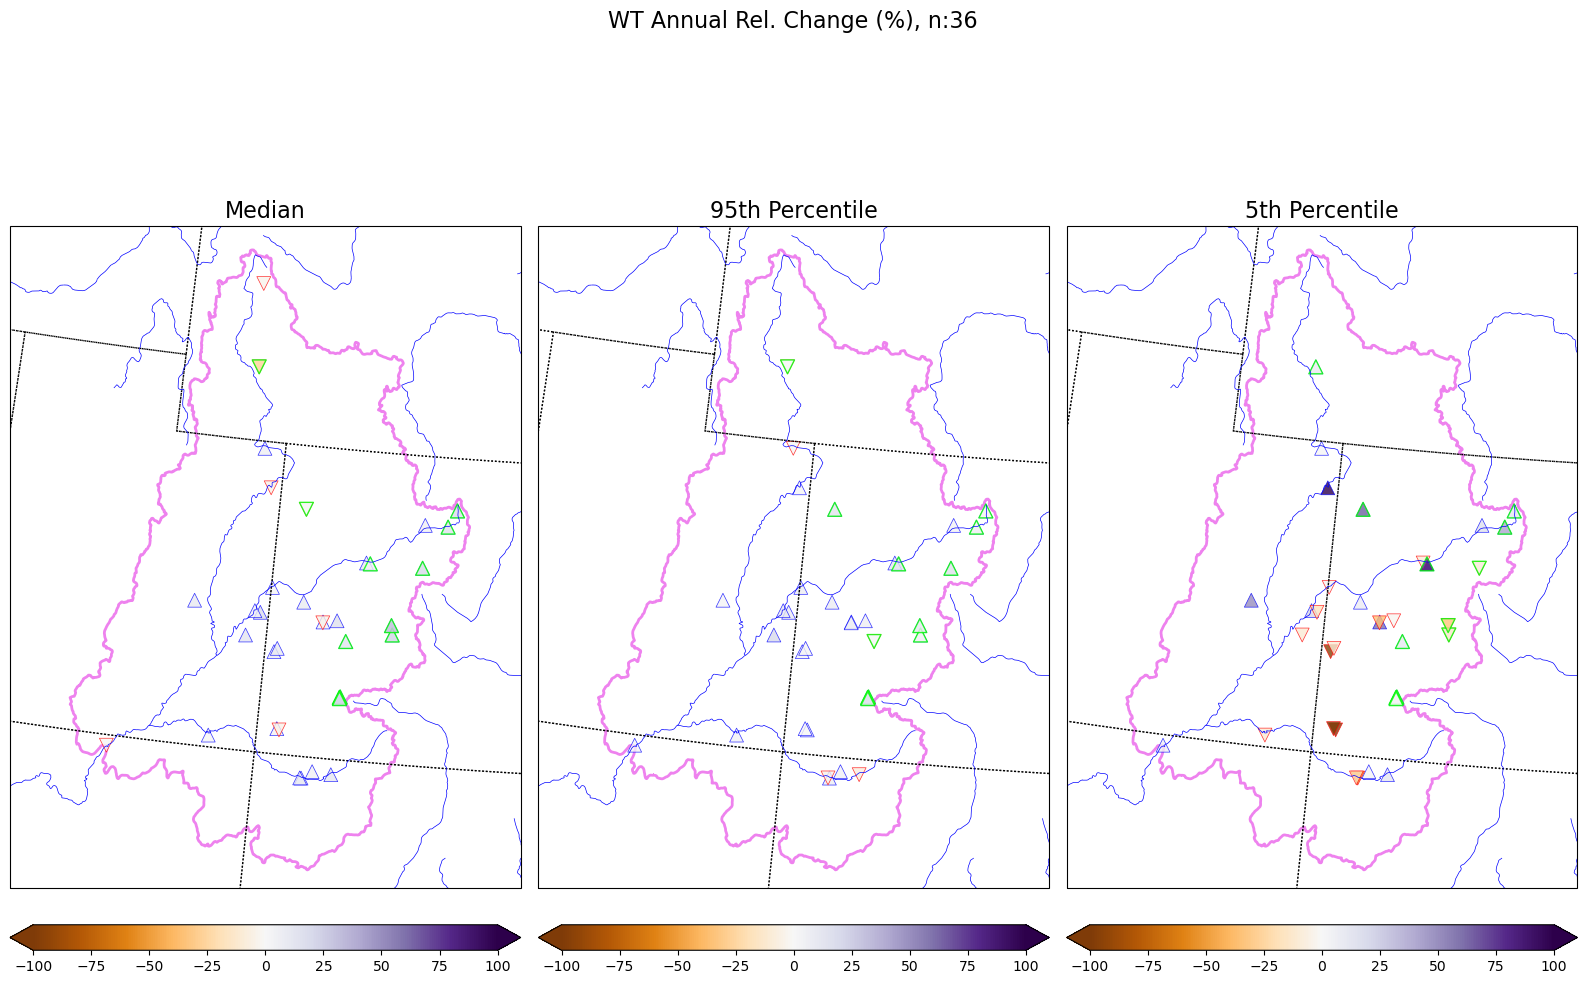

In [85]:
plot_vars = min_max
colorscheme ='PuOr' #'PuOr'for WT and SC # 'bwr_r' for Q
var_2plot = var_names[1]
fig, axes = plt.subplots(
    nrows=1, ncols=3,figsize=(16, 10),
    subplot_kw={
        'projection': crs.AlbersEqualArea(
            central_latitude=39.5,
            central_longitude=-98.35)})

fig.suptitle("WT Annual Rel. Change (%), n:"+str(len(vars()[var_2plot+'list_mapping_return_5'][0].index)),fontsize=16)
# common shapefile for the basin boundary
fname = upper_colorado_river_boundary_dir / 'Upper_Colorado_River_Basin_Boundary.shp'
shape_feature = ShapelyFeature(
    shpreader(str(fname)).geometries(),
    crs.PlateCarree(),edgecolor='violet',facecolor='white',lw=2)

for ax, var in zip(axes[1:], plot_vars):
    # add coastlines, states, rivers
    ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.STATES,    linestyle=':', edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.RIVERS,    edgecolor='blue', linewidth=0.5)
    ax.add_feature(shape_feature, zorder=-1)

    # zoom into the basin
    ax.set_extent([-113, -105, 35.5, 43.5], crs=crs.PlateCarree())

    # get the data
    data = vars()[var_2plot+'list_mapping_return_'+var][0]

    # choose vmin/vmax by variable
    vmin, vmax = -100, 100
    
    d = data[(data['Relative Change (%)'] >= 0) & (data['CLASS']=='Non-Ref')]
    ax.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                   marker= '^', edgecolors= (0, 0, 1, 0.1), #(0.5, 0, 0.5, 0.1), # edgecolors=(0.5, 0.5, 0.5, 1) edgecolors=(0, 0, 1, 0.1),
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

    d = data[(data['Relative Change (%)'] < 0) ] # & (data['CLASS']=='Non-Ref')
    ax.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                   marker= 'v',edgecolors=(1, 0, 0, 0.1), #(1, 0.5, 0, 0.1), #edgecolors=(1, 0, 0, 0.1), 
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)
    if var_2plot == var_names[1]:
        valid_columns = data.index.intersection(PUBS_sites_all3)
        data_pubs = data.loc[valid_columns]
        d = data_pubs[(data_pubs['Relative Change (%)'] >= 0) ] # & (data_pubs['CLASS']=='Non-Ref')
        ax.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                       marker= '^',edgecolors='lime',linewidth=1,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

        d = data_pubs[(data_pubs['Relative Change (%)'] < 0) ] # & (data_pubs['CLASS']=='Non-Ref')
        ax.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                       marker= 'v',edgecolors='lime', linewidth=1,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)


    # add a small invisible scatter just for the colorbar
    cb = ax.scatter(
        [], [],c=[],cmap='PuOr',vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(
        cb, ax=ax,
        orientation='horizontal',
        fraction=0.05, pad=0.04,
        extend='both')
    cbar.ax.tick_params(labelsize=10)

    # title
    ax.set_title(var+'th Percentile',fontsize=16)   

# add coastlines, states, rivers
axes[0].add_feature(cfeature.COASTLINE, linestyle=':', edgecolor='black', linewidth=1)
axes[0].add_feature(cfeature.STATES,    linestyle=':', edgecolor='black', linewidth=1)
axes[0].add_feature(cfeature.RIVERS,    edgecolor='blue', linewidth=0.5)
axes[0].add_feature(shape_feature, zorder=-1)

# zoom into the basin
axes[0].set_extent([-113, -105, 35.5, 43.5], crs=crs.PlateCarree())

# get the data
data = vars()[var_2plot+'_MEDrelchange_map_all3']

# choose vmin/vmax by variable
vmin, vmax = -100, 100

d = data[(data['Relative Change (%)'] >= 0) & (data['CLASS']=='Non-Ref')]
axes[0].scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                   marker= '^', edgecolors= (0, 0, 1, 0.1), #(0.5, 0, 0.5, 0.1), # edgecolors=(0.5, 0.5, 0.5, 1) edgecolors=(0, 0, 1, 0.1),
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

d = data[(data['Relative Change (%)'] < 0) ] # & (data['CLASS']=='Non-Ref')
axes[0].scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                   marker= 'v',edgecolors=(1, 0, 0, 0.1), #(1, 0.5, 0, 0.1), #edgecolors=(1, 0, 0, 0.1), 
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

if var_2plot == var_names[1]:
    valid_columns = data.index.intersection(PUBS_sites_all3)
    data_pubs = data.loc[valid_columns]
    d = data_pubs[(data_pubs['Relative Change (%)'] >= 0) ] # & (data_pubs['CLASS']=='Non-Ref')
    axes[0].scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                       marker= '^',edgecolors='lime',linewidth=1,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

    d = data_pubs[(data_pubs['Relative Change (%)'] < 0) ] # & (data_pubs['CLASS']=='Non-Ref')
    axes[0].scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                       marker= 'v',edgecolors='lime', linewidth=1,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)



# add a small invisible scatter just for the colorbar
cb = axes[0].scatter(
        [], [],c=[],cmap='PuOr',vmin=vmin, vmax=vmax)
cbar = fig.colorbar(
        cb, ax=axes[0],
        orientation='horizontal',
        fraction=0.05, pad=0.04,
        extend='both')
cbar.ax.tick_params(labelsize=10)

# title
axes[0].set_title('Median',fontsize=16)   

plt.tight_layout()
plt.savefig(fig_dir+var_2plot+'_locations_percentiles.jpeg',format='jpeg',dpi=300)
plt.show()

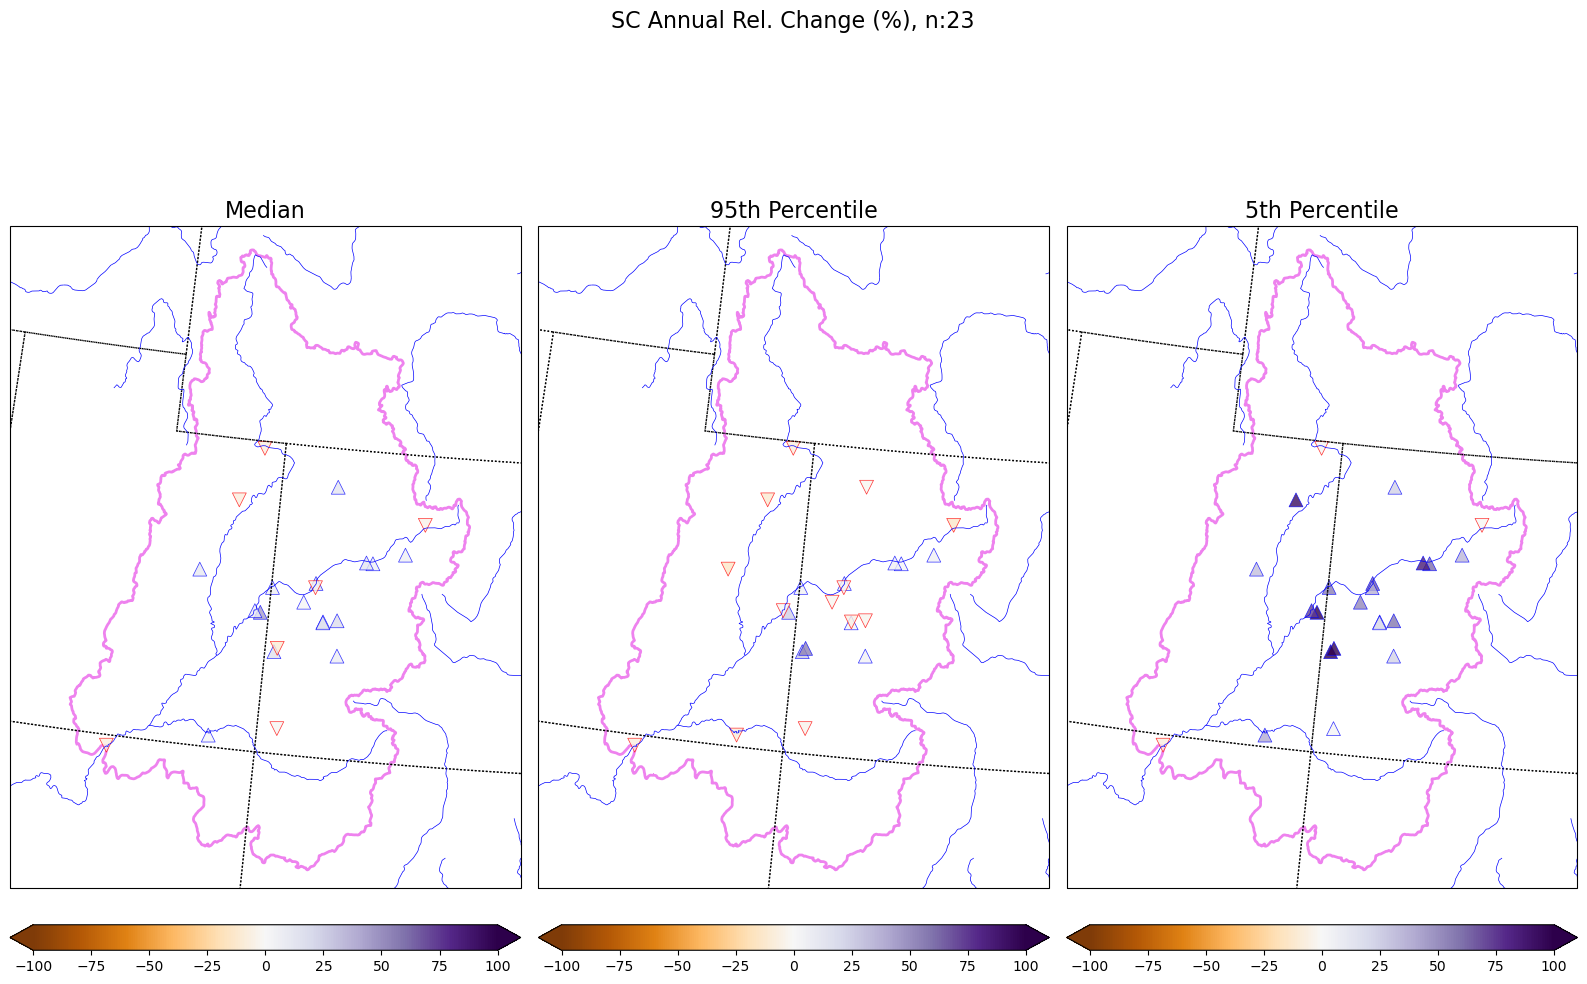

In [86]:
plot_vars = min_max
colorscheme ='PuOr' #'PuOr'for WT and SC # 'bwr_r' for Q
var_2plot = var_names[2]
fig, axes = plt.subplots(
    nrows=1, ncols=3,figsize=(16, 10),
    subplot_kw={
        'projection': crs.AlbersEqualArea(
            central_latitude=39.5,
            central_longitude=-98.35)})

fig.suptitle("SC Annual Rel. Change (%), n:"+str(len(vars()[var_2plot+'list_mapping_return_5'][0].index)),fontsize=16)
# common shapefile for the basin boundary
fname = upper_colorado_river_boundary_dir / 'Upper_Colorado_River_Basin_Boundary.shp'
shape_feature = ShapelyFeature(
    shpreader(str(fname)).geometries(),
    crs.PlateCarree(),edgecolor='violet',facecolor='white',lw=2)

for ax, var in zip(axes[1:], plot_vars):
    # add coastlines, states, rivers
    ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.STATES,    linestyle=':', edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.RIVERS,    edgecolor='blue', linewidth=0.5)
    ax.add_feature(shape_feature, zorder=-1)

    # zoom into the basin
    ax.set_extent([-113, -105, 35.5, 43.5], crs=crs.PlateCarree())

    # get the data
    data = vars()[var_2plot+'list_mapping_return_'+var][0]

    # choose vmin/vmax by variable
    vmin, vmax = -100, 100

    d = data[(data['Relative Change (%)'] >= 0) & (data['CLASS']=='Non-Ref')]
    ax.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                   marker= '^', edgecolors= (0, 0, 1, 0.1), #(0.5, 0, 0.5, 0.1), # edgecolors=(0.5, 0.5, 0.5, 1) edgecolors=(0, 0, 1, 0.1),
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

    d = data[(data['Relative Change (%)'] < 0) ] # & (data['CLASS']=='Non-Ref')
    ax.scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                   marker= 'v',edgecolors=(1, 0, 0, 0.1), #(1, 0.5, 0, 0.1), #edgecolors=(1, 0, 0, 0.1), 
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)
    

    # add a small invisible scatter just for the colorbar
    cb = ax.scatter(
        [], [],c=[],cmap='PuOr',vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(
        cb, ax=ax,
        orientation='horizontal',
        fraction=0.05, pad=0.04,
        extend='both')
    cbar.ax.tick_params(labelsize=10)

    # title
    ax.set_title(var+'th Percentile',fontsize=16)   

# add coastlines, states, rivers
axes[0].add_feature(cfeature.COASTLINE, linestyle=':', edgecolor='black', linewidth=1)
axes[0].add_feature(cfeature.STATES,    linestyle=':', edgecolor='black', linewidth=1)
axes[0].add_feature(cfeature.RIVERS,    edgecolor='blue', linewidth=0.5)
axes[0].add_feature(shape_feature, zorder=-1)

# zoom into the basin
axes[0].set_extent([-113, -105, 35.5, 43.5], crs=crs.PlateCarree())

    # get the data
data = vars()[var_2plot+'_MEDrelchange_map_all3']

# choose vmin/vmax by variable
vmin, vmax = -100, 100

d = data[(data['Relative Change (%)'] >= 0) & (data['CLASS']=='Non-Ref')]
axes[0].scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme,s= 100, alpha=0.8,
                   marker= '^', edgecolors= (0, 0, 1, 0.1), #(0.5, 0, 0.5, 0.1), # edgecolors=(0.5, 0.5, 0.5, 1) edgecolors=(0, 0, 1, 0.1),
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)

d = data[(data['Relative Change (%)'] < 0) ] # & (data['CLASS']=='Non-Ref')
axes[0].scatter(x=d.LON, y=d.LAT, c=d['Relative Change (%)'],cmap = colorscheme, s= 100,alpha=0.8,
                   marker= 'v',edgecolors=(1, 0, 0, 0.1), #(1, 0.5, 0, 0.1), #edgecolors=(1, 0, 0, 0.1), 
                   linewidth=0.5,transform=crs.PlateCarree(),vmin = vmin, vmax = vmax,zorder=1)


# add a small invisible scatter just for the colorbar
cb = axes[0].scatter(
        [], [],c=[],cmap='PuOr',vmin=vmin, vmax=vmax)
cbar = fig.colorbar(
        cb, ax=axes[0],
        orientation='horizontal',
        fraction=0.05, pad=0.04,
        extend='both')
cbar.ax.tick_params(labelsize=10)

# title
axes[0].set_title('Median',fontsize=16)   

plt.tight_layout()
plt.savefig(fig_dir+var_2plot+'_locations_percentiles.jpeg',format='jpeg',dpi=300)
plt.show()

#### Q vs P scatterplots

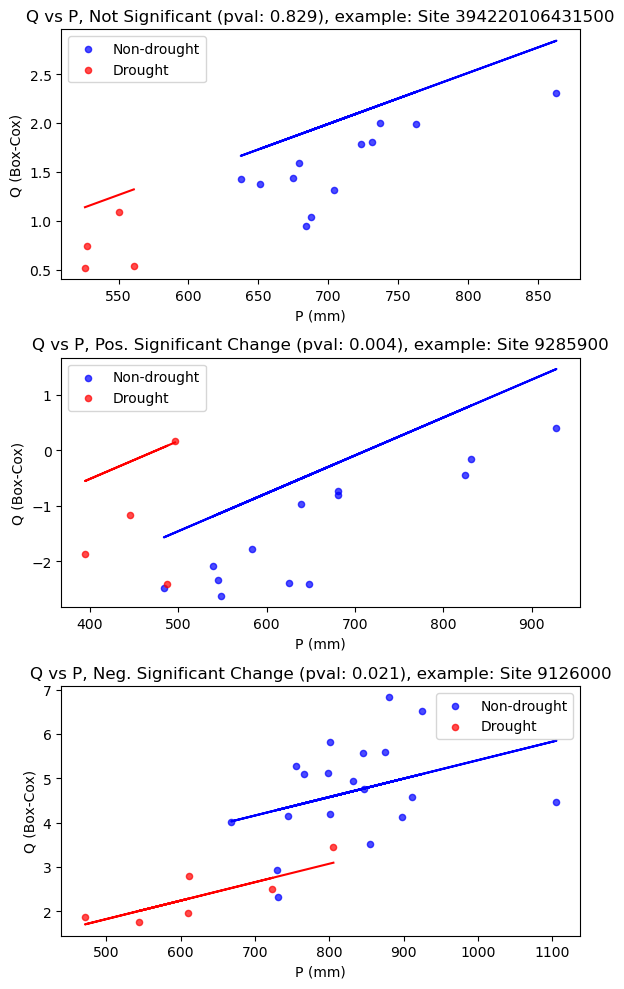

In [87]:
## SCATTERPLOT: Q vs P examples 
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(6,10))
fsize=12
fontsize2=fsize-2
## ax0 = not sig, ax1 = sig pos, ax2 = sig neg

for val,ax in enumerate(axs):
    site = sites_plot[val]

    # Extract data for site
    Q = Q_all[site]
    P = P_all[site]
    I = I_all[site]

    # Clean data (drop NaNs)
    df = pd.DataFrame({'Q': Q, 'P': P, 'I': I}).dropna()

    row = results.loc[site]
    a0, a1, a2 = row['a0'], row['a1'], row['a2']
    pval = row['pval_a1']
    
    # Scatter plot, color by drought indicator I
    colors = df['I'].map({0: 'blue', 1: 'red'})
    labels = {0: 'Non-drought', 1: 'Drought'}

    for i_val, color in zip([0,1], ['blue', 'red']):
        subset = df[df['I'] == i_val]
        ax.scatter(x=subset['P'], y=subset['Q'], c=color, label=labels[i_val], alpha=0.7,s=20)

        # # Create range of P values for regression lines
        # P_range = np.linspace(df['P'].min(), df['P'].max(), 100)

        # Regression lines:
        if i_val == 0:
            Q_line = a0 + a1*0 + a2*subset['P']
        if i_val == 1:
            Q_line = a0 + a1*1 + a2*subset['P']

        ax.plot(subset['P'], Q_line, color=color)
    
    if pval >= 0.05:
        ax.set_title(f'Q vs P, Not Significant (pval: {pval:.3f}), example: Site {site}')

    if pval < 0.05:
        if val == 1:
            ax.set_title(f'Q vs P, Pos. Significant Change (pval: {pval:.3f}), example: Site {site}')
        if val == 2:
            ax.set_title(f'Q vs P, Neg. Significant Change (pval: {pval:.3f}), example: Site {site}')
            
    ax.set_xlabel('P (mm)')
    ax.set_ylabel('Q (Box-Cox)')
    ax.legend(loc='best')
    #ax.grid(True)


    for label in (ax.get_yticklabels()):
        label.set_fontsize(fontsize2)
    
    for label in (ax.get_xticklabels()):
        label.set_fontsize(fontsize2)

fig.tight_layout()
#plt.savefig(fig_dir+'p_q_examplesites.jpeg',dpi=300)
plt.show()

#### Long-term Trend

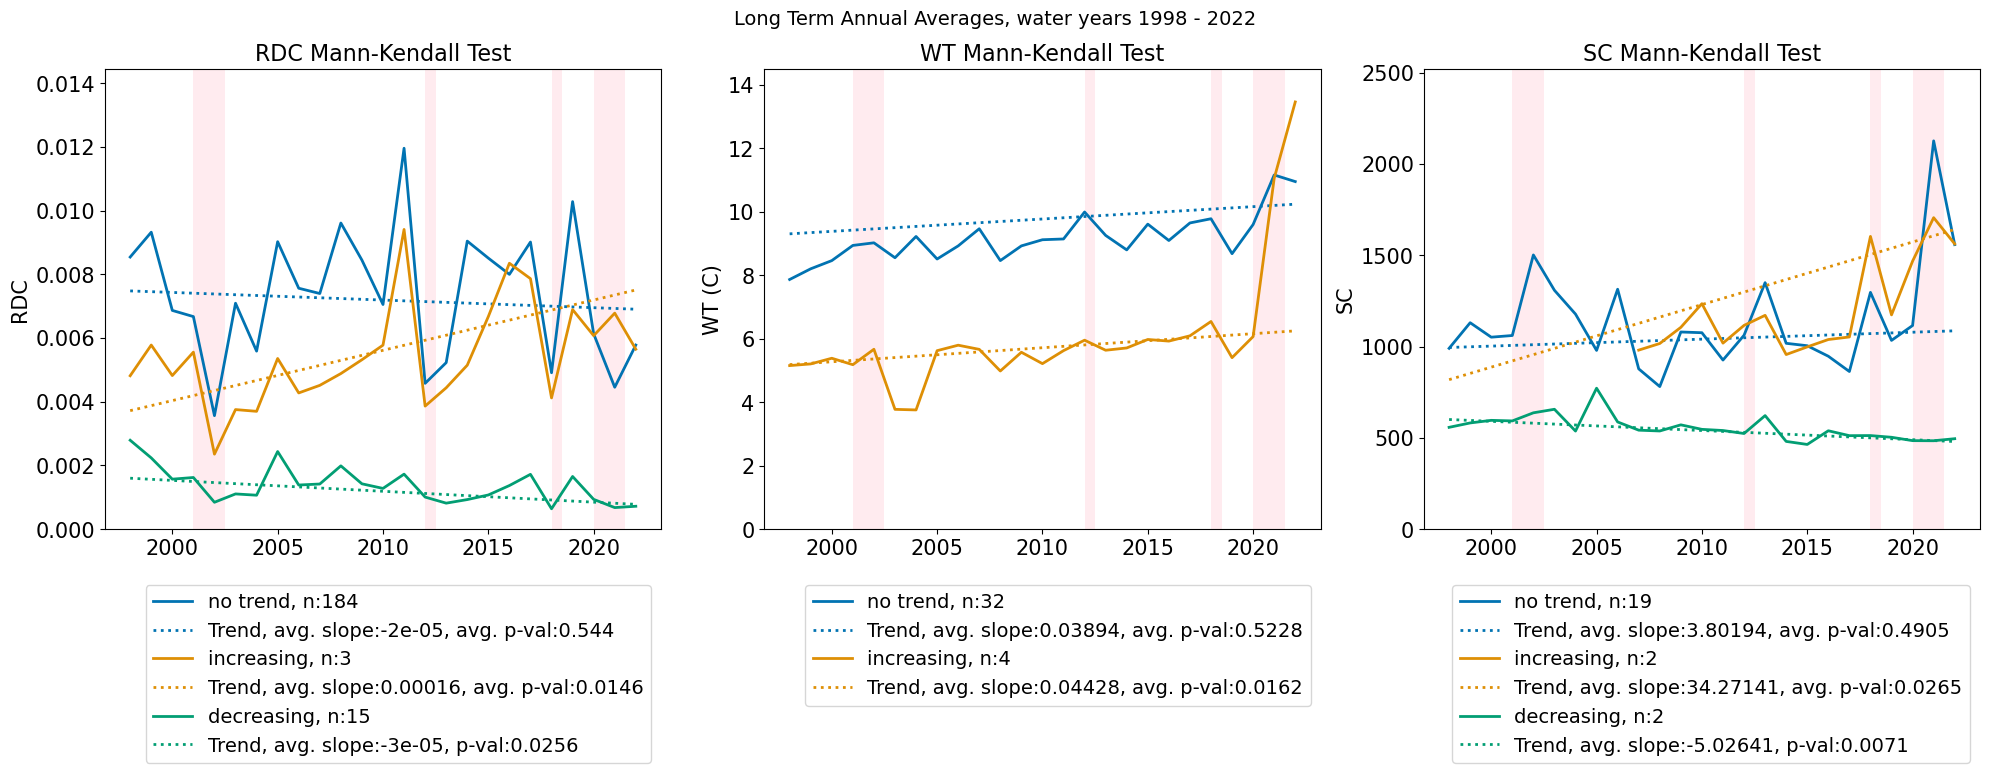

In [88]:
## PLOT: Long term ANNUAL Avg, VARS, with num of sites, MK results
figsize=(20,8)
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=figsize)#,sharex=True)

fontsize=14
fig.suptitle("Long Term Annual Averages, water years 1998 - 2022",fontsize=fontsize)
for val,ax in enumerate(axs):
    var = var_names[val]
    if var == var_names[1]:
        ax.set_ylabel('WT (C)', fontsize=fontsize+1)
    else:
        ax.set_ylabel(f'{var}', fontsize=fontsize+1)
    
    ax.set_title(f"{var} Mann-Kendall Test", fontsize=fontsize+2)

    handles = []

    all_sites = vars()[var+'_years']
    all_sites_mean = vars()[var+'_years'].mean(axis=1)
    # vars()[var+'_trend_line'] = np.arange(len(vars()[var+'_annual_mean'].values)) * vars()[var+'slope'] + vars()[var+'intercept']
    notrend = vars()[var+'_years'][vars()[var+'_notrend'].index]
    notrend_sites = len(vars()[var+'_notrend'].index)
    notrend_trend_line = np.arange(len(notrend.values)) * vars()[var+'_notrend']['slope'].mean() + vars()[var+'_notrend']['intercept'].mean()
    notrend_pval = vars()[var+'_notrend']['p'].mean()
    
    line1, = ax.plot(np.arange(1998,2023,1),notrend.mean(axis=1),label='no trend, n:'+str(notrend_sites),color=met_cmap[0], markersize=4, linewidth=2)
    handles.append(line1)
    #ax.fill_between(np.arange(1992,2023,1),WT_minOf_annual_mean,WT_maxOf_annual_mean, alpha = 0.3) #markersize=6, marker=dr_markerstyles[dr], linestyle=dr_linestyles[dr], linewidth=2)

    line2, = ax.plot(np.arange(1998,2023,1),notrend_trend_line,label='Trend, avg. slope:'+str(round(vars()[var+'_notrend']['slope'].mean(),5))+', avg. p-val:'+str(round(notrend_pval,4)),
                     markersize=4, linewidth=2, color=met_cmap[0],linestyle=':')
    handles.append(line2)

    if len(vars()[var+'_increasing'].index) != 0:
        increasing = vars()[var+'_years'][vars()[var+'_increasing'].index]
        increasing_sites = len(vars()[var+'_increasing'].index)
        increasing_trend_line = np.arange(len(increasing.values)) * vars()[var+'_increasing']['slope'].mean() + vars()[var+'_increasing']['intercept'].mean()
        increasing_pval = vars()[var+'_increasing']['p'].mean()

        line3, = ax.plot(np.arange(1998,2023,1),increasing.mean(axis=1),label='increasing, n:'+str(increasing_sites),color=met_cmap[1], markersize=4, linewidth=2)
        handles.append(line3)
        line4, = ax.plot(np.arange(1998,2023,1),increasing_trend_line,label='Trend, avg. slope:'+str(round(vars()[var+'_increasing']['slope'].mean(),5))+', avg. p-val:'+str(round(increasing_pval,4)),
                     markersize=4, linewidth=2, color=met_cmap[1],linestyle=':')
        handles.append(line4)
    
    if len(vars()[var+'_decreasing'].index) != 0:
        decreasing = vars()[var+'_years'][vars()[var+'_decreasing'].index]
        decreasing_sites = len(vars()[var+'_decreasing'].index)
        decreasing_trend_line = np.arange(len(decreasing.values)) * vars()[var+'_decreasing']['slope'].mean() + vars()[var+'_decreasing']['intercept'].mean()
        decreasing_pval = vars()[var+'_decreasing']['p'].mean()

        line5, = ax.plot(np.arange(1998,2023,1),decreasing.mean(axis=1),label='decreasing, n:'+str(decreasing_sites),color=met_cmap[2], markersize=4, linewidth=2)
        handles.append(line5)
        line6, = ax.plot(np.arange(1998,2023,1),decreasing_trend_line,label='Trend, avg. slope:'+str(round(vars()[var+'_decreasing']['slope'].mean(),5))+', p-val:'+str(round(decreasing_pval,4)),
                     markersize=4, linewidth=2, color=met_cmap[2],linestyle=':')
        handles.append(line6)
    

    rect2001 = mpl.patches.Rectangle((2001, 0), 1.5, all_sites_mean.max()+(all_sites_mean.max()*0.3), facecolor='pink', alpha=0.3)
    rect2012 = mpl.patches.Rectangle((2012, 0), 0.5, all_sites_mean.max()+(all_sites_mean.max()*0.3), facecolor='pink', alpha=0.3)
    rect2018 = mpl.patches.Rectangle((2018, 0), 0.5, all_sites_mean.max()+(all_sites_mean.max()*0.3), facecolor='pink', alpha=0.3)
    rect2020 = mpl.patches.Rectangle((2020, 0), 1.5, all_sites_mean.max()+(all_sites_mean.max()*0.3), facecolor='pink', alpha=0.3)
    
    # Add the patch to the axes
    ax.add_patch(rect2001)
    ax.add_patch(rect2012)
    ax.add_patch(rect2018)
    ax.add_patch(rect2020)

    ax.set_ylim(0, all_sites_mean.max()+(all_sites_mean.max()*0.3))
    
    #ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize+1)

    ax.grid(False)

    ax.legend(bbox_to_anchor=(1, -0.10),handles=handles,loc='best', prop={"size":fontsize})

fig.tight_layout()
plt.savefig(fig_dir+'/ALL3_longterm_trend_MKtest_drshading.jpeg',dpi=300)
plt.show()

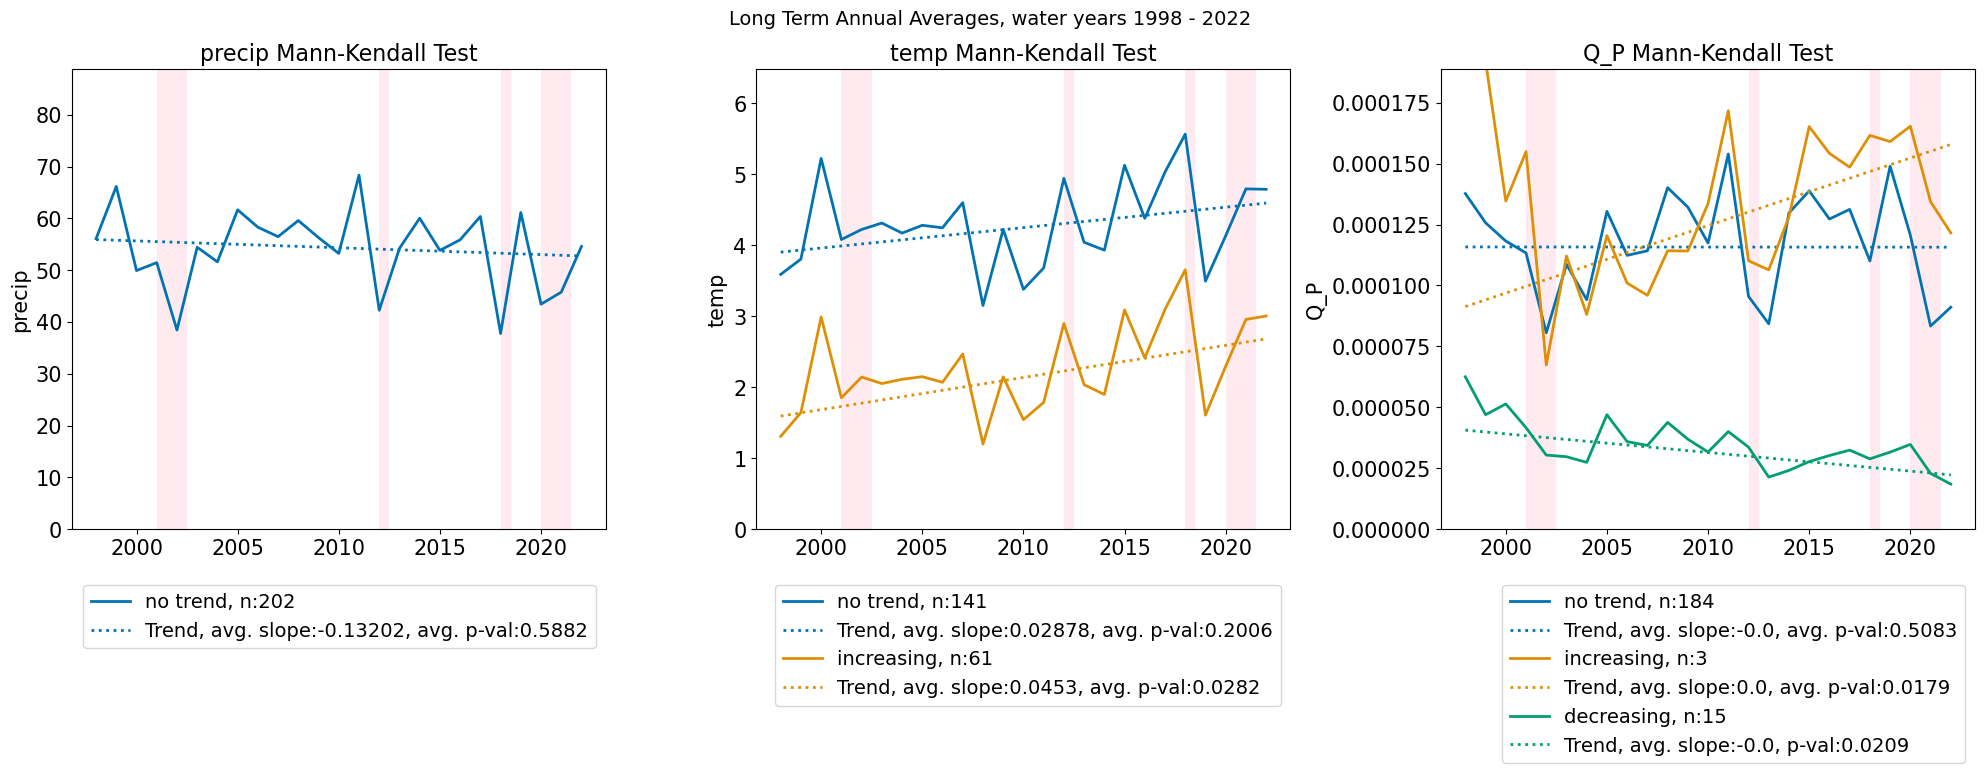

In [89]:
MET_vars_QP = ['precip', 'temp','Q_P']

## PLOT: Long term ANNUAL Avg, VARS, with num of sites, MK results
figsize=(20,8)
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=figsize)#,sharex=True)

fontsize=14
fig.suptitle("Long Term Annual Averages, water years 1998 - 2022",fontsize=fontsize)
for val,ax in enumerate(axs):
    var = MET_vars_QP[val]
    if var == var_names[1]:
        ax.set_ylabel('WT (C)', fontsize=fontsize+1)
    else:
        ax.set_ylabel(f'{var}', fontsize=fontsize+1)
    
    ax.set_title(f"{var} Mann-Kendall Test", fontsize=fontsize+2)

    handles = []

    all_sites = vars()[var+'_years']
    all_sites_mean = vars()[var+'_years'].mean(axis=1)
    # vars()[var+'_trend_line'] = np.arange(len(vars()[var+'_annual_mean'].values)) * vars()[var+'slope'] + vars()[var+'intercept']
    notrend = vars()[var+'_years'][vars()[var+'_notrend'].index]
    notrend_sites = len(vars()[var+'_notrend'].index)
    notrend_trend_line = np.arange(len(notrend.values)) * vars()[var+'_notrend']['slope'].mean() + vars()[var+'_notrend']['intercept'].mean()
    notrend_pval = vars()[var+'_notrend']['p'].mean()
    
    line1, = ax.plot(np.arange(1998,2023,1),notrend.mean(axis=1),label='no trend, n:'+str(notrend_sites),color=met_cmap[0], markersize=4, linewidth=2)
    handles.append(line1)
    #ax.fill_between(np.arange(1992,2023,1),WT_minOf_annual_mean,WT_maxOf_annual_mean, alpha = 0.3) #markersize=6, marker=dr_markerstyles[dr], linestyle=dr_linestyles[dr], linewidth=2)

    line2, = ax.plot(np.arange(1998,2023,1),notrend_trend_line,label='Trend, avg. slope:'+str(round(vars()[var+'_notrend']['slope'].mean(),5))+', avg. p-val:'+str(round(notrend_pval,4)),
                     markersize=4, linewidth=2, color=met_cmap[0],linestyle=':')
    handles.append(line2)

    if len(vars()[var+'_increasing'].index) != 0:
        increasing = vars()[var+'_years'][vars()[var+'_increasing'].index]
        increasing_sites = len(vars()[var+'_increasing'].index)
        increasing_trend_line = np.arange(len(increasing.values)) * vars()[var+'_increasing']['slope'].mean() + vars()[var+'_increasing']['intercept'].mean()
        increasing_pval = vars()[var+'_increasing']['p'].mean()

        line3, = ax.plot(np.arange(1998,2023,1),increasing.mean(axis=1),label='increasing, n:'+str(increasing_sites),color=met_cmap[1], markersize=4, linewidth=2)
        handles.append(line3)
        line4, = ax.plot(np.arange(1998,2023,1),increasing_trend_line,label='Trend, avg. slope:'+str(round(vars()[var+'_increasing']['slope'].mean(),5))+', avg. p-val:'+str(round(increasing_pval,4)),
                     markersize=4, linewidth=2, color=met_cmap[1],linestyle=':')
        handles.append(line4)
    
    if len(vars()[var+'_decreasing'].index) != 0:
        decreasing = vars()[var+'_years'][vars()[var+'_decreasing'].index]
        decreasing_sites = len(vars()[var+'_decreasing'].index)
        decreasing_trend_line = np.arange(len(decreasing.values)) * vars()[var+'_decreasing']['slope'].mean() + vars()[var+'_decreasing']['intercept'].mean()
        decreasing_pval = vars()[var+'_decreasing']['p'].mean()

        line5, = ax.plot(np.arange(1998,2023,1),decreasing.mean(axis=1),label='decreasing, n:'+str(decreasing_sites),color=met_cmap[2], markersize=4, linewidth=2)
        handles.append(line5)
        line6, = ax.plot(np.arange(1998,2023,1),decreasing_trend_line,label='Trend, avg. slope:'+str(round(vars()[var+'_decreasing']['slope'].mean(),5))+', p-val:'+str(round(decreasing_pval,4)),
                     markersize=4, linewidth=2, color=met_cmap[2],linestyle=':')
        handles.append(line6)
    

    rect2001 = mpl.patches.Rectangle((2001, 0), 1.5, all_sites_mean.max()+(all_sites_mean.max()*0.3), facecolor='pink', alpha=0.3)
    rect2012 = mpl.patches.Rectangle((2012, 0), 0.5, all_sites_mean.max()+(all_sites_mean.max()*0.3), facecolor='pink', alpha=0.3)
    rect2018 = mpl.patches.Rectangle((2018, 0), 0.5, all_sites_mean.max()+(all_sites_mean.max()*0.3), facecolor='pink', alpha=0.3)
    rect2020 = mpl.patches.Rectangle((2020, 0), 1.5, all_sites_mean.max()+(all_sites_mean.max()*0.3), facecolor='pink', alpha=0.3)
    
    # Add the patch to the axes
    ax.add_patch(rect2001)
    ax.add_patch(rect2012)
    ax.add_patch(rect2018)
    ax.add_patch(rect2020)

    ax.set_ylim(0, all_sites_mean.max()+(all_sites_mean.max()*0.3))
    
    #ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize+1)

    ax.grid(False)
    #ax.grid(axis='x',alpha=0.6)
    ax.legend(bbox_to_anchor=(1, -0.10),handles=handles,loc='best', prop={"size":fontsize})

fig.tight_layout()
plt.savefig(fig_dir+'MET_longterm_trend_MKtest_drshading.jpeg',dpi=300)
plt.show()

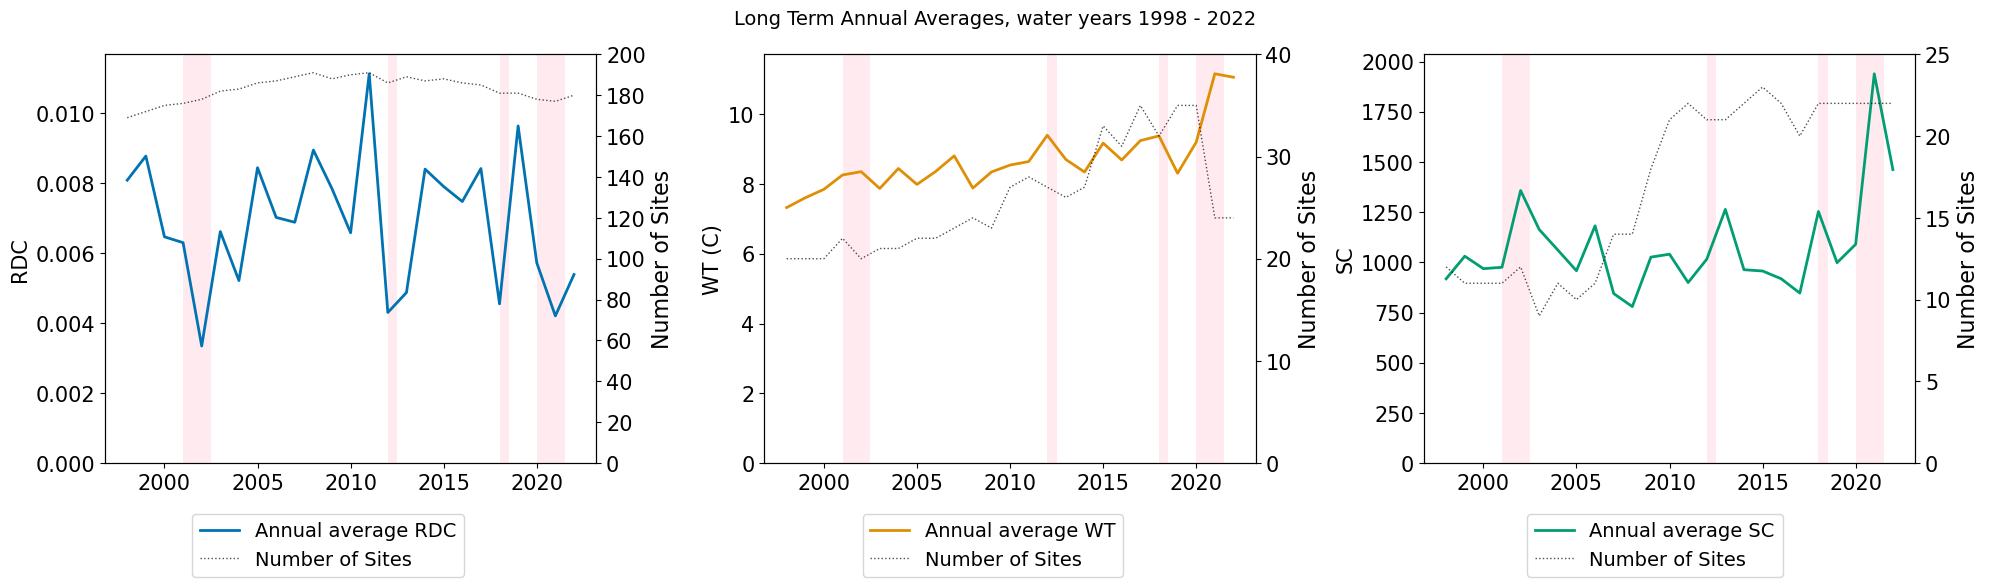

In [90]:
## PLOT: Long term ANNUAL Avg, VARS, with num of sites, MK results
figsize=(20,6)
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=figsize)#,sharex=True)

fontsize=14
fig.suptitle("Long Term Annual Averages, water years 1998 - 2022",fontsize=fontsize)
for val,ax in enumerate(axs):
    var = var_names[val]
    if var == var_names[1]:
        ax.set_ylabel('WT (C)', fontsize=fontsize+1)
    else:
        ax.set_ylabel(f'{var}', fontsize=fontsize+1)

    handles = []

    line1, = ax.plot(np.arange(1998,2023,1),vars()[var+'_annual_mean'],label='Annual average '+var,color=episode_cmap[val], markersize=4, linewidth=2)
    handles.append(line1)

    rect2001 = mpl.patches.Rectangle((2001, 0), 1.5, vars()[var+'_annual_mean'].max()+(vars()[var+'_annual_mean'].max()*0.05), facecolor='pink', alpha=0.3)
    rect2012 = mpl.patches.Rectangle((2012, 0), 0.5, vars()[var+'_annual_mean'].max()+(vars()[var+'_annual_mean'].max()*0.05), facecolor='pink', alpha=0.3)
    rect2018 = mpl.patches.Rectangle((2018, 0), 0.5, vars()[var+'_annual_mean'].max()+(vars()[var+'_annual_mean'].max()*0.05), facecolor='pink', alpha=0.3)
    rect2020 = mpl.patches.Rectangle((2020, 0), 1.5, vars()[var+'_annual_mean'].max()+(vars()[var+'_annual_mean'].max()*0.05), facecolor='pink', alpha=0.3)
    
    # Add the patch to the axes
    ax.add_patch(rect2001)
    ax.add_patch(rect2012)
    ax.add_patch(rect2018)
    ax.add_patch(rect2020)

    #ax.set_ylim(vars()[var+'_annual_mean'].min()-(vars()[var+'_annual_mean'].min()*0.1), vars()[var+'_annual_mean'].max()+(vars()[var+'_annual_mean'].max()*0.05))
    ax.set_ylim(0, vars()[var+'_annual_mean'].max()+(vars()[var+'_annual_mean'].max()*0.05))
    
    #ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize+1)

    ax.grid(False)
    #ax.grid(axis='x',alpha=0.6)
    ax2 = ax.twinx() 
    ax2.grid(False)
    ax2.set_ylabel('Number of Sites', fontsize=fontsize+2)
    years = np.arange(1998, 2023, 1)
    sites_count = vars()[var+'_numsites_year']['Sites'].values
    line3, = ax2.plot(years, sites_count, label='Number of Sites', color='black', 
                 linestyle=':', linewidth=1, alpha=0.7)
    # line3, = ax2.plot(np.arange(1998,2023,1),vars()[var+'_numsites_year'],label='Number of Sites',color='black',linestyle=':', linewidth=1, alpha=0.7)
    handles.append(line3)
    #ax2.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    # Set desired range
    if var == var_names[0]:
        ax2.set_ylim(0, 200) 
        ax2.yaxis.set_major_locator(mticker.MultipleLocator(20))
    if var == var_names[1]:
        ax2.set_ylim(0, 40) 
        ax2.yaxis.set_major_locator(mticker.MultipleLocator(10))
    if var == var_names[2]:
        ax2.set_ylim(0, 25) 
        ax2.yaxis.set_major_locator(mticker.MultipleLocator(5))
    
    for label in (ax2.get_yticklabels()):
        label.set_fontsize(fontsize+1)
        
    ax.legend(bbox_to_anchor=(0.75, -0.10),handles=handles, prop={"size":fontsize})

fig.tight_layout()
# plt.savefig(fig_dir+'ALL3_ann_avg_sitenumbers_drshading.jpeg',dpi=300)
plt.show()

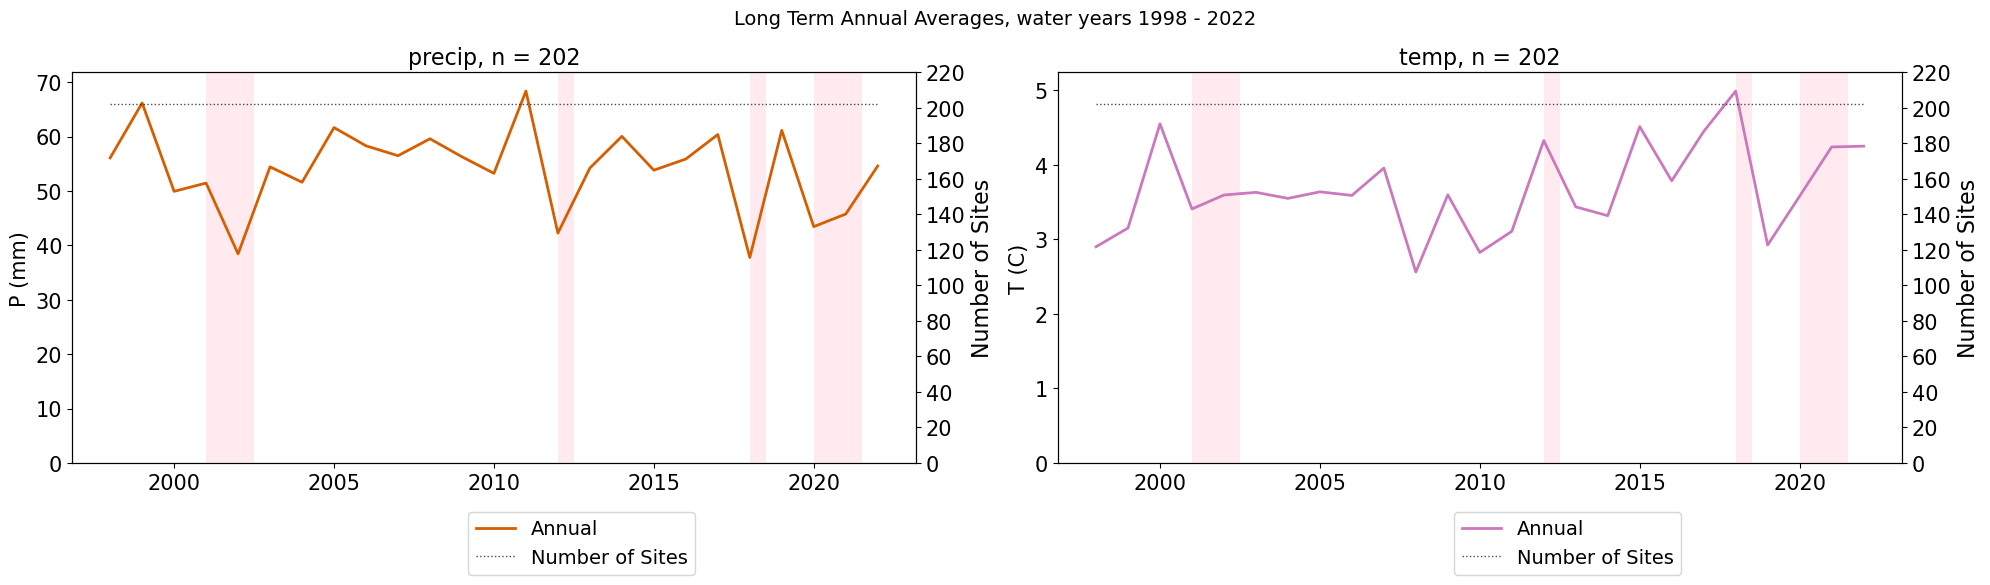

In [91]:
## PLOT: Long term ANNUAL Avg, VARS, with num of sites, MK results
figsize=(20,6)
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=figsize)#,sharex=True)

fontsize=14
fig.suptitle("Long Term Annual Averages, water years 1998 - 2022",fontsize=fontsize)
for val,ax in enumerate(axs):
    var = MET_vars[val]
    if var == MET_vars[1]:
        ax.set_ylabel('T (C)', fontsize=fontsize+1)
    else:
        ax.set_ylabel('P (mm)', fontsize=fontsize+1)
    
    ax.set_title(f"{var}, n = 202", fontsize=fontsize+2)

    handles = []

    line1, = ax.plot(np.arange(1998,2023,1),vars()[var+'_annual_mean'].loc[1998:2022],label='Annual',color=met_cmap[val+3], markersize=4, linewidth=2)
    handles.append(line1)

    rect2001 = mpl.patches.Rectangle((2001, 0), 1.5, vars()[var+'_annual_mean'].max()+(vars()[var+'_annual_mean'].max()*0.05), facecolor='pink', alpha=0.3)
    rect2012 = mpl.patches.Rectangle((2012, 0), 0.5, vars()[var+'_annual_mean'].max()+(vars()[var+'_annual_mean'].max()*0.05), facecolor='pink', alpha=0.3)
    rect2018 = mpl.patches.Rectangle((2018, 0), 0.5, vars()[var+'_annual_mean'].max()+(vars()[var+'_annual_mean'].max()*0.05), facecolor='pink', alpha=0.3)
    rect2020 = mpl.patches.Rectangle((2020, 0), 1.5, vars()[var+'_annual_mean'].max()+(vars()[var+'_annual_mean'].max()*0.05), facecolor='pink', alpha=0.3)
    
    # Add the patch to the axes
    ax.add_patch(rect2001)
    ax.add_patch(rect2012)
    ax.add_patch(rect2018)
    ax.add_patch(rect2020)

    #ax.set_ylim(vars()[var+'_annual_mean'].min()-(vars()[var+'_annual_mean'].min()*0.1), vars()[var+'_annual_mean'].max()+(vars()[var+'_annual_mean'].max()*0.05))
    ax.set_ylim(0, vars()[var+'_annual_mean'].loc[1998:2022].max()+(vars()[var+'_annual_mean'].loc[1998:2022].max()*0.05))
    
    #ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize+1)

    ax.grid(False)
    ax2 = ax.twinx() 
    ax2.grid(False)
    ax2.set_ylabel('Number of Sites', fontsize=fontsize+2)
    years = np.arange(1998, 2023, 1)
    sites_count = vars()[var+'_numsites_year'].loc[1998:2022]['Sites'].values
    line3, = ax2.plot(years, sites_count, label='Number of Sites', color='black', 
                 linestyle=':', linewidth=1, alpha=0.7)
    # line3, = ax2.plot(np.arange(1998,2023,1),vars()[var+'_numsites_year'],label='Number of Sites',color='black',linestyle=':', linewidth=1, alpha=0.7)
    handles.append(line3)
    #ax2.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    # Set desired range
    ax2.set_ylim(0, 220) 
    ax2.yaxis.set_major_locator(mticker.MultipleLocator(20))
    
    for label in (ax2.get_yticklabels()):
        label.set_fontsize(fontsize+1)
    ax.legend(bbox_to_anchor=(0.75, -0.10),handles=handles, prop={"size":fontsize})
    if val == 1:
        fig.tight_layout()
        break
# plt.savefig(fig_dir+'MET_ann_avg_sitenumbers_drshading.jpeg',dpi=300)
plt.show()

### Extra plots

#### Comparing attibutes for sites with positive and negative flow changes during drought

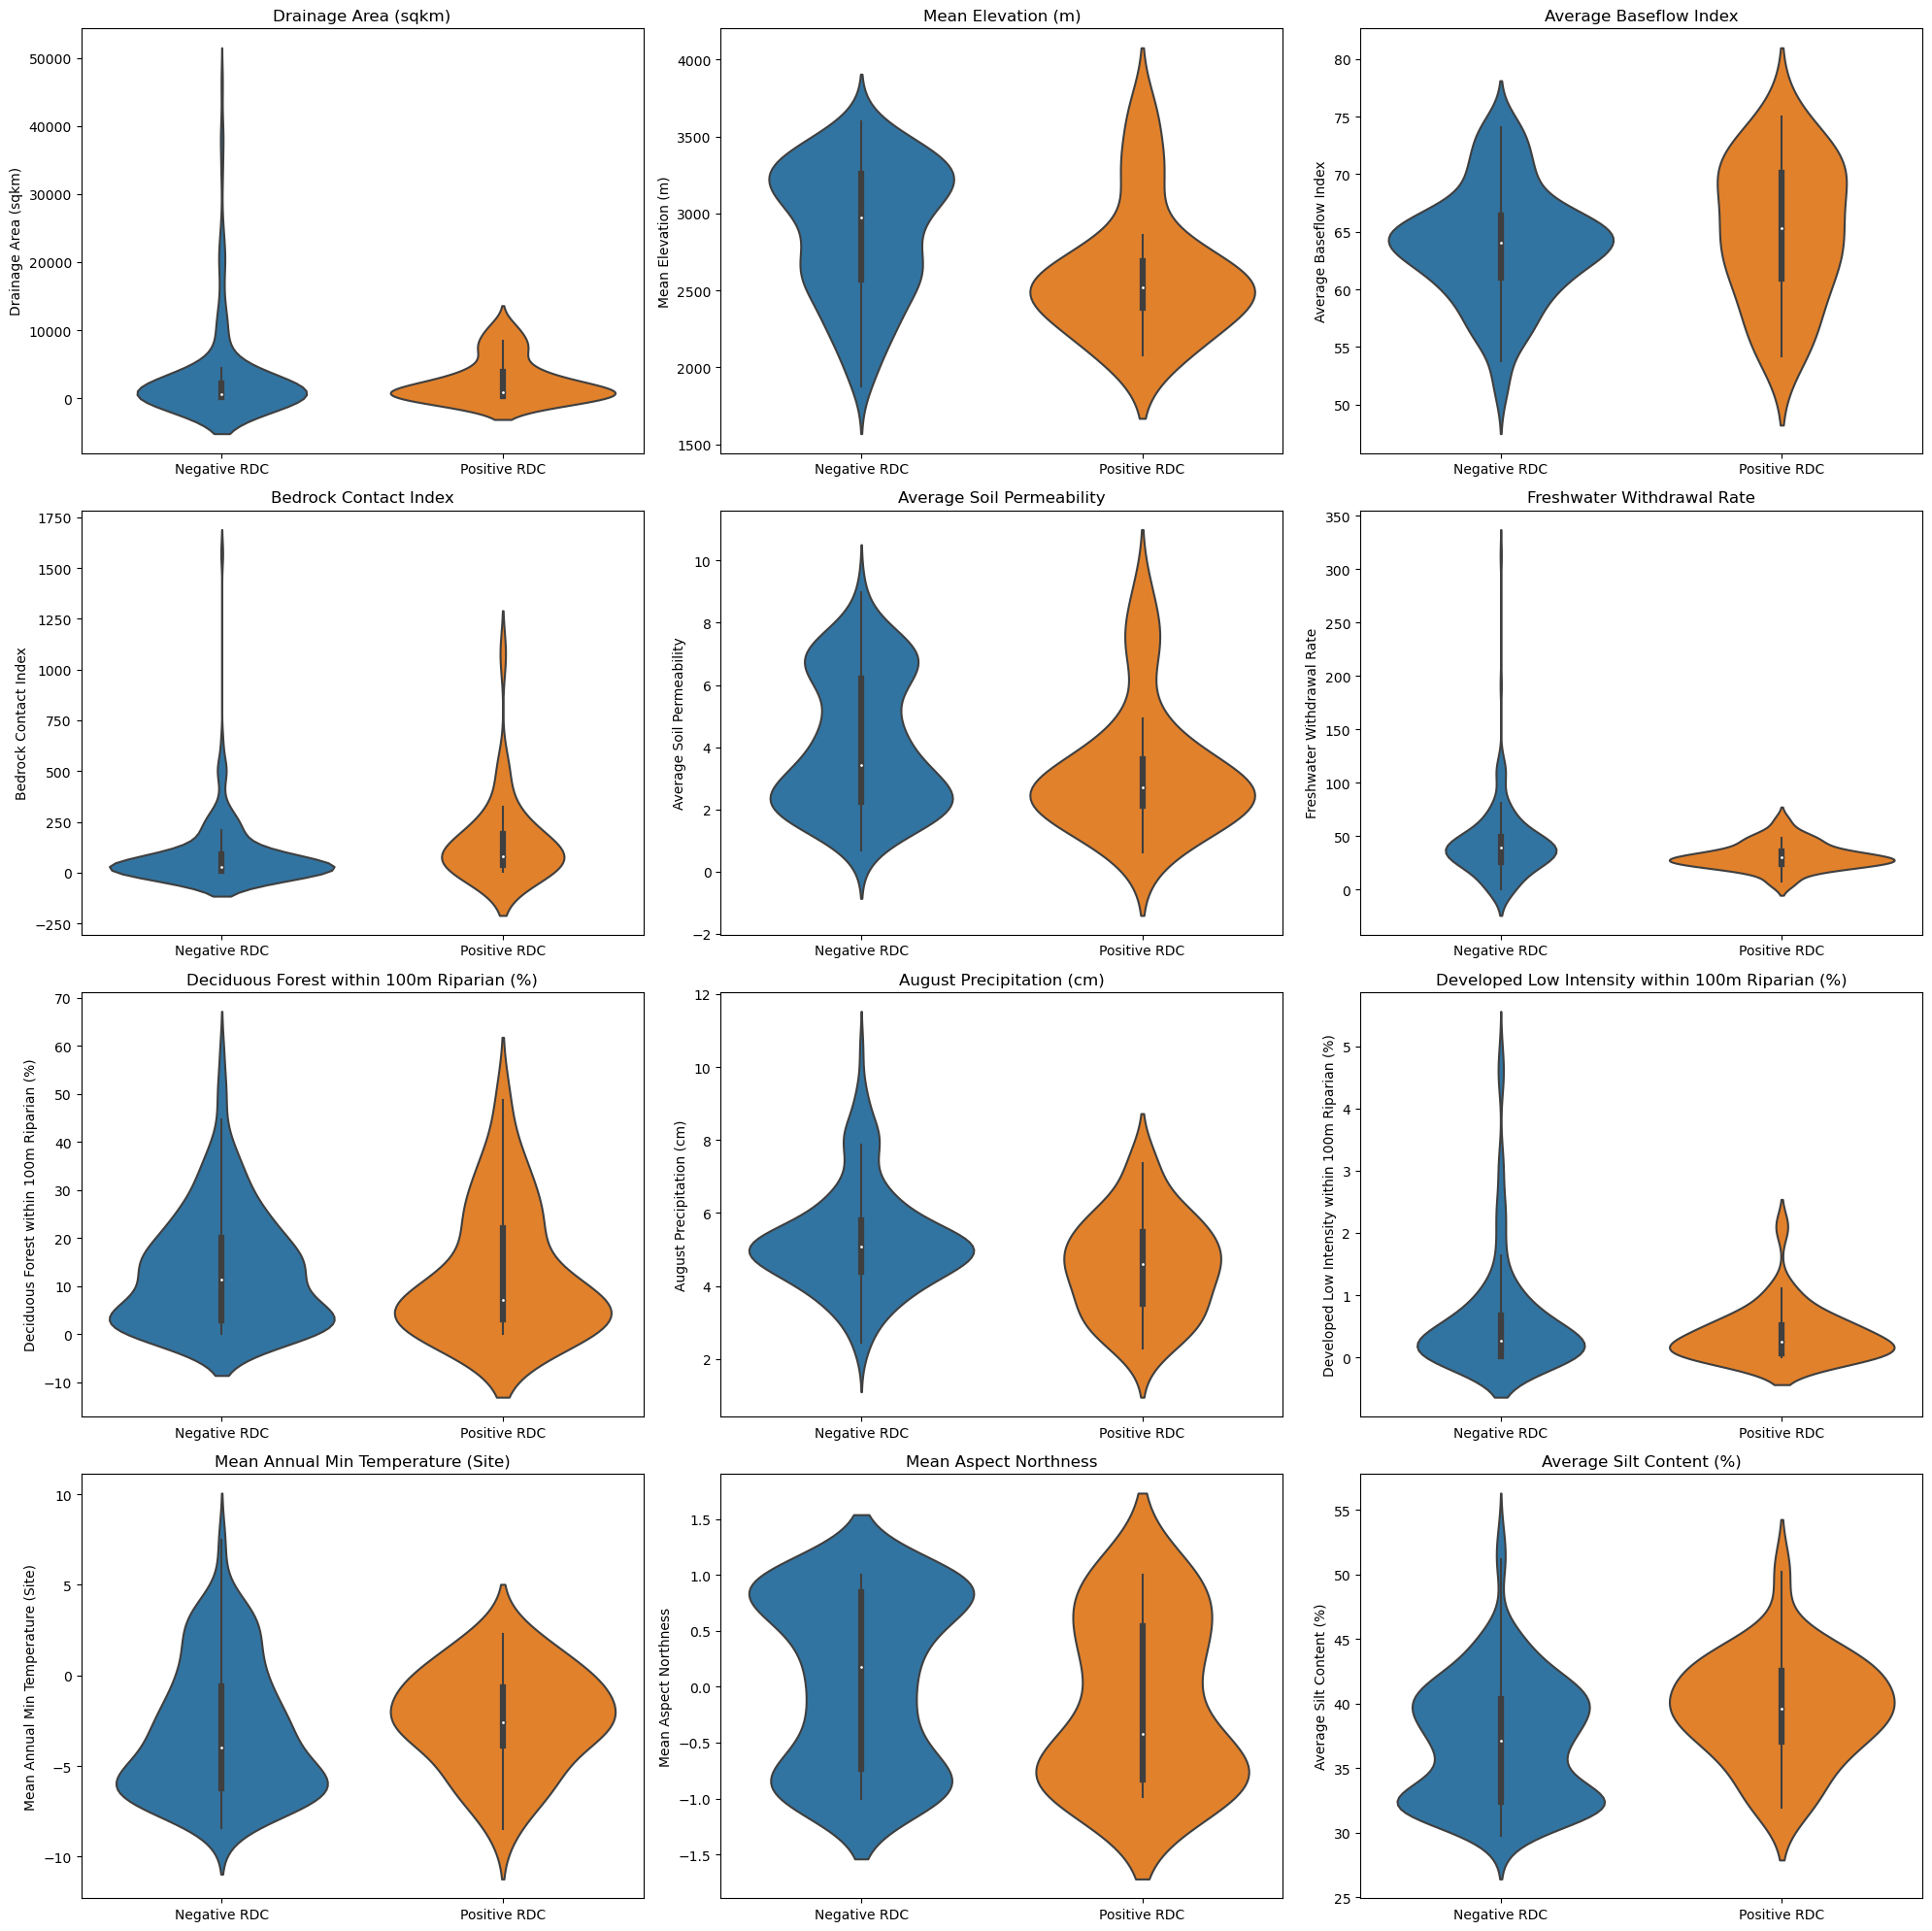

In [92]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = axes.flatten()  # Flatten to make indexing easy

# Loop through each variable and make a violin plot
for i, (gages_var_name, gages_var) in enumerate(gages_name_dict.items()):
    if i >= len(axes):
        break

    var = var_names[0]  # Assuming var_names has at least one element

    neg_data = vars()['gages_atts_neg'+var][gages_var].values
    pos_data = vars()['gages_atts_pos'+var][gages_var].values

    df = pd.DataFrame({
        'Data': np.concatenate([neg_data, pos_data]),
        'Group': np.concatenate([np.repeat('Negative '+var, len(neg_data)), np.repeat('Positive '+var, len(pos_data))])
    })

    sns.violinplot(x='Group', y='Data', data=df, ax=axes[i])
    axes[i].set_title(gages_var)
    axes[i].set_ylabel(gages_var)
    axes[i].set_xlabel('')

# Adjust layout
plt.tight_layout()
# plt.savefig(fig_dir+'traits_pos_neg_Qrelchange.jpeg',dpi=300)
plt.show()

#### Mean vs Median Scatterplots 
Take annual / monthly median, then either take MEDIAN of all years or MEAN of all years
- Will need to UNCOMMENT the commented out cells earlier in the analysis AND uncomment these cells to run

In [93]:
# ## SCATTERPLOT: ANN, Episode 
# fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(26, 10))
# var_plot_name = 'Q'
# var2_plot = var_names[0] 
# #dr = dr_names[0]
# months = vars()[var2_plot+'_mon_MEDref_'+dr].index
# for i in range(6):
#     for j in range(2):
#         ax = axs[j, i]
#         fsize = 10
#         fontsize2 = fsize - 2
#         ax.axline(xy1=(0,0), xy2=None, slope=1,color='gray', linestyle='-')
#         ax.set_ylabel(var_plot_name + ' MEDIAN', fontsize=fsize)
#         ax.set_xlabel(var_plot_name + ' MEAN ', fontsize=fsize)
#         ax.tick_params(axis='y')
        
#         if j == 0:
#             month = months[i]
#         else:
#             month = months[i+6]

#         for num,dr in enumerate(dr_names):
#             var_var = vars()[var2_plot+'_mon_MEDref_'+dr].loc[month]
#             var_MET = vars()[var2_plot+'_mon_MEANref_'+dr].loc[month]
#             ax.scatter(x=var_MET, y=var_var, s=30, alpha=0.5, marker=episode_markers[num], color=episode_cmap[num],label = dr)
#         ax.set_title(var_plot_name + ' Ref. MEAN vs MEDIAN, Month: '+str(month), fontsize=fsize)
#         for label in (ax.get_yticklabels()):
#             label.set_fontsize(fsize )
        
#         for label in (ax.get_xticklabels()):
#             label.set_fontsize(fsize)

#         ax.tick_params(axis='x', labelrotation=25)
#         ax.legend(loc='best', prop={"size": 10})
#         #ax.legend(bbox_to_anchor=(1, -0.30), prop={"size": 10})

# fig.tight_layout()
# # plt.savefig(fig_dir+'RDC_locations_percentiles.jpeg',format='jpeg',dpi=300)
# plt.show()

In [94]:
# ## SCATTERPLOT: ANN, Episode 
# fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(26, 10))
# var_plot_name = 'Q'
# var2_plot = var_names[0] 
# #dr = dr_names[0]
# months = vars()[var2_plot+'_mon_MEDref_'+dr].index
# for i in range(6):
#     for j in range(2):
#         ax = axs[j, i]
#         fsize = 10
#         fontsize2 = fsize - 2
#         ax.axline(xy1=(0,0), xy2=None, slope=1,color='gray', linestyle='-')
#         ax.set_ylabel(var_plot_name + ' MEDIAN', fontsize=fsize)
#         ax.set_xlabel(var_plot_name + ' MEAN ', fontsize=fsize)
#         ax.tick_params(axis='y')
        
#         if j == 0:
#             month = months[i]
#         else:
#             month = months[i+6]

#         var_var =(vars()[var2_plot+'_mon_MEDref_'+dr_names[0]].loc[month] + vars()[var2_plot+'_mon_MEDref_'+dr_names[1]].loc[month] + vars()[var2_plot+'_mon_MEDref_'+dr_names[2]].loc[month] + vars()[var2_plot+'_mon_MEDref_'+dr_names[3]].loc[month] )/4
#         var_MET = (vars()[var2_plot+'_mon_MEANref_'+dr_names[0]].loc[month] + vars()[var2_plot+'_mon_MEANref_'+dr_names[1]].loc[month] + vars()[var2_plot+'_mon_MEANref_'+dr_names[2]].loc[month] + vars()[var2_plot+'_mon_MEANref_'+dr_names[3]].loc[month] )/4

#         ax.scatter(x=var_MET, y=var_var, s=30, alpha=0.5, marker=episode_markers[0], color=episode_cmap[0])
#         ax.set_title(var_plot_name + ' Ref. MEAN vs MEDIAN, Month: '+str(month), fontsize=fsize)
#         for label in (ax.get_yticklabels()):
#             label.set_fontsize(fsize )
        
#         for label in (ax.get_xticklabels()):
#             label.set_fontsize(fsize)

#         ax.tick_params(axis='x', labelrotation=25)
#         #ax.legend(loc='best', prop={"size": 10})
#         #ax.legend(bbox_to_anchor=(1, -0.30), prop={"size": 10})

# fig.tight_layout()
# # plt.savefig(fig_dir+'RDC_locations_percentiles.jpeg',format='jpeg',dpi=300)
# plt.show()

In [95]:
# ## SCATTERPLOT: ANN, Episode 
# fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(26, 10))
# var_plot_name = 'Q'
# var2_plot = var_names[0] 
# #dr = dr_names[0]
# months = vars()[var2_plot+'_mon_MEDref_'+dr].index
# for i in range(6):
#     for j in range(2):
#         ax = axs[j, i]
#         fsize = 10
#         fontsize2 = fsize - 2
#         ax.axline(xy1=(0,0), xy2=None, slope=1,color='gray', linestyle='-')
#         ax.set_ylabel(var_plot_name + ' MEDIAN', fontsize=fsize)
#         ax.set_xlabel(var_plot_name + ' MEAN ', fontsize=fsize)
#         ax.tick_params(axis='y')
        
#         if j == 0:
#             month = months[i]
#         else:
#             month = months[i+6]

#         var_var =(vars()[var2_plot+'_mon_MEDrelchange_'+dr_names[0]].loc[month] + vars()[var2_plot+'_mon_MEDrelchange_'+dr_names[1]].loc[month] + vars()[var2_plot+'_mon_MEDrelchange_'+dr_names[2]].loc[month] + vars()[var2_plot+'_mon_MEDrelchange_'+dr_names[3]].loc[month] )/4
#         var_MET = (vars()[var2_plot+'_mon_MEANrelchange_'+dr_names[0]].loc[month] + vars()[var2_plot+'_mon_MEANrelchange_'+dr_names[1]].loc[month] + vars()[var2_plot+'_mon_MEANrelchange_'+dr_names[2]].loc[month] + vars()[var2_plot+'_mon_MEANrelchange_'+dr_names[3]].loc[month] )/4

#         ax.scatter(x=var_MET, y=var_var, s=30, alpha=0.5, marker=episode_markers[0], color=episode_cmap[0])
#         ax.set_title(var_plot_name + ' Ref. MEAN vs MEDIAN, Month: '+str(month), fontsize=fsize)
#         for label in (ax.get_yticklabels()):
#             label.set_fontsize(fsize )
        
#         for label in (ax.get_xticklabels()):
#             label.set_fontsize(fsize)

#         ax.tick_params(axis='x', labelrotation=25)
#         #ax.legend(loc='best', prop={"size": 10})
#         #ax.legend(bbox_to_anchor=(1, -0.30), prop={"size": 10})

# fig.tight_layout()
# plt.show()

In [96]:
# ## SCATTERPLOT: ANN, Episode 
# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
# var_plot_name = 'Q'
# var2_plot = var_names[0] 
# for i in range(4):
#     for j in range(2):
#         ax = axs[i, j]
#         fsize = 8
#         fontsize2 = fsize - 2
#         ax.axline(xy1=(0,0), xy2=None, slope=1,color='gray', linestyle='-')
#         ax.set_ylabel(var_plot_name + ' MEDIAN', fontsize=fsize)
#         ax.set_xlabel(var_plot_name + ' MEAN ', fontsize=fsize)
#         ax.tick_params(axis='y')
        
#         dr = i
#         if j == 0:
#             var_var = median_dr[dr]
#             var_MET = mean_dr[dr]
#             ax.set_title(var_plot_name + ' Drought MEAN vs MEDIAN, '+dr_names[i], fontsize=fsize)
#         else:
#             var_var = median_ref[dr]
#             var_MET = mean_ref[dr]
#             ax.set_title(var_plot_name + ' Reference MEAN vs MEDIAN, '+dr_names[i], fontsize=fsize)
        
#         ax.scatter(x=var_MET, y=var_var, s=30, alpha=0.5, marker=episode_markers[0])

#         for label in (ax.get_yticklabels()):
#             label.set_fontsize(fsize - 2)
        
#         for label in (ax.get_xticklabels()):
#             label.set_fontsize(fsize - 2)

#         ax.tick_params(axis='x', labelrotation=25)
#         #ax.legend(bbox_to_anchor=(1, -0.30), prop={"size": 10})

# fig.tight_layout()
# plt.show()

In [97]:
# ## SCATTERPLOT: ANN, Episode 
# fig,axs = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
# var_plot_name = 'Q'
# var2_plot = var_names[0] 
# for i,ax in enumerate(axs):
#     fsize=18
#     fontsize2=fsize-2
#     ax.axline(xy1=(0,0), xy2=None, slope=1,color='gray', linestyle='-')
#     ax.set_ylabel(var_plot_name+' MEDIAN',fontsize=fsize)
#     ax.set_xlabel(var_plot_name +' MEAN ',fontsize=fsize)
#     ax.tick_params(axis='y')
#     if i == 0:
#         var_var = ((median_dr[0]+median_dr[1]+median_dr[2]+median_dr[3])/4)#[site_list]
#         var_MET = ((mean_dr[0]+mean_dr[1]+mean_dr[2]+mean_dr[3])/4)#[site_list]
#         ax.set_title(var_plot_name +' Drought MEAN vs MEDIAN', fontsize=fsize)
#     if i == 1:
#         var_var = ((median_ref[0]+median_ref[1]+median_ref[2]+median_ref[3])/4)#[site_list]
#         var_MET = ((mean_ref[0]+mean_ref[1]+mean_ref[2]+mean_ref[3])/4)#[site_list]
#         ax.set_title(var_plot_name +' Reference MEAN vs MEDIAN', fontsize=fsize)
    
#     ax.scatter(x=var_MET, y=var_var,s=30,alpha=0.5, marker=episode_markers[0],)

#     for label in (ax.get_yticklabels()):
#         label.set_fontsize(fsize-2)
    
#     for label in (ax.get_xticklabels()):
#         label.set_fontsize(fsize-2)

#     # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.tick_params(axis='x', labelrotation=25)
#     #ax.set_title(var_plot_name +' Drought MEAN vs MEDIAN', fontsize=fsize)
#     #ax.legend(loc='best',prop={"size":11})
#     #ax.legend(bbox_to_anchor=(1, -0.30),prop={"size":10})

# fig.tight_layout()
# #plt.savefig(fig_dir +'ALL3_dr_ep_scatter_GAP.jpeg',dpi=300)

# plt.show()